In [ ]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Shared Functions

In [ ]:
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

# Available states-action pairs:
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'} # binary action

# All Possible Classes
all_classes = ['SP0','SP1','Draw','Pickup','DH','GIN',
               'AC', '2C', '3C', '4C', '5C', '6C', '7C', '8C', '9C', 'TC', 'JC', 'QC', 'KC',
               'AH', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', 'TH', 'JH', 'QH', 'KH',
               'AS', '2S', '3S', '4S', '5S', '6S', '7S', '8S', '9S', 'TS', 'JS', 'QS', 'KS',
               'AD', '2D', '3D', '4D', '5D', '6D', '7D', '8D', '9D', 'TD', 'JD', 'QD', 'KD',
               'AC', '2C', '3C', '4C', '5C', '6C', '7C', '8C', '9C', 'TC', 'JC', 'QC', 'KC',
               'AH', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', 'TH', 'JH', 'QH', 'KH',
               'AS', '2S', '3S', '4S', '5S', '6S', '7S', '8S', '9S', 'TS', 'JS', 'QS', 'KS',
               'AD', '2D', '3D', '4D', '5D', '6D', '7D', '8D', '9D', 'TD', 'JD', 'QD', 'KD']

## Imports

In [ ]:
import copy
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=np.inf)

## cardDataset Class

In [ ]:
class cardDataset(data.Dataset):

    def __init__(self, features, labels):

        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

## Balance

In [ ]:
def balanceClasses(states, actions):
    class_count = np.sum(actions, axis=0)
    zero_count_ind = np.where(class_count == 0)[0]
    class_count[zero_count_ind] = 1e10
    min_count = np.min(class_count)
    min_count_ind = np.argmin(class_count)
    # Get indices of current class 
    action_ind = np.where(actions[:,min_count_ind] == 1)[0]
    actions_bal = actions[action_ind]
    states_bal = states[action_ind]
    for curr_ind in range(actions.shape[1]): 
        if curr_ind not in zero_count_ind and curr_ind != min_count_ind:
            action_ind = np.where(actions[:,curr_ind] == 1)[0]
            actions_temp = actions[action_ind]
            states_temp = states[action_ind]

            random_indices = np.random.choice(actions_temp.shape[0], size=min_count, replace=False)
            actions_temp = actions_temp[random_indices]
            states_temp = states_temp[random_indices]

            actions_bal = np.concatenate((actions_bal, actions_temp))
            states_bal = np.concatenate((states_bal, states_temp))
    return states_bal, actions_bal

## Prune States/Actions


In [ ]:
# prunable states
prune_states = {'currHand': 0, 'topCard': 1,
                'deadCard': 2, 'oppCard': 3,
                'unknownCard': 4}

def pruneStates(states, stateList=[]):
    ''' States '''
    # (0) ignore current hand
    # states[:,(260-52*5):(260-52*4)] = 0
    # (1) ignore top card feature
    # states[:,(260-52*4):(260-52*3)] = 0
    # (2) ignore dead cards feature
    # states[:,(260-52*3):(260-52*2)] = 0
    # (3) ignore opponent known cards feature
    # states[:,(260-52*2):(260-52*1)] = 0
    # (4) ignore unknown cards feature
    # states[:,(260-52):(260-52*0)] = 0
    for s in stateList:
        try: 
            print('pruning state: {}'.format(s))
            states[:,(260-52*(5-prune_states[s])):(260-52*(4-prune_states[s]-1))] = 0
        except:
            print('{} is not a state'.format(s))
            pass
    return states

# chooseable actions
prune_actions = {'all': 0,'draw_pickup': 1,'discard': 2,'knock': 3,'knock_bin': 4}

def chooseActions(actions, classes, actionChoice):
    ''' Actions '''
    # (0) all:          actions
    #       (x) score_player: actions[:,0:2]
    # (1) draw_pickup:  actions[:,2:4]
    #       (x) deadHand:     actions[:,4]
    #       (x) gin:          actions[:,5]
    # (2) discard:      actions[:,6:58]
    # (3) knock:        actions[:,58:]
    # (4) knock_bin:    actions

    if actionChoice == 'all':
        return actions, classes
    elif actionChoice == 'draw_pickup':
        return actions[:,2:4], classes[2:4]
    elif actionChoice == 'discard':
        return actions[:,6:58], classes[6:58]
    elif actionChoice == 'knock':
        return actions[:,58:], classes[58:]
    elif actionChoice == 'knock_bin':
        return actions, ["No Knock", "Knock"]

    else:
        print('action selected not allowed')
        return actions, classes

## Models

### 1 Hidden Layer: input_size*2

i.e. 1 Hidden Layer: input_size*2

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        ''' Layer 1 '''
        self.l1 = nn.Linear(input_size, input_size*2)

        ''' Layer 2 '''
        self.l2 = nn.Linear(input_size*2, output_size)
        
        ''' Activation Function '''
        self.sig = nn.Sigmoid()

    def forward(self, features):
        try:
            x = self.l1(features.cuda())
        except:
            x = self.l1(features)
        # x = self.l1(features)
        x = self.sig(x)
        x = self.l2(x)
        return self.sig(x)

## Load Data and Model

In [ ]:
def load_data(data, label, batch_size=1000, shuffle=False):
    '''
    Load dataset according to batch_size given
    '''
    data_set = cardDataset(data, label)
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader


def load_test_data(numGames):
    '''
    Load test data
    '''
    states_test = np.load('{}/s_{}k.npy'.format(data_pth,numGames//1000))
    actions_test = np.load('{}/a_{}k.npy'.format(data_pth,numGames//1000))

    # prune states
    states_test = pruneStates(states_test, pruneStatesList)

    # choosable actions
    actions_test, classes = chooseActions(actions_test, all_classes, actionChoice)
    test_loader = load_data(states_test, actions_test)
    return test_loader, classes


def load_model(lr=0.001, input_size=None, output_size=None,
               model=None, pre_train=False, model_PT=None):
    loss_fnc = torch.nn.MSELoss()
    if model is None:
        try:
            model = MLP(input_size, output_size).cuda()
        except:
            model = MLP(input_size, output_size)
        # model = MLP(input_size)
        if pre_train:
            pre_train_model = torch.load(model_PT)
            try:
                pre_train_model.l1 = pre_train_model.l1.cuda()
                model.l1.weight = pre_train_model.l1.weight.cuda()
                model.l1.bias = pre_train_model.l1.bias.cuda()
            except:
                model.l1.weight = pre_train_model.l1.weight
                model.l1.bias = pre_train_model.l1.bias
        # print(model.l1.weight.device)
        # print(model.l1.bias.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        return model, loss_fnc, optimizer
    return model, loss_fnc, _

## Evaluate

In [ ]:
def evaluate(model, data_loader, loss_fnc):

    total_corr = 0
    accum_loss = 0
    for i, data in enumerate(data_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)
        outputs = model(inputs)
        try:
            batch_loss = loss_fnc(input=outputs, target=labels.cuda())
        except:
            batch_loss = loss_fnc(input=outputs, target=labels)
        # batch_loss = loss_fnc(input=outputs, target=labels)

        guess = torch.argmax(outputs, dim=1)
        # print(guess)
        try:
            answer = torch.argmax(labels.cuda(), dim=1)
        except:
            answer = torch.argmax(labels, dim=1)
        # answer = torch.argmax(labels, dim=1)

        corr = guess == answer
        total_corr += int(corr.sum())
        accum_loss += batch_loss

    acc = float(total_corr)/len(data_loader.dataset)
    loss = accum_loss/(i+1)
    return acc, loss.item() 

## Train

In [ ]:
def train(train_loader, val_loader, batch_size=1000, lr=0.001, epochs=100,
          verbose=False, pre_train=False, model_PT=None):

    input_size = len(train_loader.dataset.features[0])
    output_size = len(val_loader.dataset.labels[0])
    # input_size = data_train.shape[1]
    model, loss_fnc, optimizer = load_model(lr, input_size, output_size,
                                            pre_train=pre_train, model_PT=model_PT)

    max_val_acc = 0
    min_val_loss = np.inf
    train_acc, train_loss = [], []
    val_acc, val_loss = [], []
    start_time = time.time()

    for epoch in range(epochs):
        accum_loss = 0
        total_corr = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            try:
                batch_loss = loss_fnc(input=outputs, target=labels.cuda())
            except:
                batch_loss = loss_fnc(input=outputs, target=labels)
            # batch_loss = loss_fnc(input=outputs, target=labels)
            accum_loss += batch_loss
            batch_loss.backward()
            optimizer.step()

            guess = torch.argmax(outputs, dim=1)
            # print(guess)
            try:
                answer = torch.argmax(labels.cuda(), dim=1)
            except:
                answer = torch.argmax(labels, dim=1)
            # answer = torch.argmax(labels, dim=1)
            # print(labels)
            corr = guess == answer
            total_corr += int(corr.sum())

        # evaluate per epoch
        vacc, vloss = evaluate(model, val_loader, loss_fnc)
        val_acc.append(vacc)
        val_loss.append(vloss)
        train_loss.append(accum_loss.item()/(i+1))
        train_acc.append(float(total_corr)/len(train_loader.dataset))
        # best acc model
        if vacc > max_val_acc:
            max_val_acc = vacc
            epoch_acc = epoch
            model_acc = copy.deepcopy(model) 
        # best loss model
        if vloss < min_val_loss:
            min_val_loss = vloss
            epoch_loss = epoch
            model_loss = copy.deepcopy(model)

        if verbose:
            # print records
            print("Epoch: {} | Train Loss: {:.8f} | Train acc: {:.6f}"
                .format(epoch + 1, train_loss[epoch], train_acc[epoch]))
            print("              Val Loss: {:.8f} |   Val acc: {:.6f}"
                .format(val_loss[epoch], val_acc[epoch]))
        accum_loss = 0.0
        total_corr = 0


    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))
    plotTrain(train_acc, val_acc, epoch_acc, 'Accuracy',batch_size, lr)
    plotTrain(train_loss, val_loss, epoch_loss, 'Loss',batch_size, lr)

    return model, model_acc, model_loss

## Plot Functions

In [145]:
def plotTrain(train, val, epoch, label, bs, lr):
    plt.figure()
    plt.title("{} vs. Epoch".format(label), fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.plot(train, label='Training {}'.format(label))
    plt.plot(val, label='Validation {}'.format(label))
    plt.axvline(epoch, color='red', label='Best Epoch: {}'.format(epoch+1))
    plt.plot(epoch, val[epoch], marker='o', color="red", label="{}: {:.4f}"
             .format(label, val[epoch]))
    plt.legend()
    plt.savefig('{}/{}_bs_{}_lr_{}.png'.format(plot_pth,label,bs,lr),
                bbox_inches='tight')
    plt.show()
    plt.close()


def evaluate_confusion_matrix(model, data_loader):
    """
    Run the model on the test set and generate the confusion matrix.

    Args:
        model: PyTorch neural network object
        data_loader: PyTorch data loader for the dataset
    Returns:
        cm: A NumPy array denoting the confusion matrix
    """
    val_labels = np.array([], dtype=np.int64)
    val_preds = np.array([], dtype=np.int64)

    for i, data in enumerate(data_loader, 0):
        vinputs, vlabels = data
        vinputs = vinputs.type(torch.FloatTensor)
        vlabels = vlabels.type(torch.FloatTensor)
        voutputs = model(vinputs)
        vguess = torch.argmax(voutputs.cpu(), dim=1)
        vlabels = torch.argmax(vlabels.cpu(), dim=1)
        val_labels = np.concatenate((val_labels, vlabels))
        val_preds = np.concatenate((val_preds, vguess))
    
    # cm = confusion_matrix(val_labels, val_preds)
    cm_temp = np.zeros([voutputs.shape[1],voutputs.shape[1]], dtype=np.int64)
    for i in range(len(val_labels)):
        cm_temp[val_labels[i]][val_preds[i]] += 1
    cm = cm_temp
    print('Accuracy: {:.2f}'.format(100*(val_labels == val_preds).sum() /len(val_labels)))
    return cm


# Function based off
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes, mode,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Args:
        cm: A NumPy array denoting the confusion matrix
        classes: A list of strings denoting the name of the classes
        normalize: Boolean whether to normalize the confusion matrix or not
        title: String for the title of the plot
        cmap: Colour map for the plot
    """
    # normalize
    if normalize:
        plot_name = 'CM_norm'
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-5)
        print("Normalized confusion matrix")
    else:
        plot_name = 'CM'
        print('Confusion matrix, without normalization')

    # limit figure size
    if cm.shape[0] < 52:
        plt.figure(facecolor='white')
    else:
        plt.figure(figsize=cm.shape, facecolor='white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if mode == 'full':
        plt.savefig('{}/{}_G_{}k.png'.format(plot_pth,plot_name,currGames//1000),
                    bbox_inches='tight')
    else:
        plt.savefig('{}/{}_G_{}k_{}.png'.format(plot_pth,plot_name,currGames//1000,mode),
                    bbox_inches='tight')        
    if cm.shape[0] < 52:
        plt.show()
    plt.close()
    return


def plot_cm(classes, model, data_loader, mode='full'):

    cm = evaluate_confusion_matrix(model, data_loader)
    plot_confusion_matrix(cm, classes, mode,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)
    plot_confusion_matrix(cm, classes, mode,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)

# After Pickup, After Discard: Knock - Binary (apad_knock_bin)

i.e. Before Pickup, Before Discard: Draw (bpbd_draw)

## all_states_all_actions

Specify the following parameters:

- Data Selection:
 - model_name
 - state-action pair
```r
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'}
```
 - numGames
 - pruneStatesList
 ```r
 {'currHand','topCard','deadCard','oppCard','unknownCard'}
 ```
 - actionChoice = 'all'
```r
{'all','draw_pickup','discard','knock'}
```

- Model Parameters:

| Parameter     | Type      |Default|
| ------------- |:---------:| -----:|
| batch_size    | int       | 1000  |
| learning_rate | float     | 0.001 |
| epoch         | int       | 100   |
| pre_train     | bool (T/F)| False |
| model_PT      | str (path)| null  |

In [ ]:
# model name
model_name = 'all_states_all_actions'

# state_action pair, and dataset selection
state = 'apad'
action = 'knock_bin'
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'knock_bin'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 100

# Pretrain model
pre_train = False
model_PT = ''

### Directories

In [ ]:
# create model and plot directories if do not exist

# model directories
state_pth = '{}/models/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
model_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(model_pth):
    os.mkdir(model_pth)

# plot directories
state_pth = '{}/plots/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
plot_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(plot_pth):
    os.mkdir(plot_pth)

# data directory
data_pth = '{}/data/{}/{}'.format(pth,state,action)

### Load, Prune, Split Data

In [ ]:
if action in state_action_pair[state]:
    states = np.load('{}/s_{}k.npy'.format(data_pth,numGames//1000))
    actions = np.load('{}/a_{}k.npy'.format(data_pth,numGames//1000))

    # prune states
    states = pruneStates(states, pruneStatesList)

    # choosable actions
    actions, classes = chooseActions(actions, all_classes, actionChoice)

    # balance classes
    if balance:
        states,actions = balanceClasses(states,actions)

    # split train/val
    data_train, data_val, label_train, label_val = train_test_split(states, actions, test_size=0.3, random_state=421)
else:
    print('illegeal state-action pair')

In [ ]:
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

### Train Model

Epoch: 1 | Train Loss: 0.06825558 | Train acc: 0.919274
              Val Loss: 0.05690851 |   Val acc: 0.922618
Epoch: 2 | Train Loss: 0.05076630 | Train acc: 0.932337
              Val Loss: 0.04770475 |   Val acc: 0.936649
Epoch: 3 | Train Loss: 0.04733948 | Train acc: 0.937661
              Val Loss: 0.04693338 |   Val acc: 0.937700
Epoch: 4 | Train Loss: 0.04697635 | Train acc: 0.938221
              Val Loss: 0.04694577 |   Val acc: 0.938659
Epoch: 5 | Train Loss: 0.04693160 | Train acc: 0.938309
              Val Loss: 0.04671394 |   Val acc: 0.938357
Epoch: 6 | Train Loss: 0.04671948 | Train acc: 0.938424
              Val Loss: 0.04684010 |   Val acc: 0.938639
Epoch: 7 | Train Loss: 0.04673374 | Train acc: 0.938418
              Val Loss: 0.04648810 |   Val acc: 0.938455
Epoch: 8 | Train Loss: 0.04665554 | Train acc: 0.938669
              Val Loss: 0.04650625 |   Val acc: 0.938941
Epoch: 9 | Train Loss: 0.04647227 | Train acc: 0.938838
              Val Loss: 0.04636714 |   V

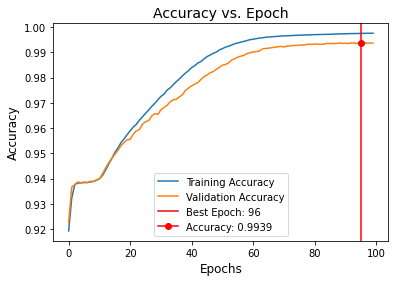

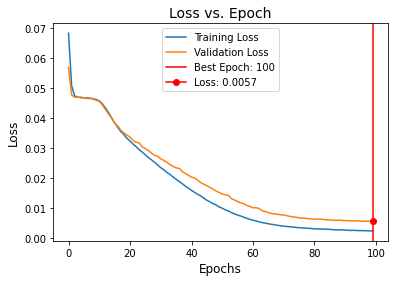

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True, pre_train=pre_train, model_PT=model_PT)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

In [ ]:
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

##### Train Set

Accuracy: 99.76
Normalized confusion matrix
[[9.99893095e-01 1.06904504e-04]
 [2.95957998e-02 9.70404200e-01]]


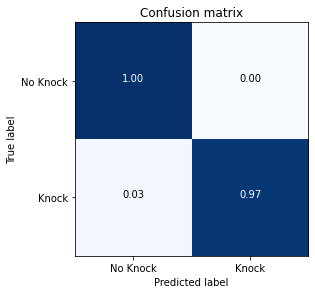

Confusion matrix, without normalization
[[327360     35]
 [   823  26985]]


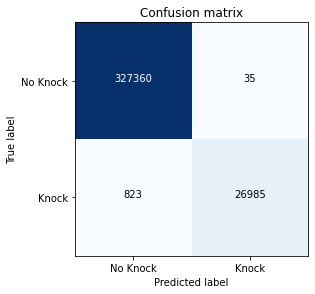

In [ ]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, train_loader)

##### Validation Set

Accuracy: 99.37
Normalized confusion matrix
[[0.99830399 0.00169601]
 [0.06083011 0.93916989]]


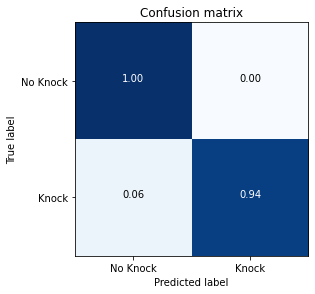

Confusion matrix, without normalization
[[140091    238]
 [   724  11178]]


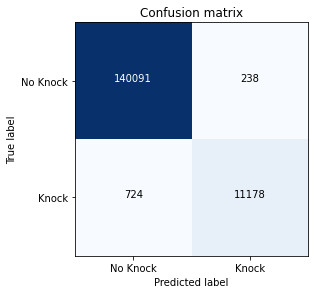

In [ ]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, val_loader)

##### Test Set (6k)

Accuracy: 99.64
Normalized confusion matrix
[[9.99416322e-01 5.83677553e-04]
 [3.89574414e-02 9.61042558e-01]]


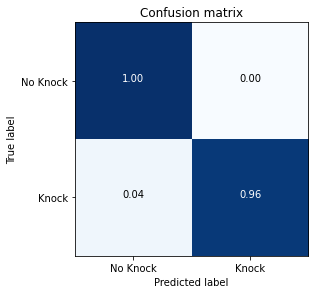

Confusion matrix, without normalization
[[467451    273]
 [  1547  38163]]


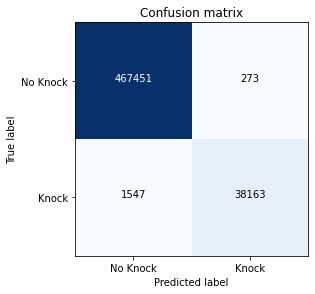

In [ ]:
currGames = 8000
test_loader_6k, classes = load_test_data(currGames)
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_6k, mode='val')

##### Test Set (2k)

Test on all three models generated:
- all epoch
- max validation accuracy
- min validation loss

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(currGames)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

Accuracy: 96.35
Normalized confusion matrix
[[0.98096126 0.01903874]
 [0.23840409 0.76159591]]


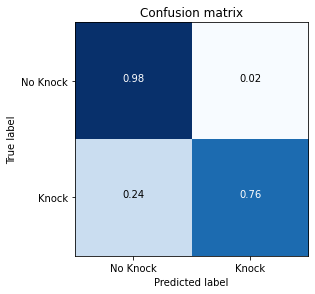

Confusion matrix, without normalization
[[115724   2246]
 [  2426   7750]]


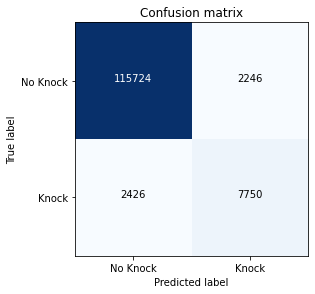

In [ ]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_2k)

Accuracy: 96.35
Normalized confusion matrix
[[0.98068153 0.01931847]
 [0.23545597 0.76454402]]


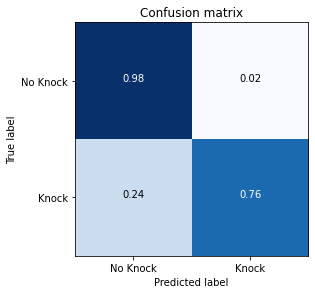

Confusion matrix, without normalization
[[115691   2279]
 [  2396   7780]]


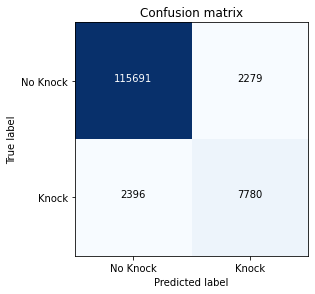

In [ ]:
model_acc, loss_fnc, _ = load_model(model=model_acc)
plot_cm(classes, model_acc, test_loader_2k, mode='acc')

Accuracy: 96.35
Normalized confusion matrix
[[0.98096126 0.01903874]
 [0.23840409 0.76159591]]


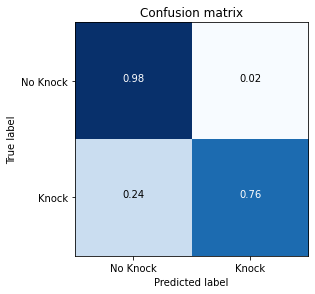

Confusion matrix, without normalization
[[115724   2246]
 [  2426   7750]]


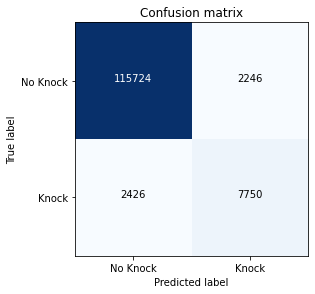

In [ ]:
model_loss, loss_fnc, _ = load_model(model=model_loss)
plot_cm(classes, model_loss, test_loader_2k, mode='loss')

# After Pickup, Before Discard: Knock (apbd_knock)

i.e. Before Pickup, Before Discard: Draw (bpbd_draw)

## all_states_knock_only

Specify the following parameters:

- Data Selection:
 - model_name
 - state-action pair
```r
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'}
```
 - numGames
 - pruneStatesList
 ```r
 {'currHand','topCard','deadCard','oppCard','unknownCard'}
 ```
 - actionChoice = 'all'
```r
{'all','draw_pickup','discard','knock'}
```

- Model Parameters:

| Parameter     | Type      |Default|
| ------------- |:---------:| -----:|
| batch_size    | int       | 1000  |
| learning_rate | float     | 0.001 |
| epoch         | int       | 100   |
| pre_train     | bool (T/F)| False |
| model_PT      | str (path)| null  |

In [ ]:
# model name
model_name = 'all_states_knock_only'

# state_action pair, and dataset selection
state = 'apbd'
action = 'knock'
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'knock'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 500

# Pretrain model
pre_train = False
model_PT = ''

### Directories

In [ ]:
# create model and plot directories if do not exist

# model directories
state_pth = '{}/models/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
model_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(model_pth):
    os.mkdir(model_pth)

# plot directories
state_pth = '{}/plots/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
plot_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(plot_pth):
    os.mkdir(plot_pth)

# data directory
data_pth = '{}/data/{}/{}'.format(pth,state,action)

### Load, Prune, Split Data

In [ ]:
if action in state_action_pair[state]:
    states = np.load('{}/s_{}k.npy'.format(data_pth,numGames//1000))
    actions = np.load('{}/a_{}k.npy'.format(data_pth,numGames//1000))

    # prune states
    states = pruneStates(states, pruneStatesList)

    # choosable actions
    actions, classes = chooseActions(actions, all_classes, actionChoice)

    # balance classes
    if balance:
        states,actions = balanceClasses(states,actions)

    # split train/val
    data_train, data_val, label_train, label_val = train_test_split(states, actions, test_size=0.3, random_state=421)
else:
    print('illegeal state-action pair')

In [ ]:
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

### Train Model

Epoch: 1 | Train Loss: 0.04480982 | Train acc: 0.029912
              Val Loss: 0.01883849 |   Val acc: 0.065941
Epoch: 2 | Train Loss: 0.01886354 | Train acc: 0.072573
              Val Loss: 0.01884613 |   Val acc: 0.073398
Epoch: 3 | Train Loss: 0.01878950 | Train acc: 0.067114
              Val Loss: 0.01870421 |   Val acc: 0.068287
Epoch: 4 | Train Loss: 0.01861860 | Train acc: 0.067186
              Val Loss: 0.01852118 |   Val acc: 0.068622
Epoch: 5 | Train Loss: 0.01848015 | Train acc: 0.099971
              Val Loss: 0.01842532 |   Val acc: 0.132719
Epoch: 6 | Train Loss: 0.01841443 | Train acc: 0.096524
              Val Loss: 0.01838577 |   Val acc: 0.107080
Epoch: 7 | Train Loss: 0.01838208 | Train acc: 0.154338
              Val Loss: 0.01835587 |   Val acc: 0.199330
Epoch: 8 | Train Loss: 0.01835588 | Train acc: 0.192581
              Val Loss: 0.01833097 |   Val acc: 0.160620
Epoch: 9 | Train Loss: 0.01833002 | Train acc: 0.164536
              Val Loss: 0.01830404 |   V

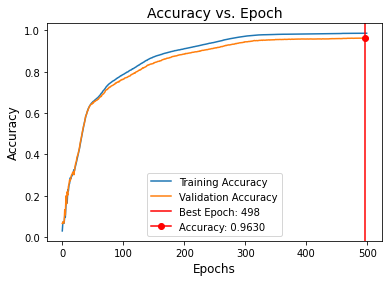

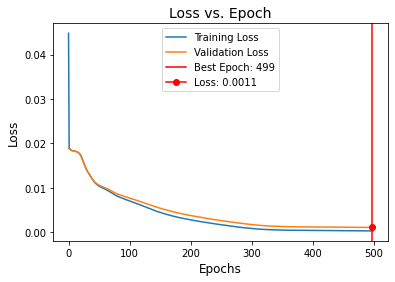

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True, pre_train=pre_train, model_PT=model_PT)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

In [ ]:
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

##### Train Set

Accuracy: 98.63
Normalized confusion matrix
[[0.38461509 0.         0.         ... 0.         0.         0.        ]
 [0.         0.62162158 0.         ... 0.02027027 0.01351351 0.02027027]
 [0.         0.         0.95723681 ... 0.         0.00657895 0.        ]
 ...
 [0.         0.         0.         ... 0.96052619 0.         0.        ]
 [0.         0.         0.         ... 0.         0.99999989 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999988]]


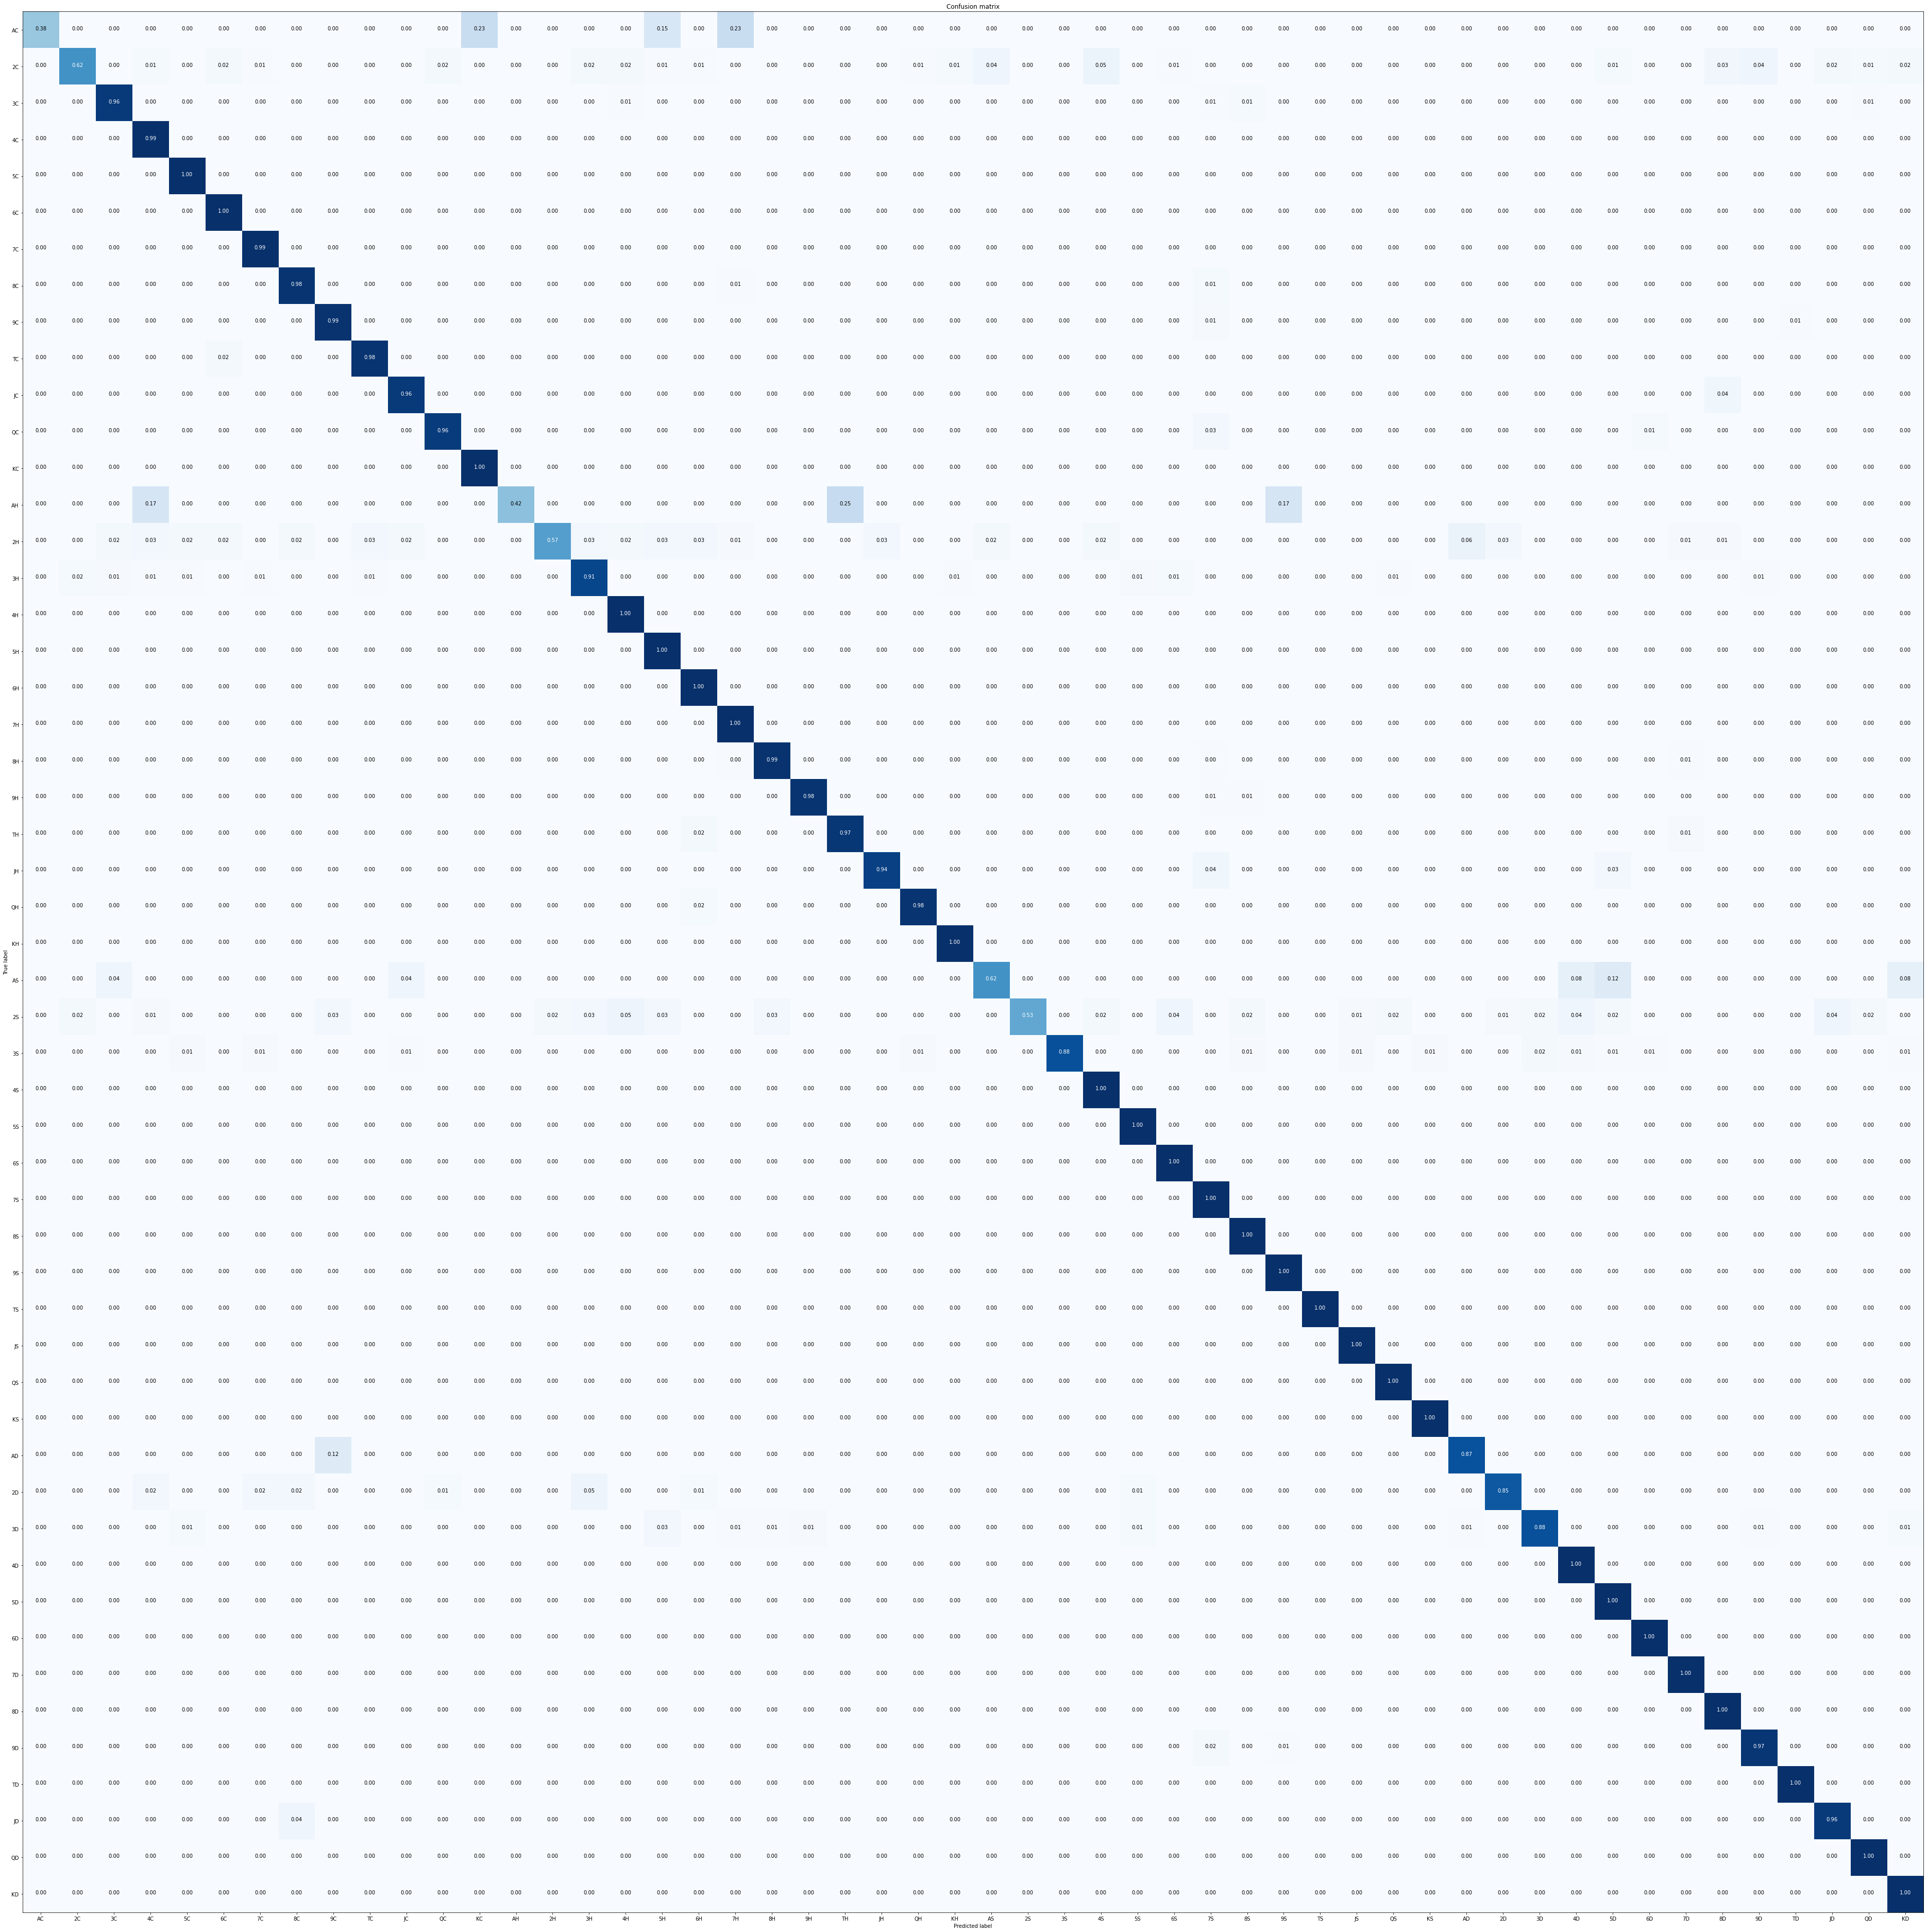

Confusion matrix, without normalization
[[  5   0   0 ...   0   0   0]
 [  0  92   0 ...   3   2   3]
 [  0   0 291 ...   0   2   0]
 ...
 [  0   0   0 ...  73   0   0]
 [  0   0   0 ...   0  90   0]
 [  0   0   0 ...   0   0  84]]


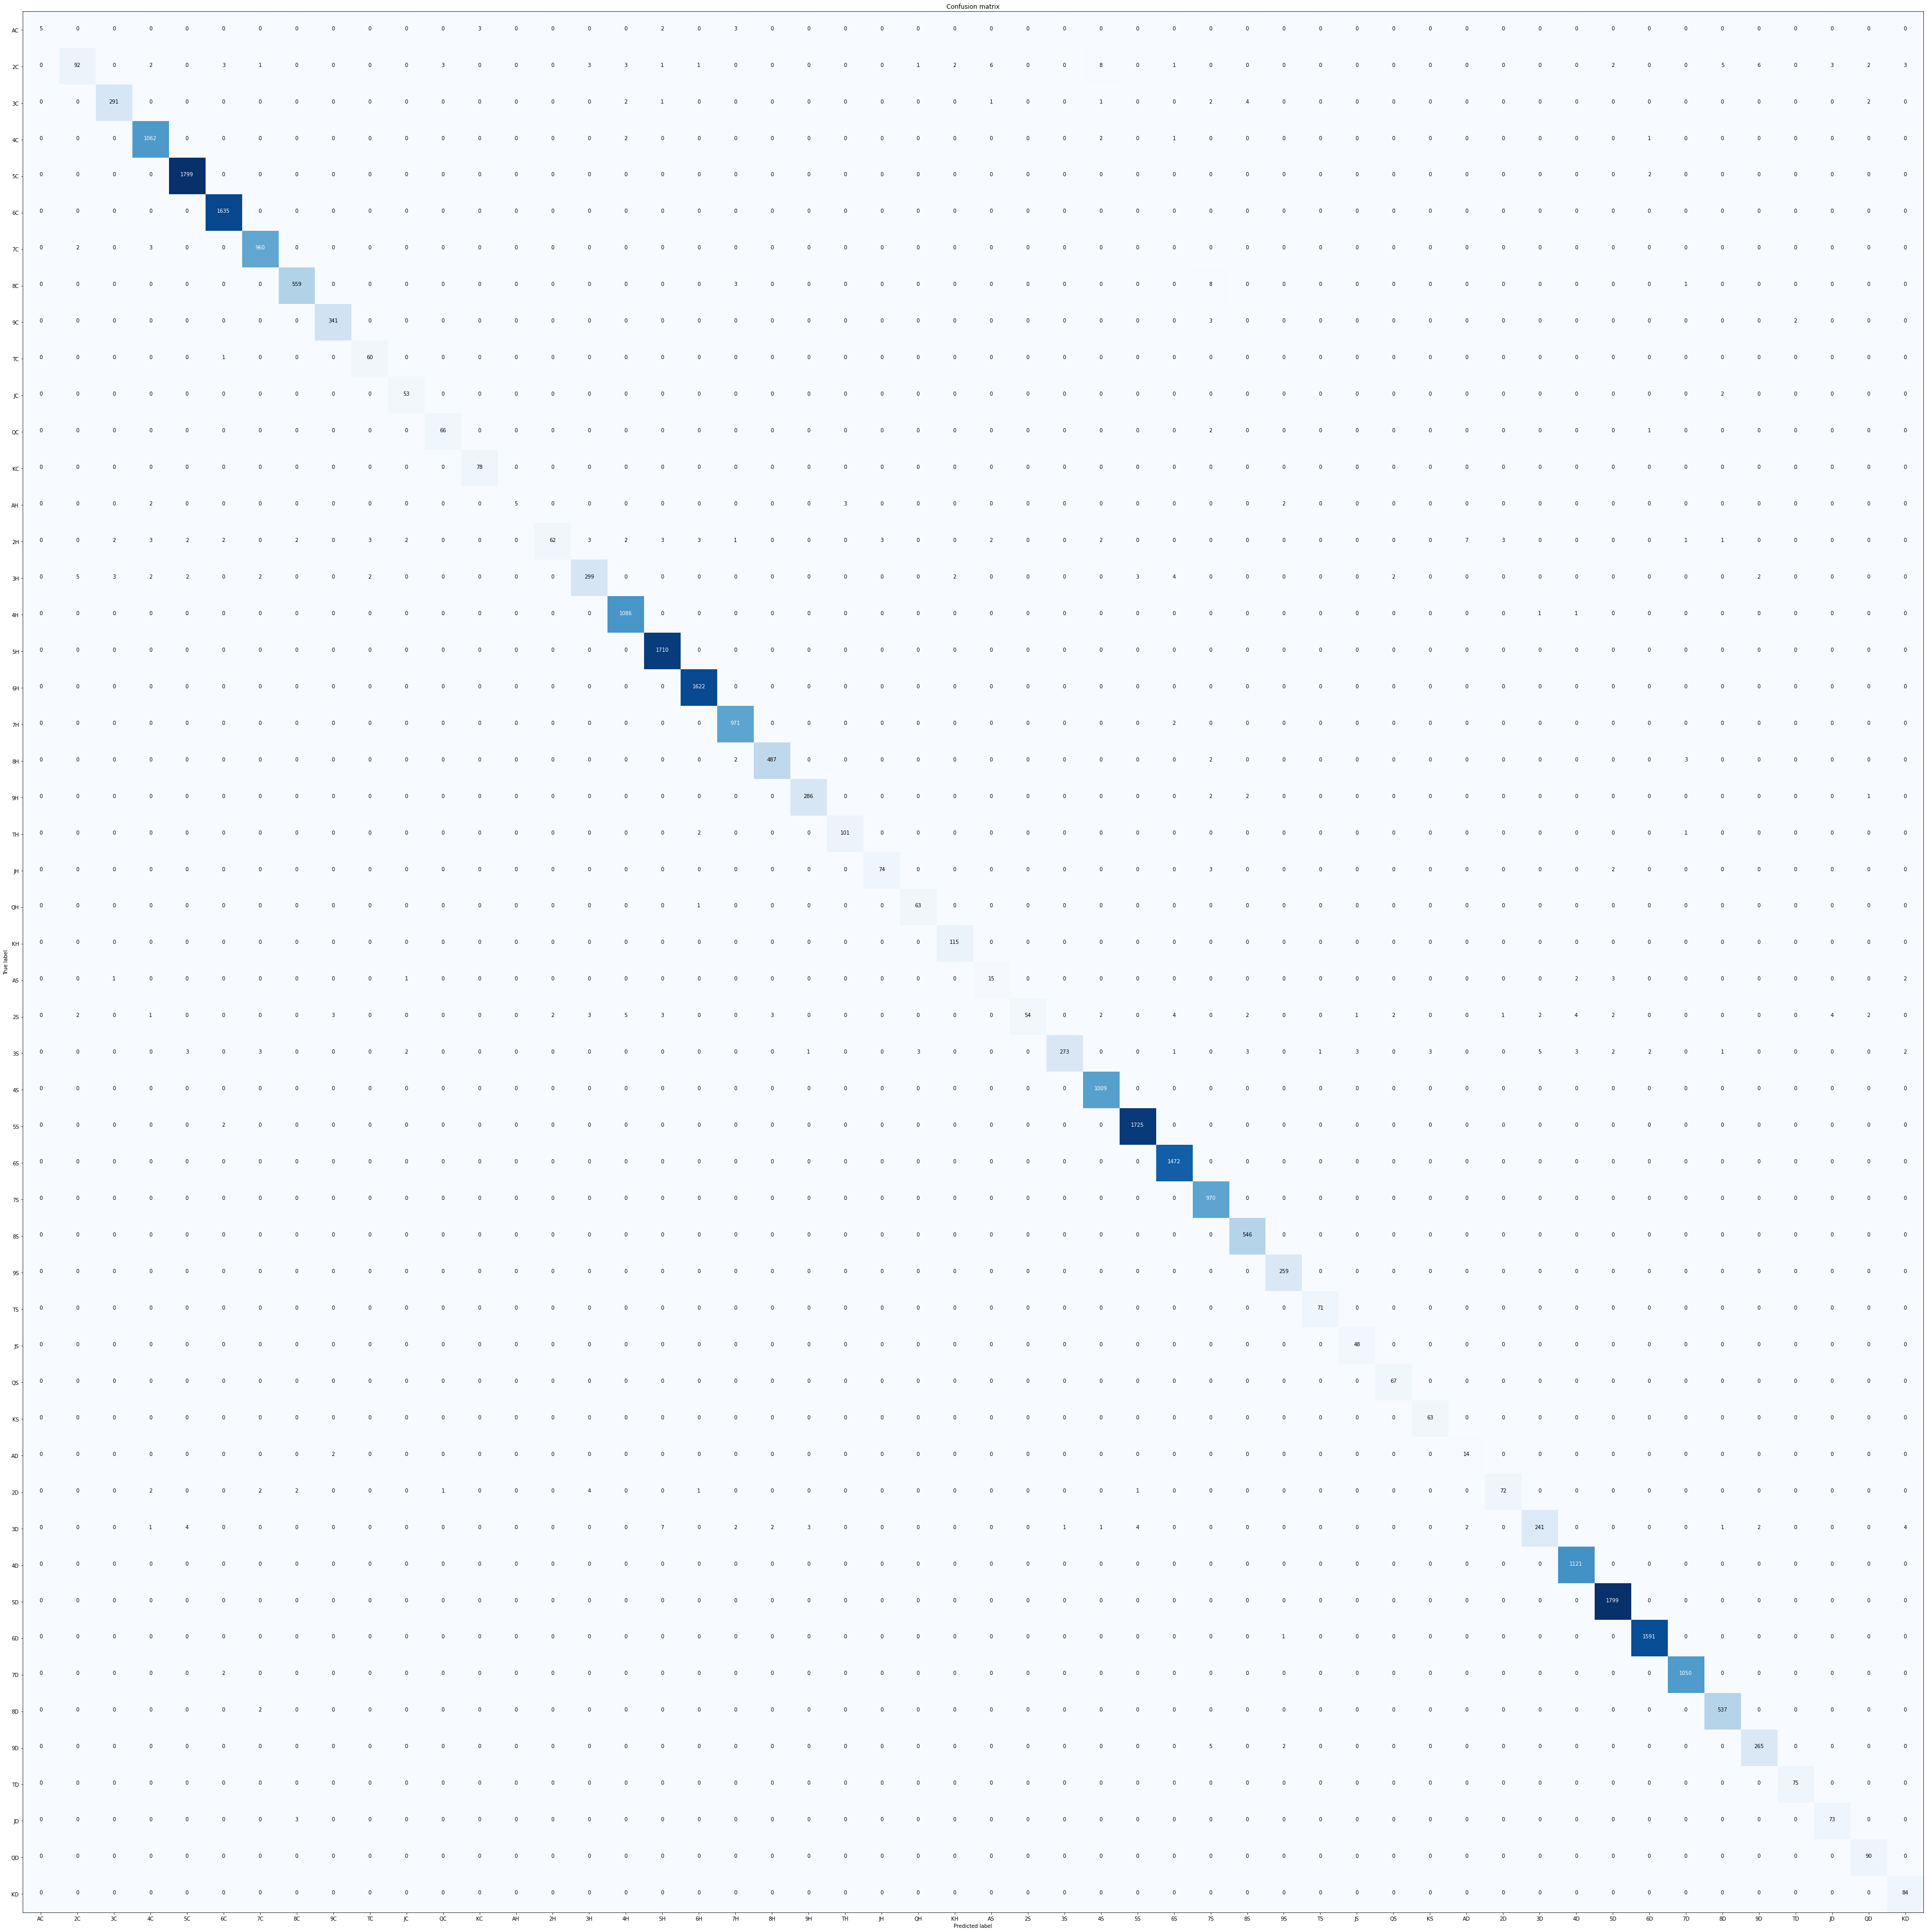

In [ ]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, train_loader)

##### Validation Set

Accuracy: 96.28
Normalized confusion matrix
[[0.4999975  0.         0.         ... 0.         0.         0.        ]
 [0.         0.5199999  0.         ... 0.         0.02       0.        ]
 [0.         0.         0.80291965 ... 0.         0.00729927 0.        ]
 ...
 [0.         0.         0.         ... 0.99999973 0.         0.        ]
 [0.         0.         0.         ... 0.         0.91428545 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999978]]


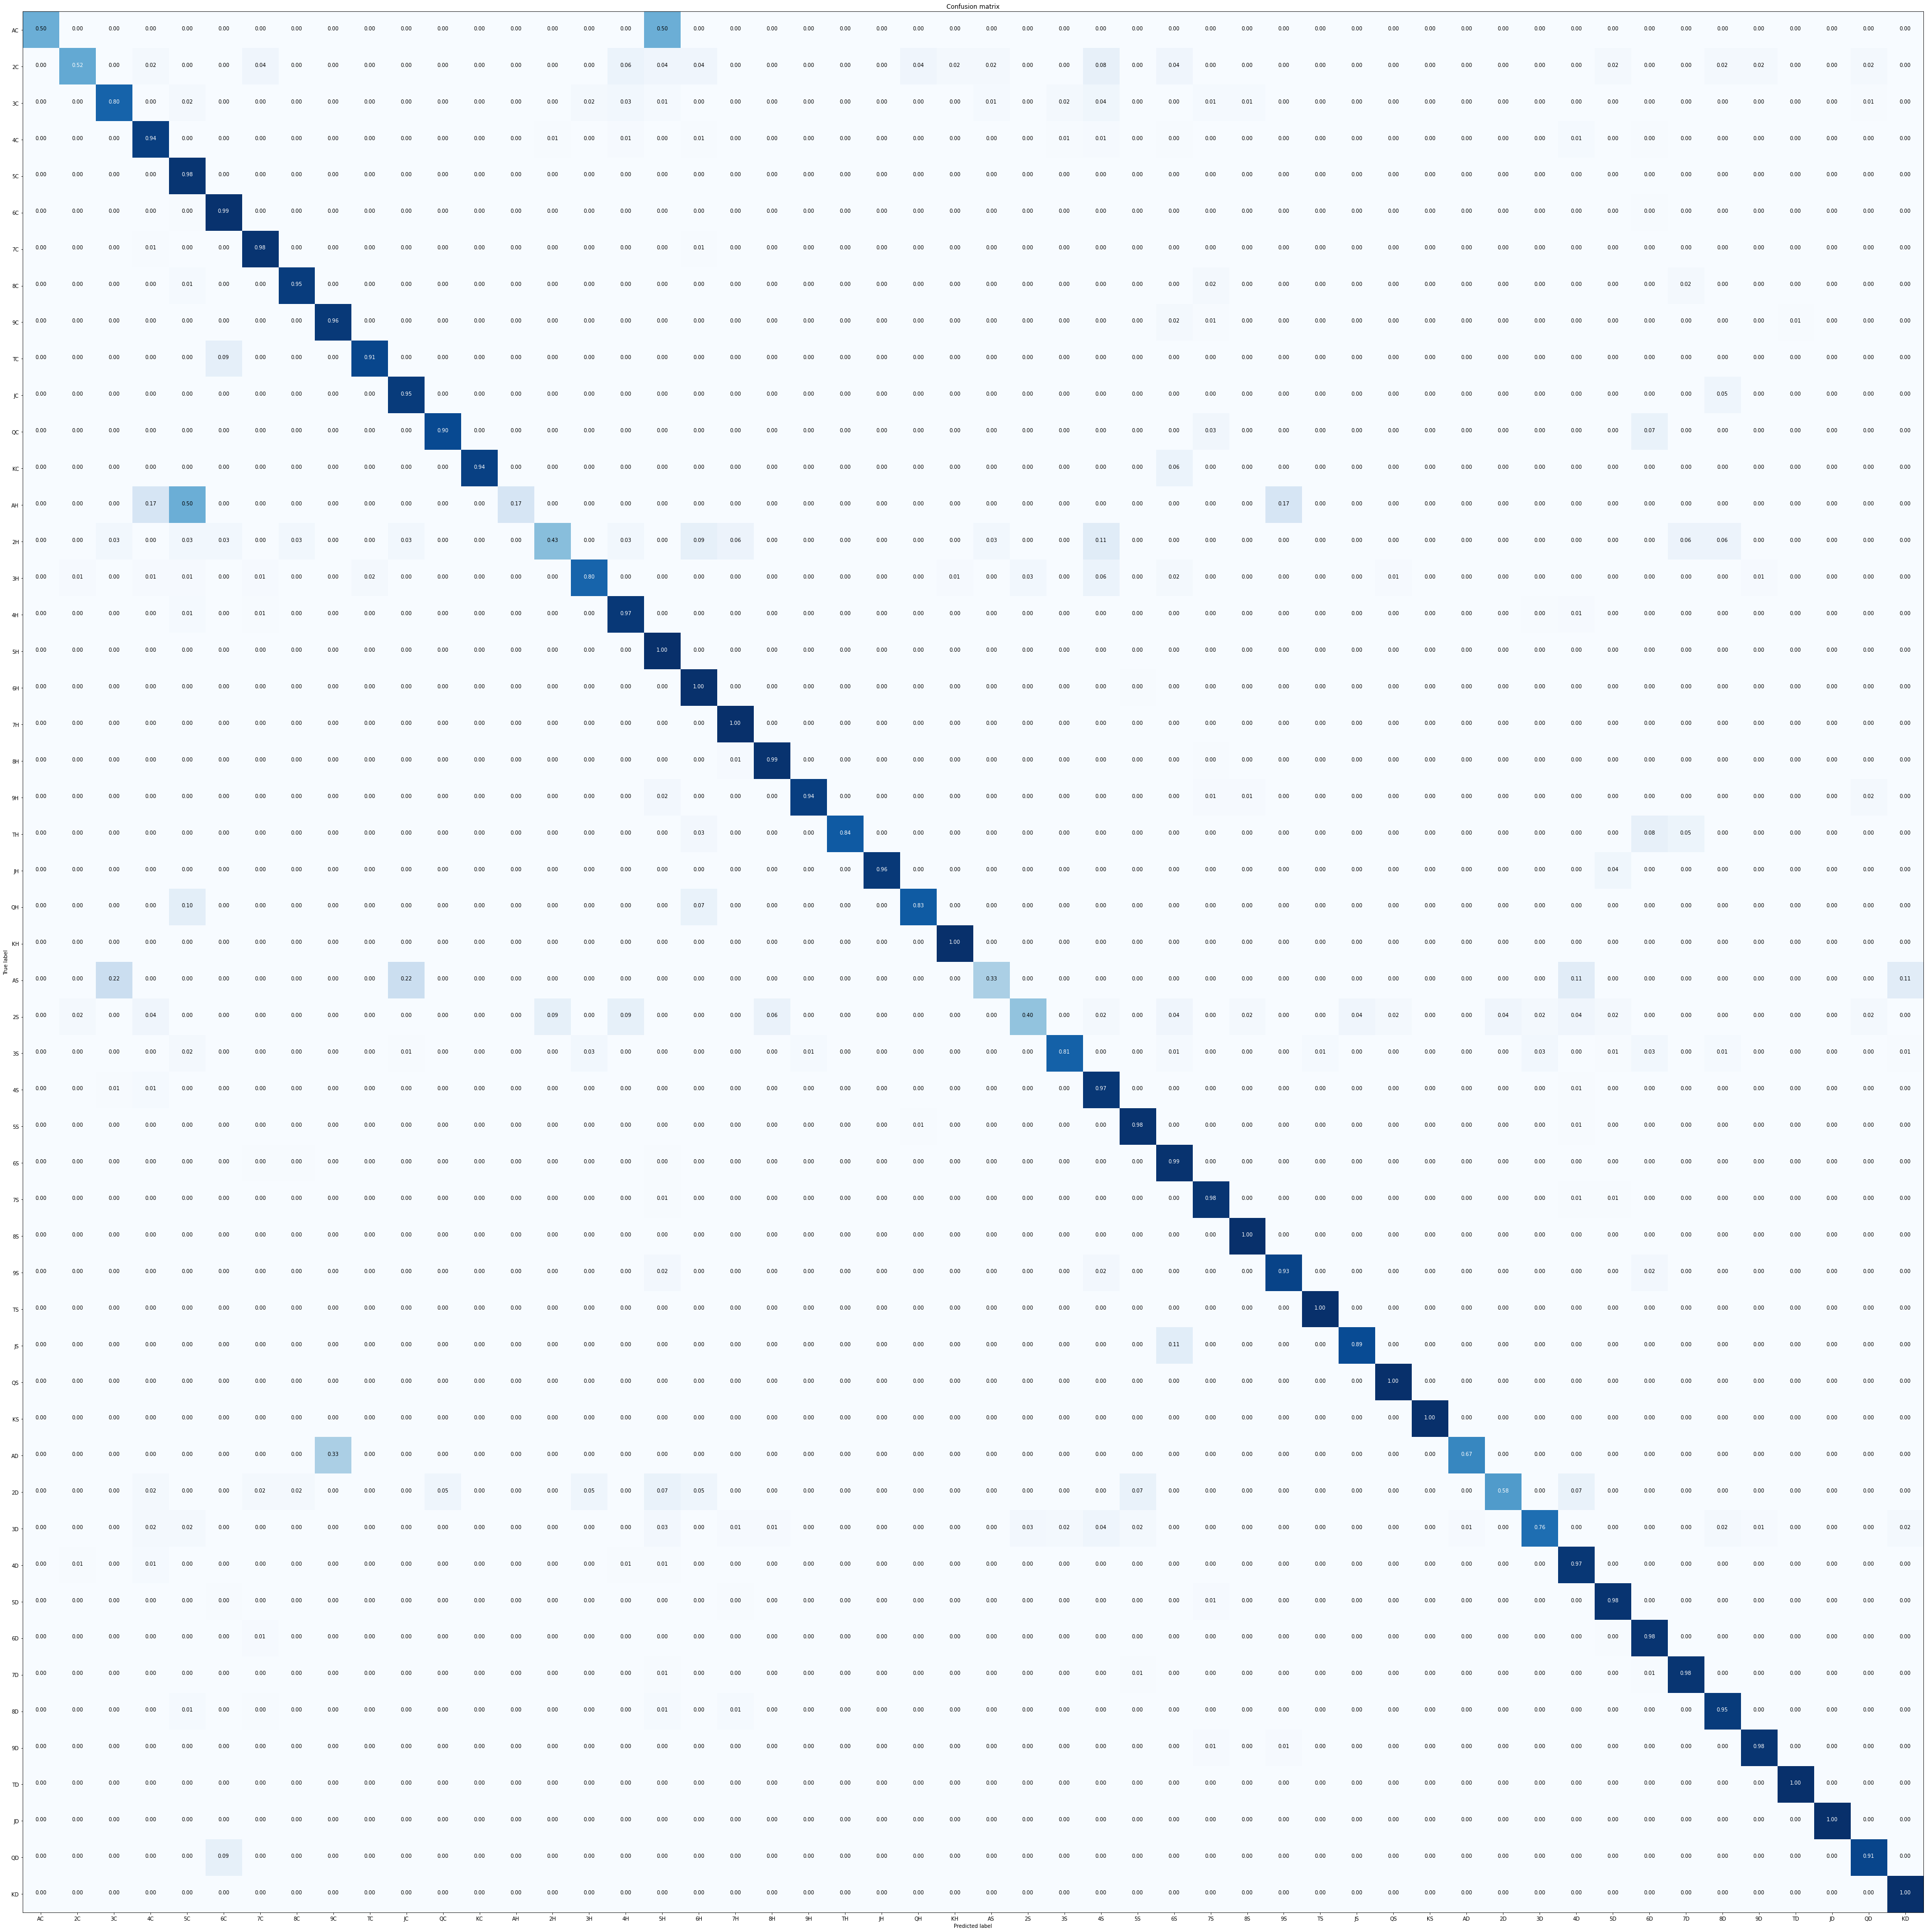

Confusion matrix, without normalization
[[  1   0   0 ...   0   0   0]
 [  0  26   0 ...   0   1   0]
 [  0   0 110 ...   0   1   0]
 ...
 [  0   0   0 ...  37   0   0]
 [  0   0   0 ...   0  32   0]
 [  0   0   0 ...   0   0  46]]


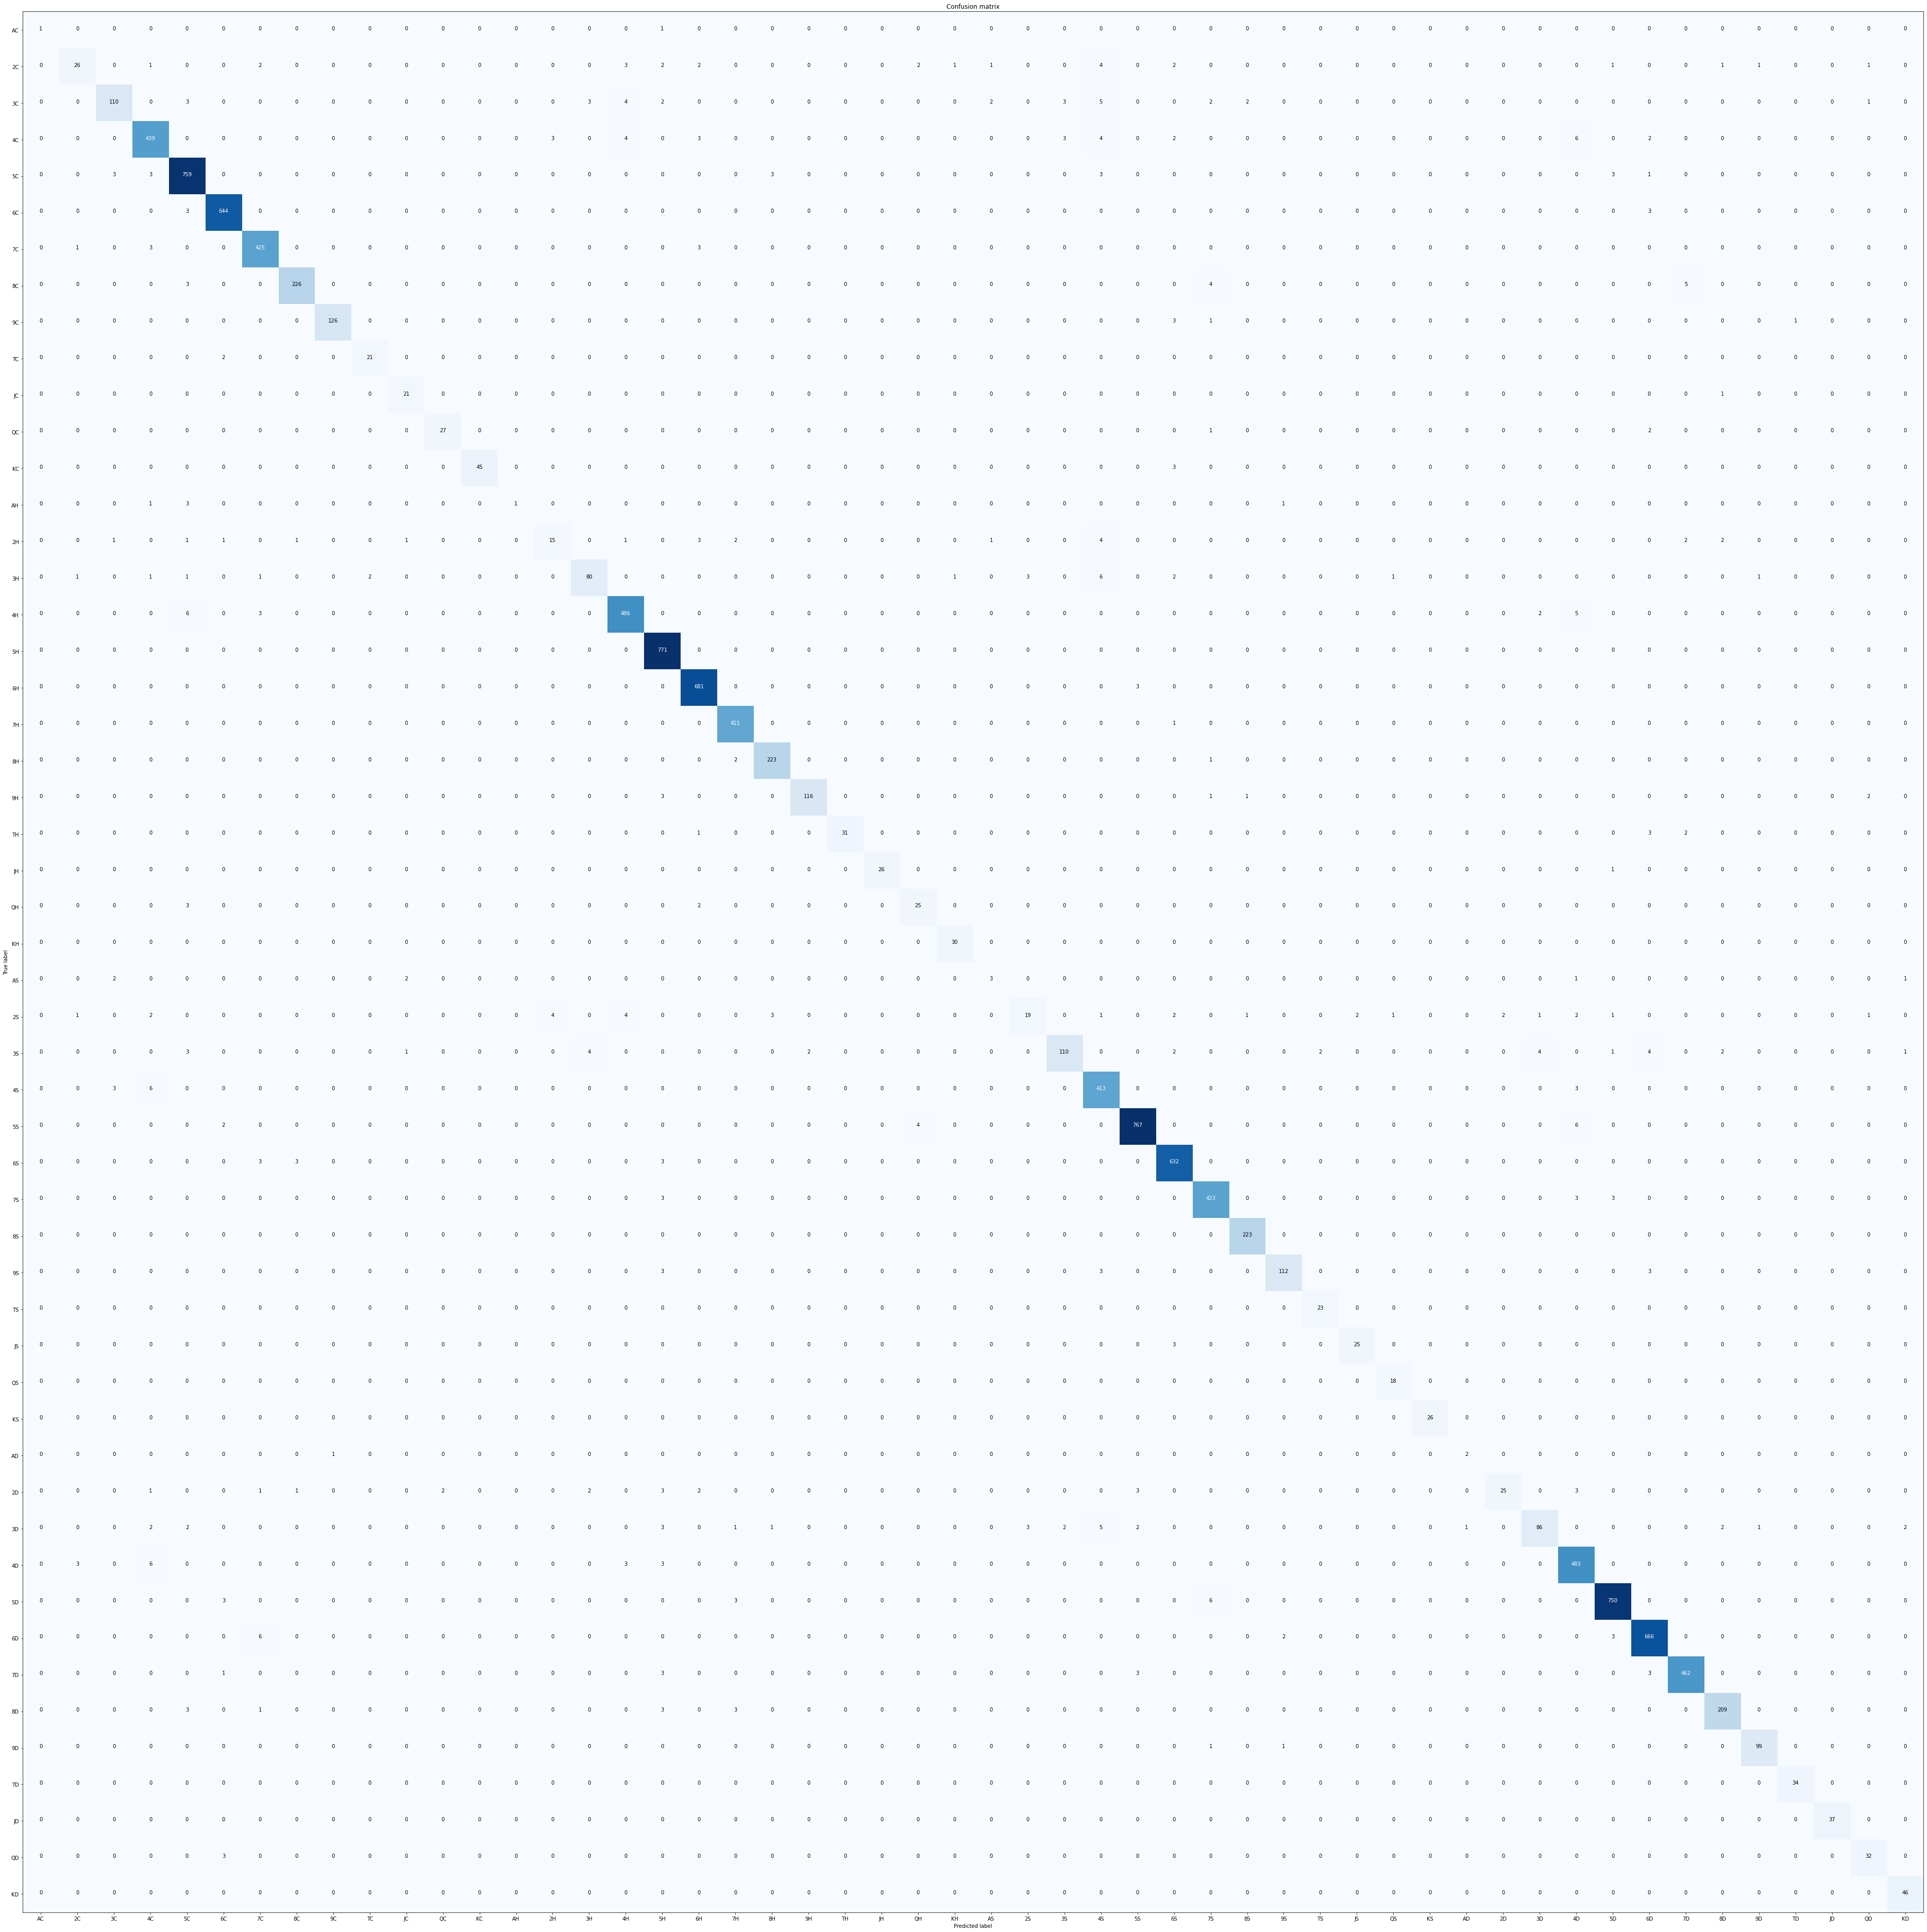

In [ ]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, val_loader)

##### Test Set (6k)

Accuracy: 97.92
Normalized confusion matrix
[[0.39999973 0.         0.         ... 0.         0.         0.        ]
 [0.         0.59595957 0.         ... 0.01515151 0.01515151 0.01515151]
 [0.         0.         0.90929703 ... 0.         0.00680272 0.        ]
 ...
 [0.         0.         0.         ... 0.97345124 0.         0.        ]
 [0.         0.         0.         ... 0.         0.97599992 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999992]]


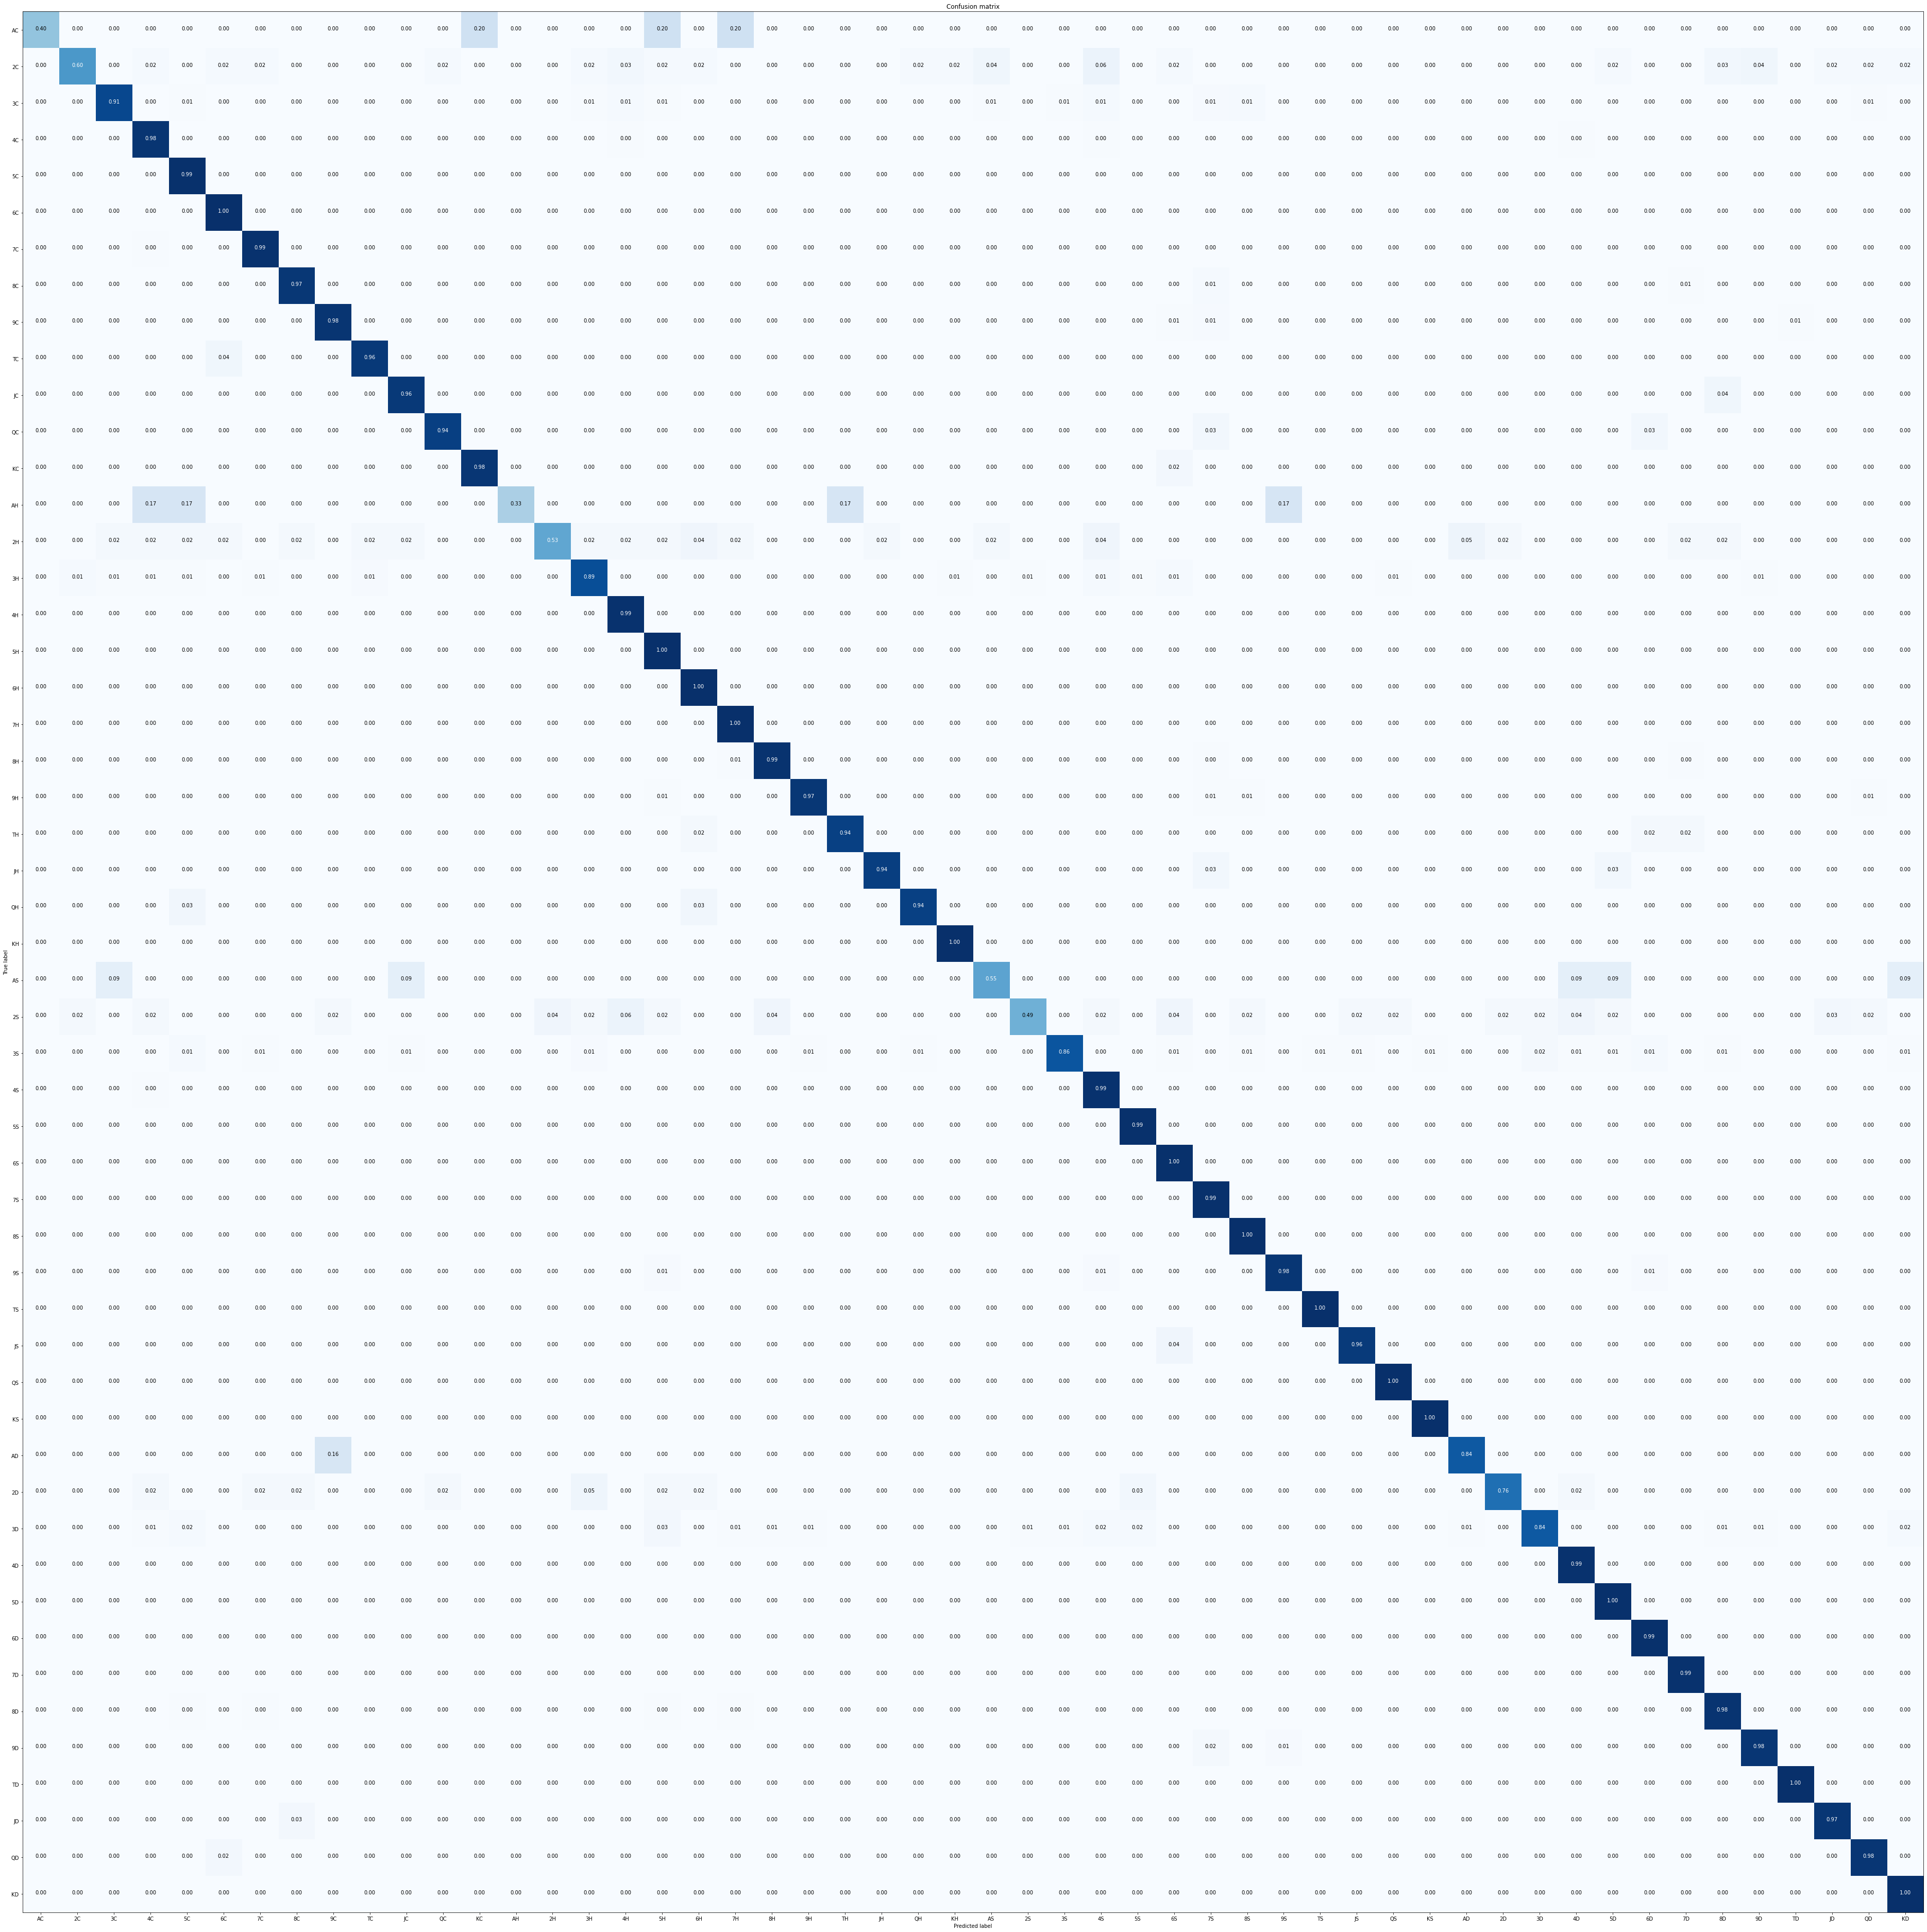

Confusion matrix, without normalization
[[  6   0   0 ...   0   0   0]
 [  0 118   0 ...   3   3   3]
 [  0   0 401 ...   0   3   0]
 ...
 [  0   0   0 ... 110   0   0]
 [  0   0   0 ...   0 122   0]
 [  0   0   0 ...   0   0 130]]


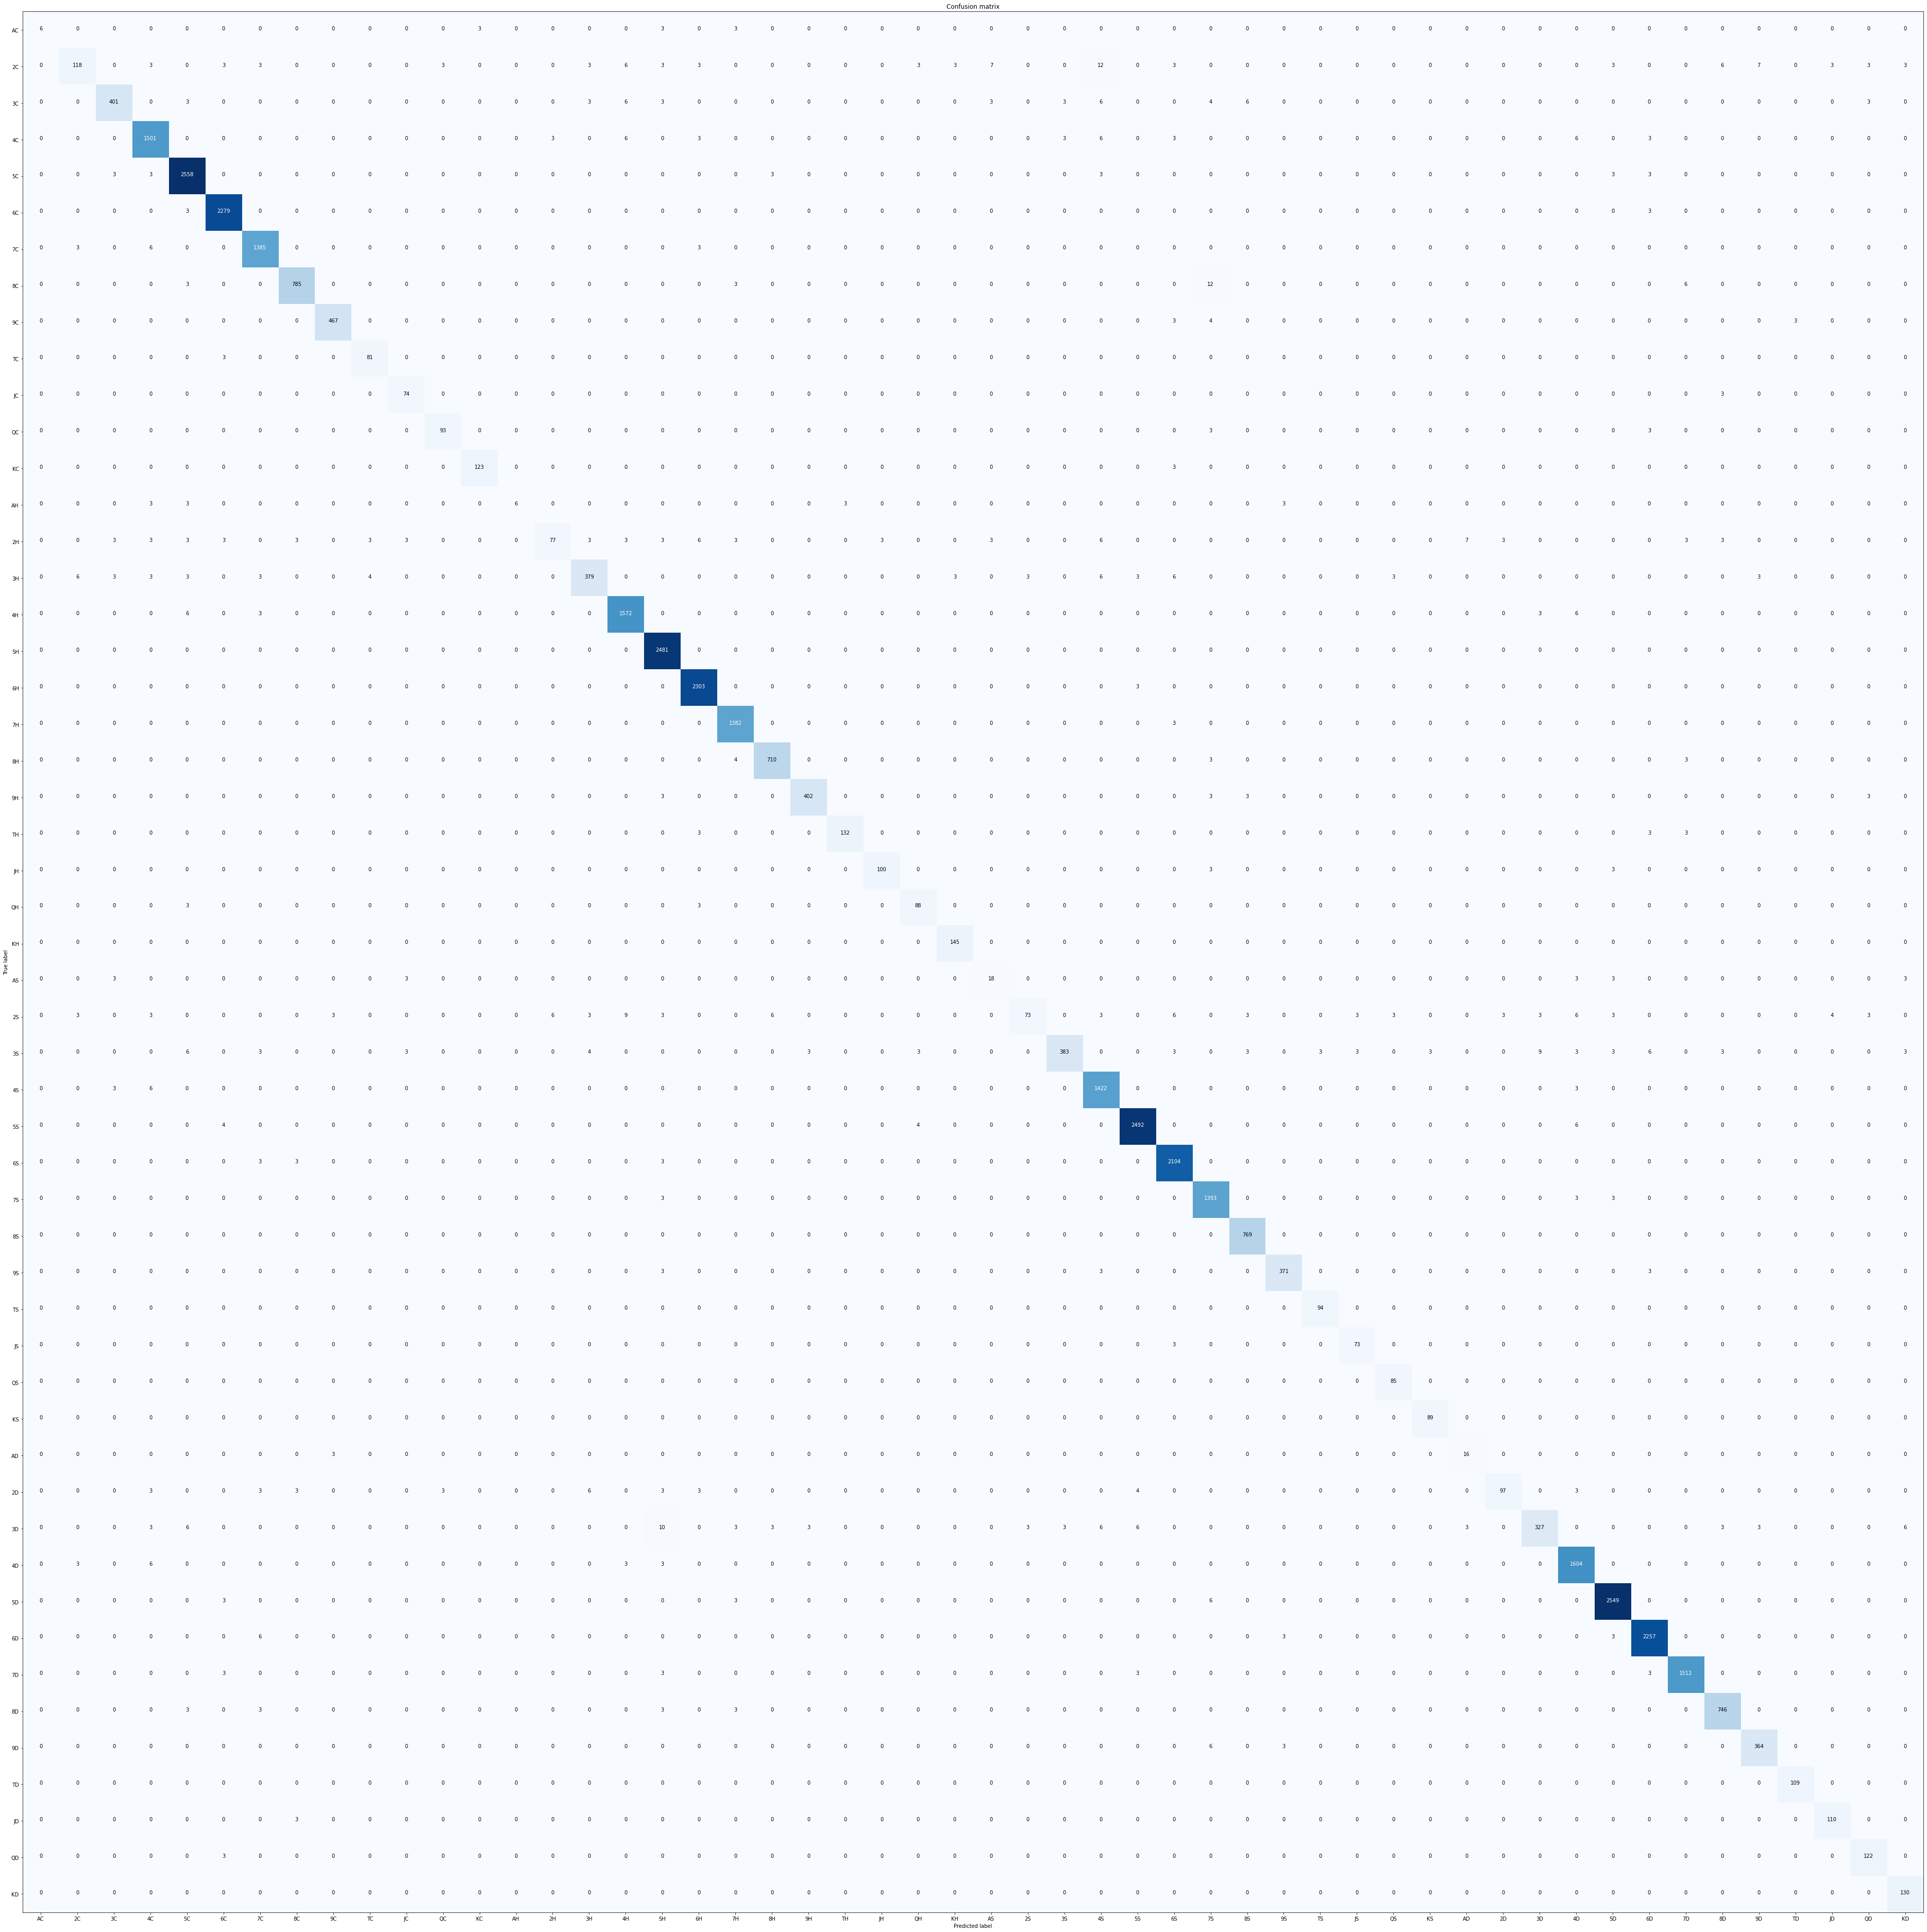

In [ ]:
currGames = 8000
test_loader_6k, classes = load_test_data(currGames)
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_6k, mode='val')

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(currGames)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

###### all epoch

Accuracy: 97.95
Normalized confusion matrix
[[0.24999938 0.         0.         ... 0.         0.         0.        ]
 [0.         0.6739129  0.         ... 0.02173913 0.         0.        ]
 [0.         0.         0.90990983 ... 0.         0.00900901 0.        ]
 ...
 [0.         0.         0.         ... 0.96296261 0.         0.        ]
 [0.         0.         0.         ... 0.         0.97058795 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999968]]


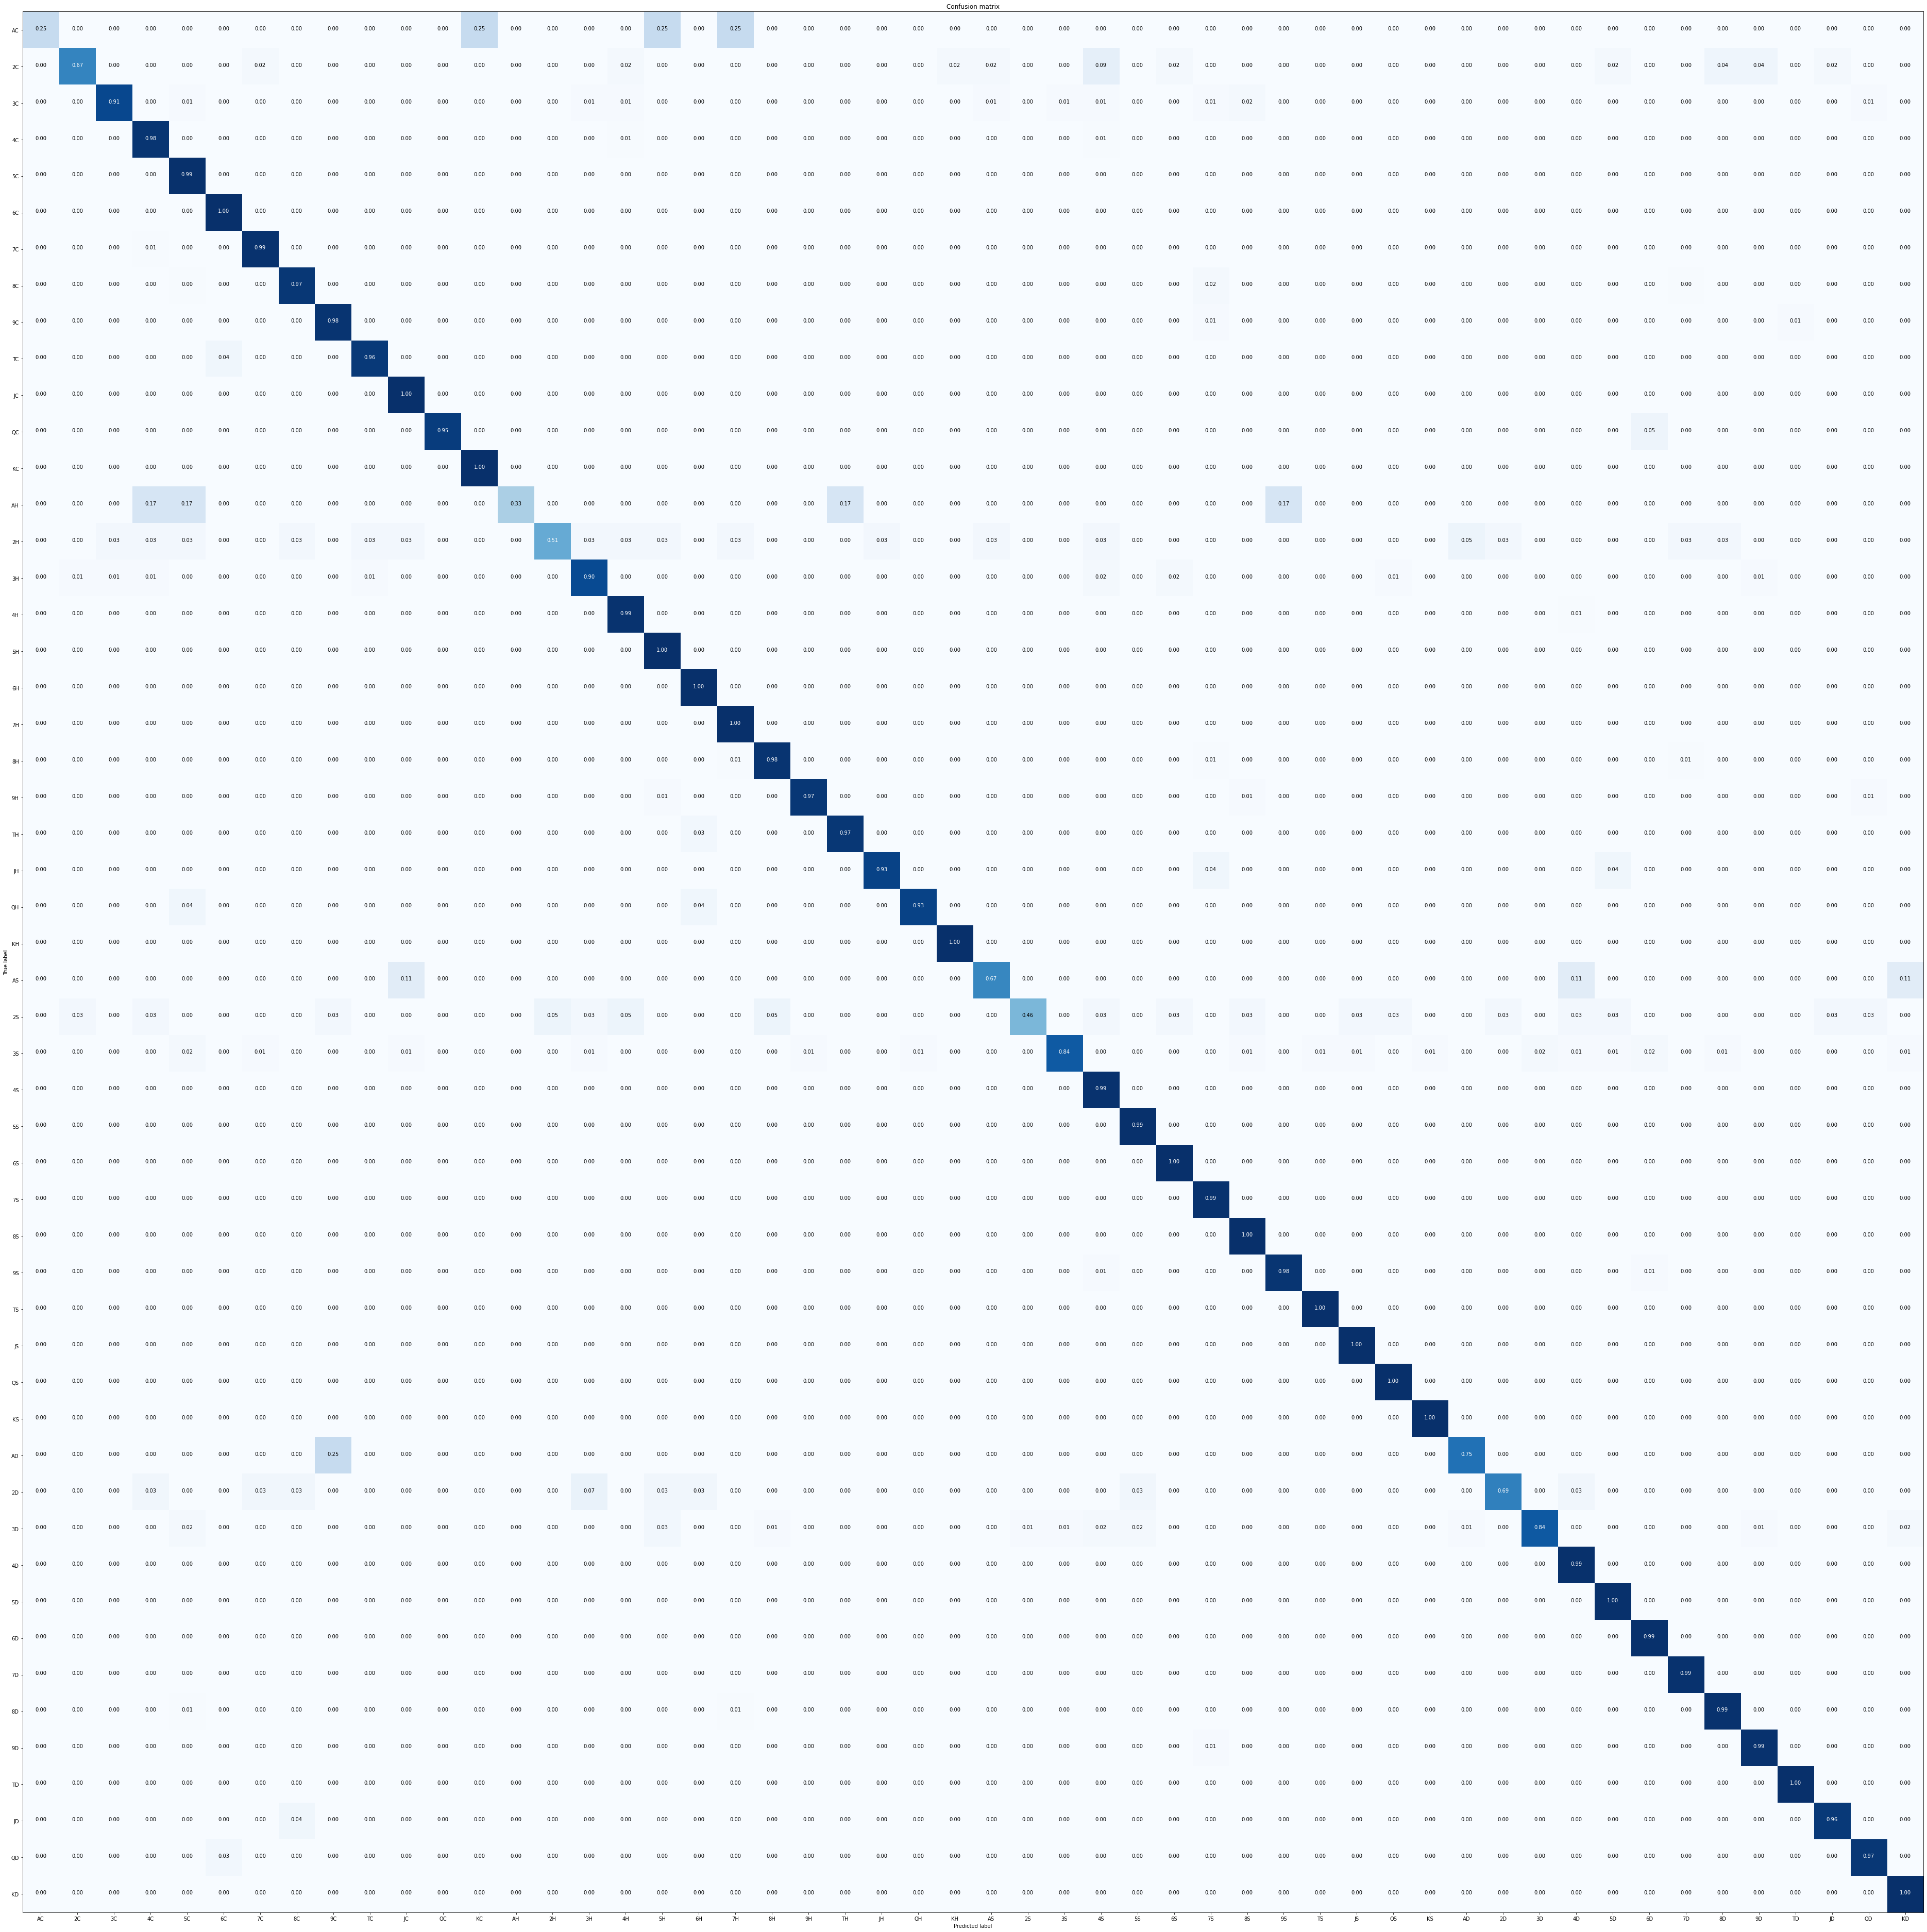

Confusion matrix, without normalization
[[  1   0   0 ...   0   0   0]
 [  0  31   0 ...   1   0   0]
 [  0   0 101 ...   0   1   0]
 ...
 [  0   0   0 ...  26   0   0]
 [  0   0   0 ...   0  33   0]
 [  0   0   0 ...   0   0  31]]


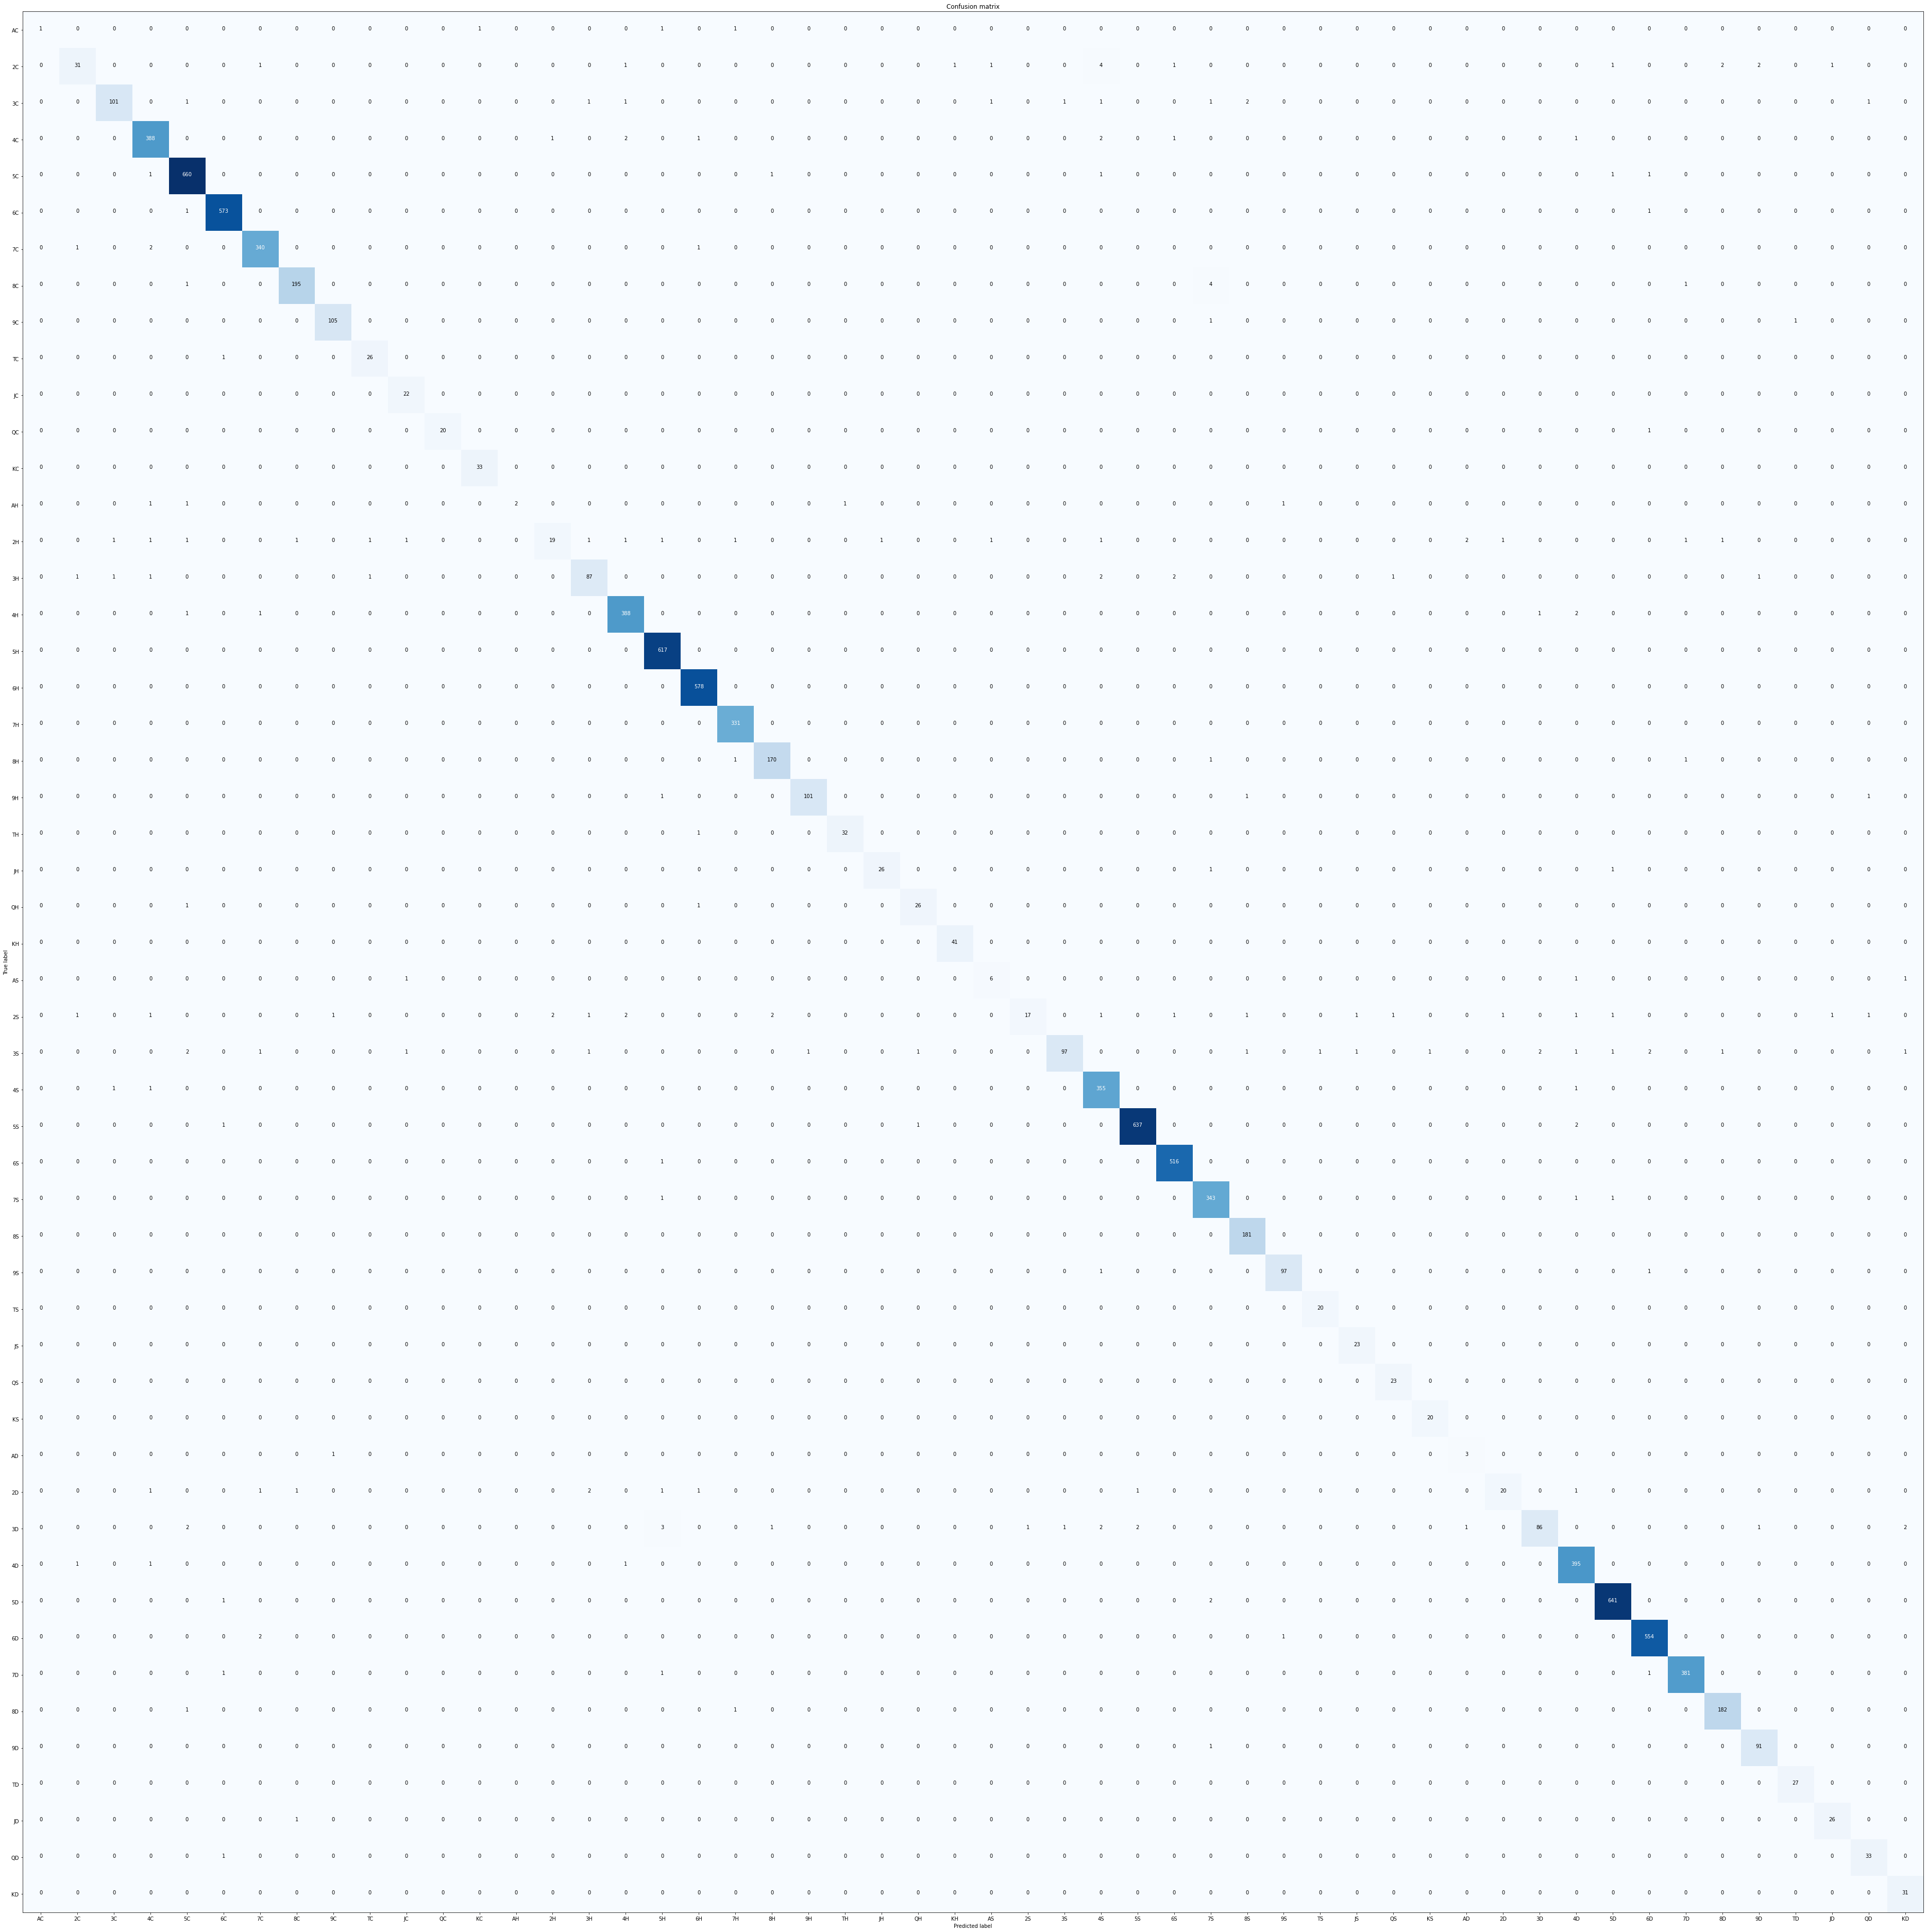

In [ ]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_2k)

###### max validation accuracy

Accuracy: 97.96
Normalized confusion matrix
[[0.24999938 0.         0.         ... 0.         0.         0.        ]
 [0.         0.6739129  0.         ... 0.02173913 0.         0.        ]
 [0.         0.         0.90990983 ... 0.         0.00900901 0.        ]
 ...
 [0.         0.         0.         ... 0.96296261 0.         0.        ]
 [0.         0.         0.         ... 0.         0.97058795 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999968]]


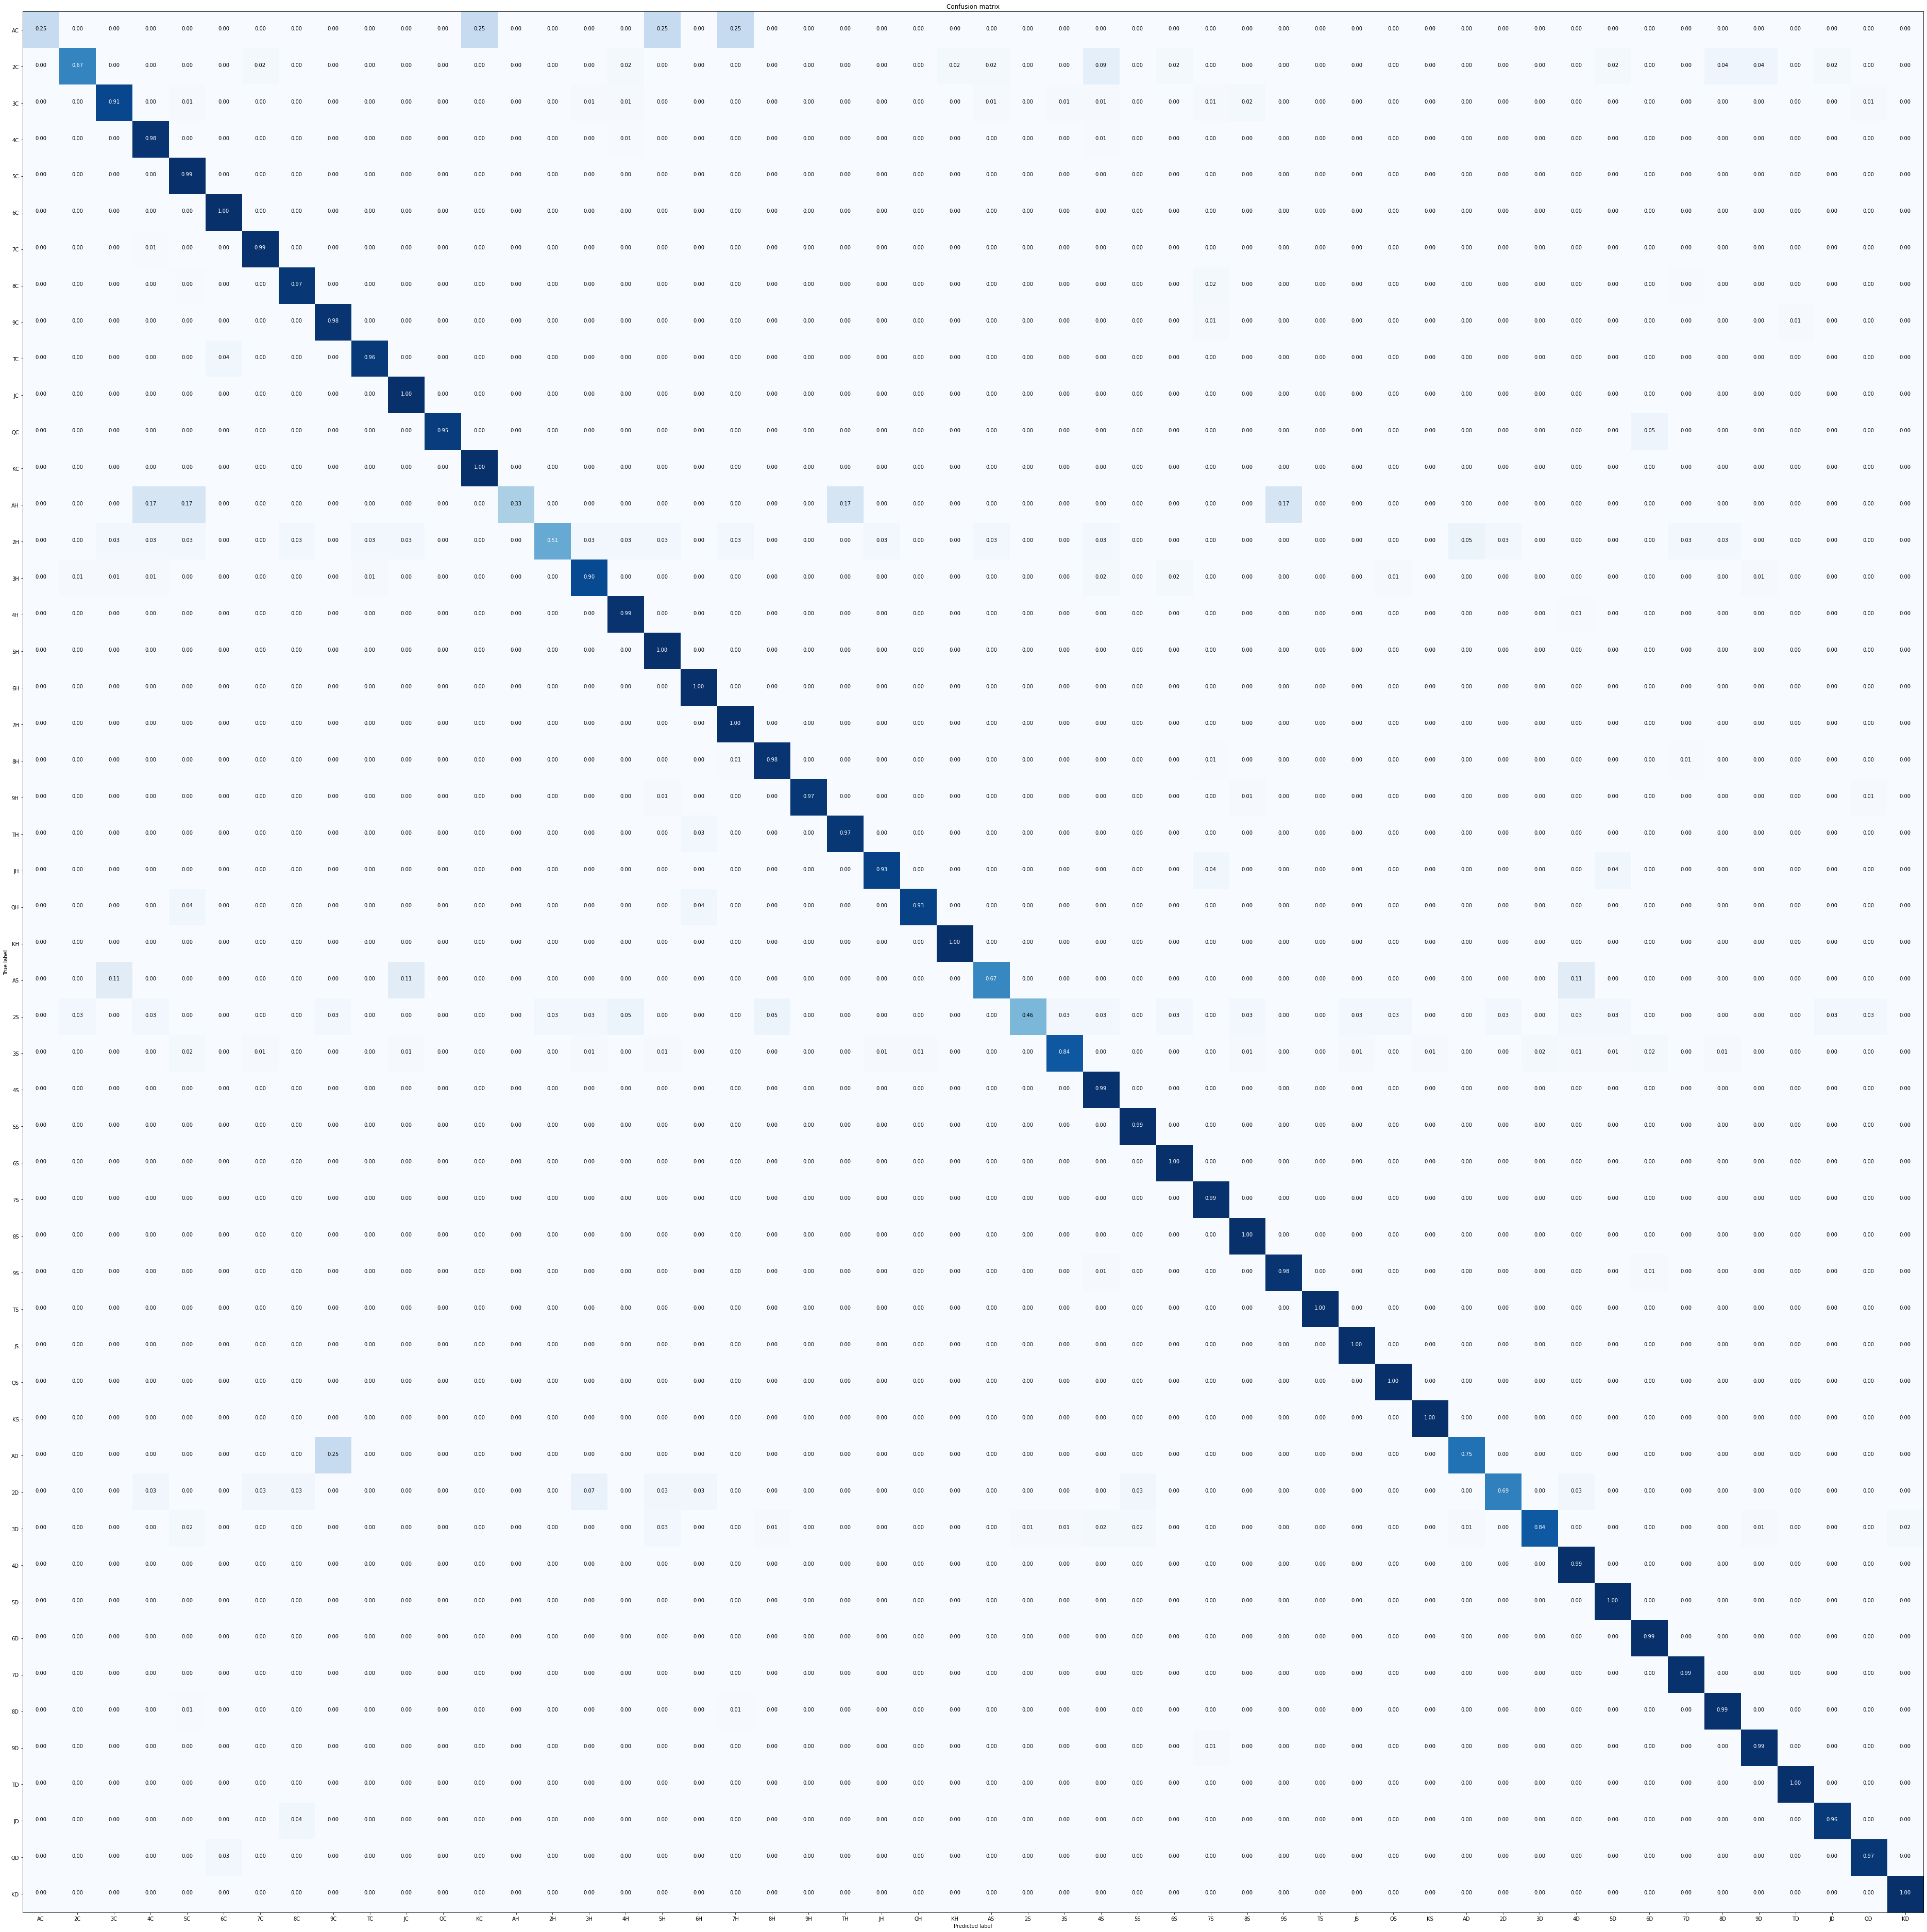

Confusion matrix, without normalization
[[  1   0   0 ...   0   0   0]
 [  0  31   0 ...   1   0   0]
 [  0   0 101 ...   0   1   0]
 ...
 [  0   0   0 ...  26   0   0]
 [  0   0   0 ...   0  33   0]
 [  0   0   0 ...   0   0  31]]


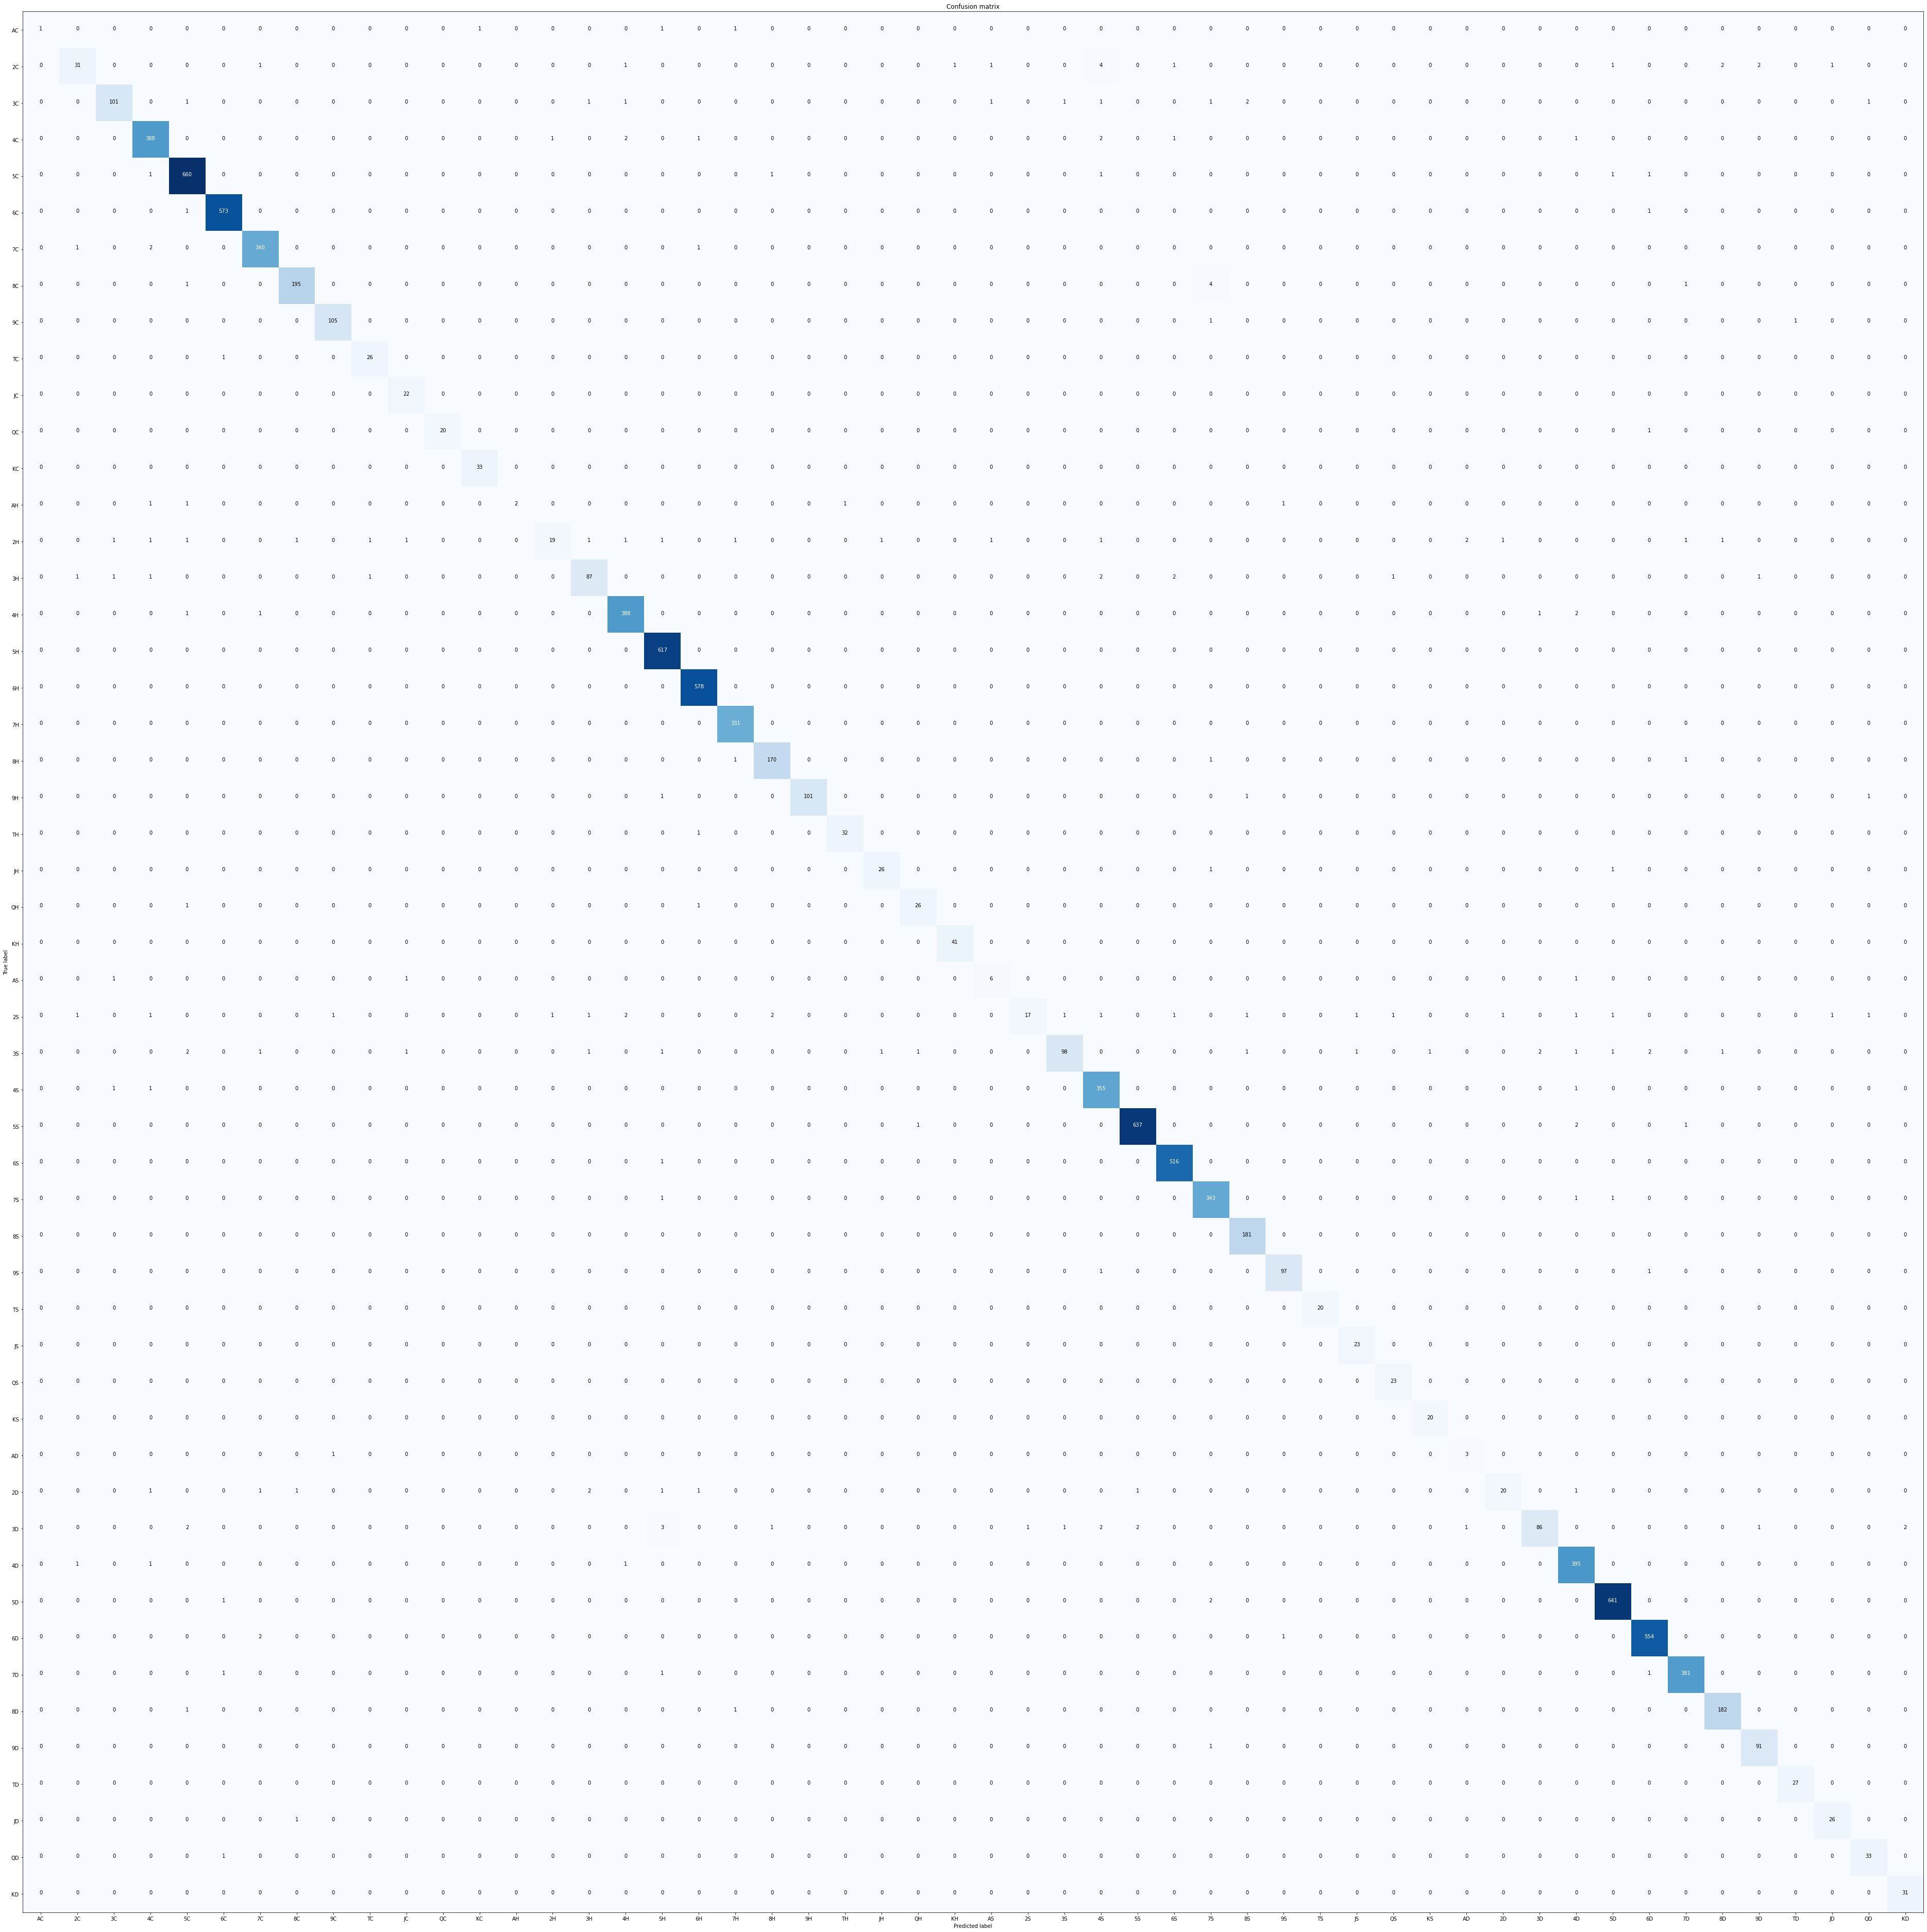

In [ ]:
model_acc, loss_fnc, _ = load_model(model=model_acc)
plot_cm(classes, model_acc, test_loader_2k, mode='acc')

###### min validation loss

Accuracy: 97.95
Normalized confusion matrix
[[0.24999938 0.         0.         ... 0.         0.         0.        ]
 [0.         0.6739129  0.         ... 0.02173913 0.         0.        ]
 [0.         0.         0.90990983 ... 0.         0.00900901 0.        ]
 ...
 [0.         0.         0.         ... 0.96296261 0.         0.        ]
 [0.         0.         0.         ... 0.         0.97058795 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999968]]


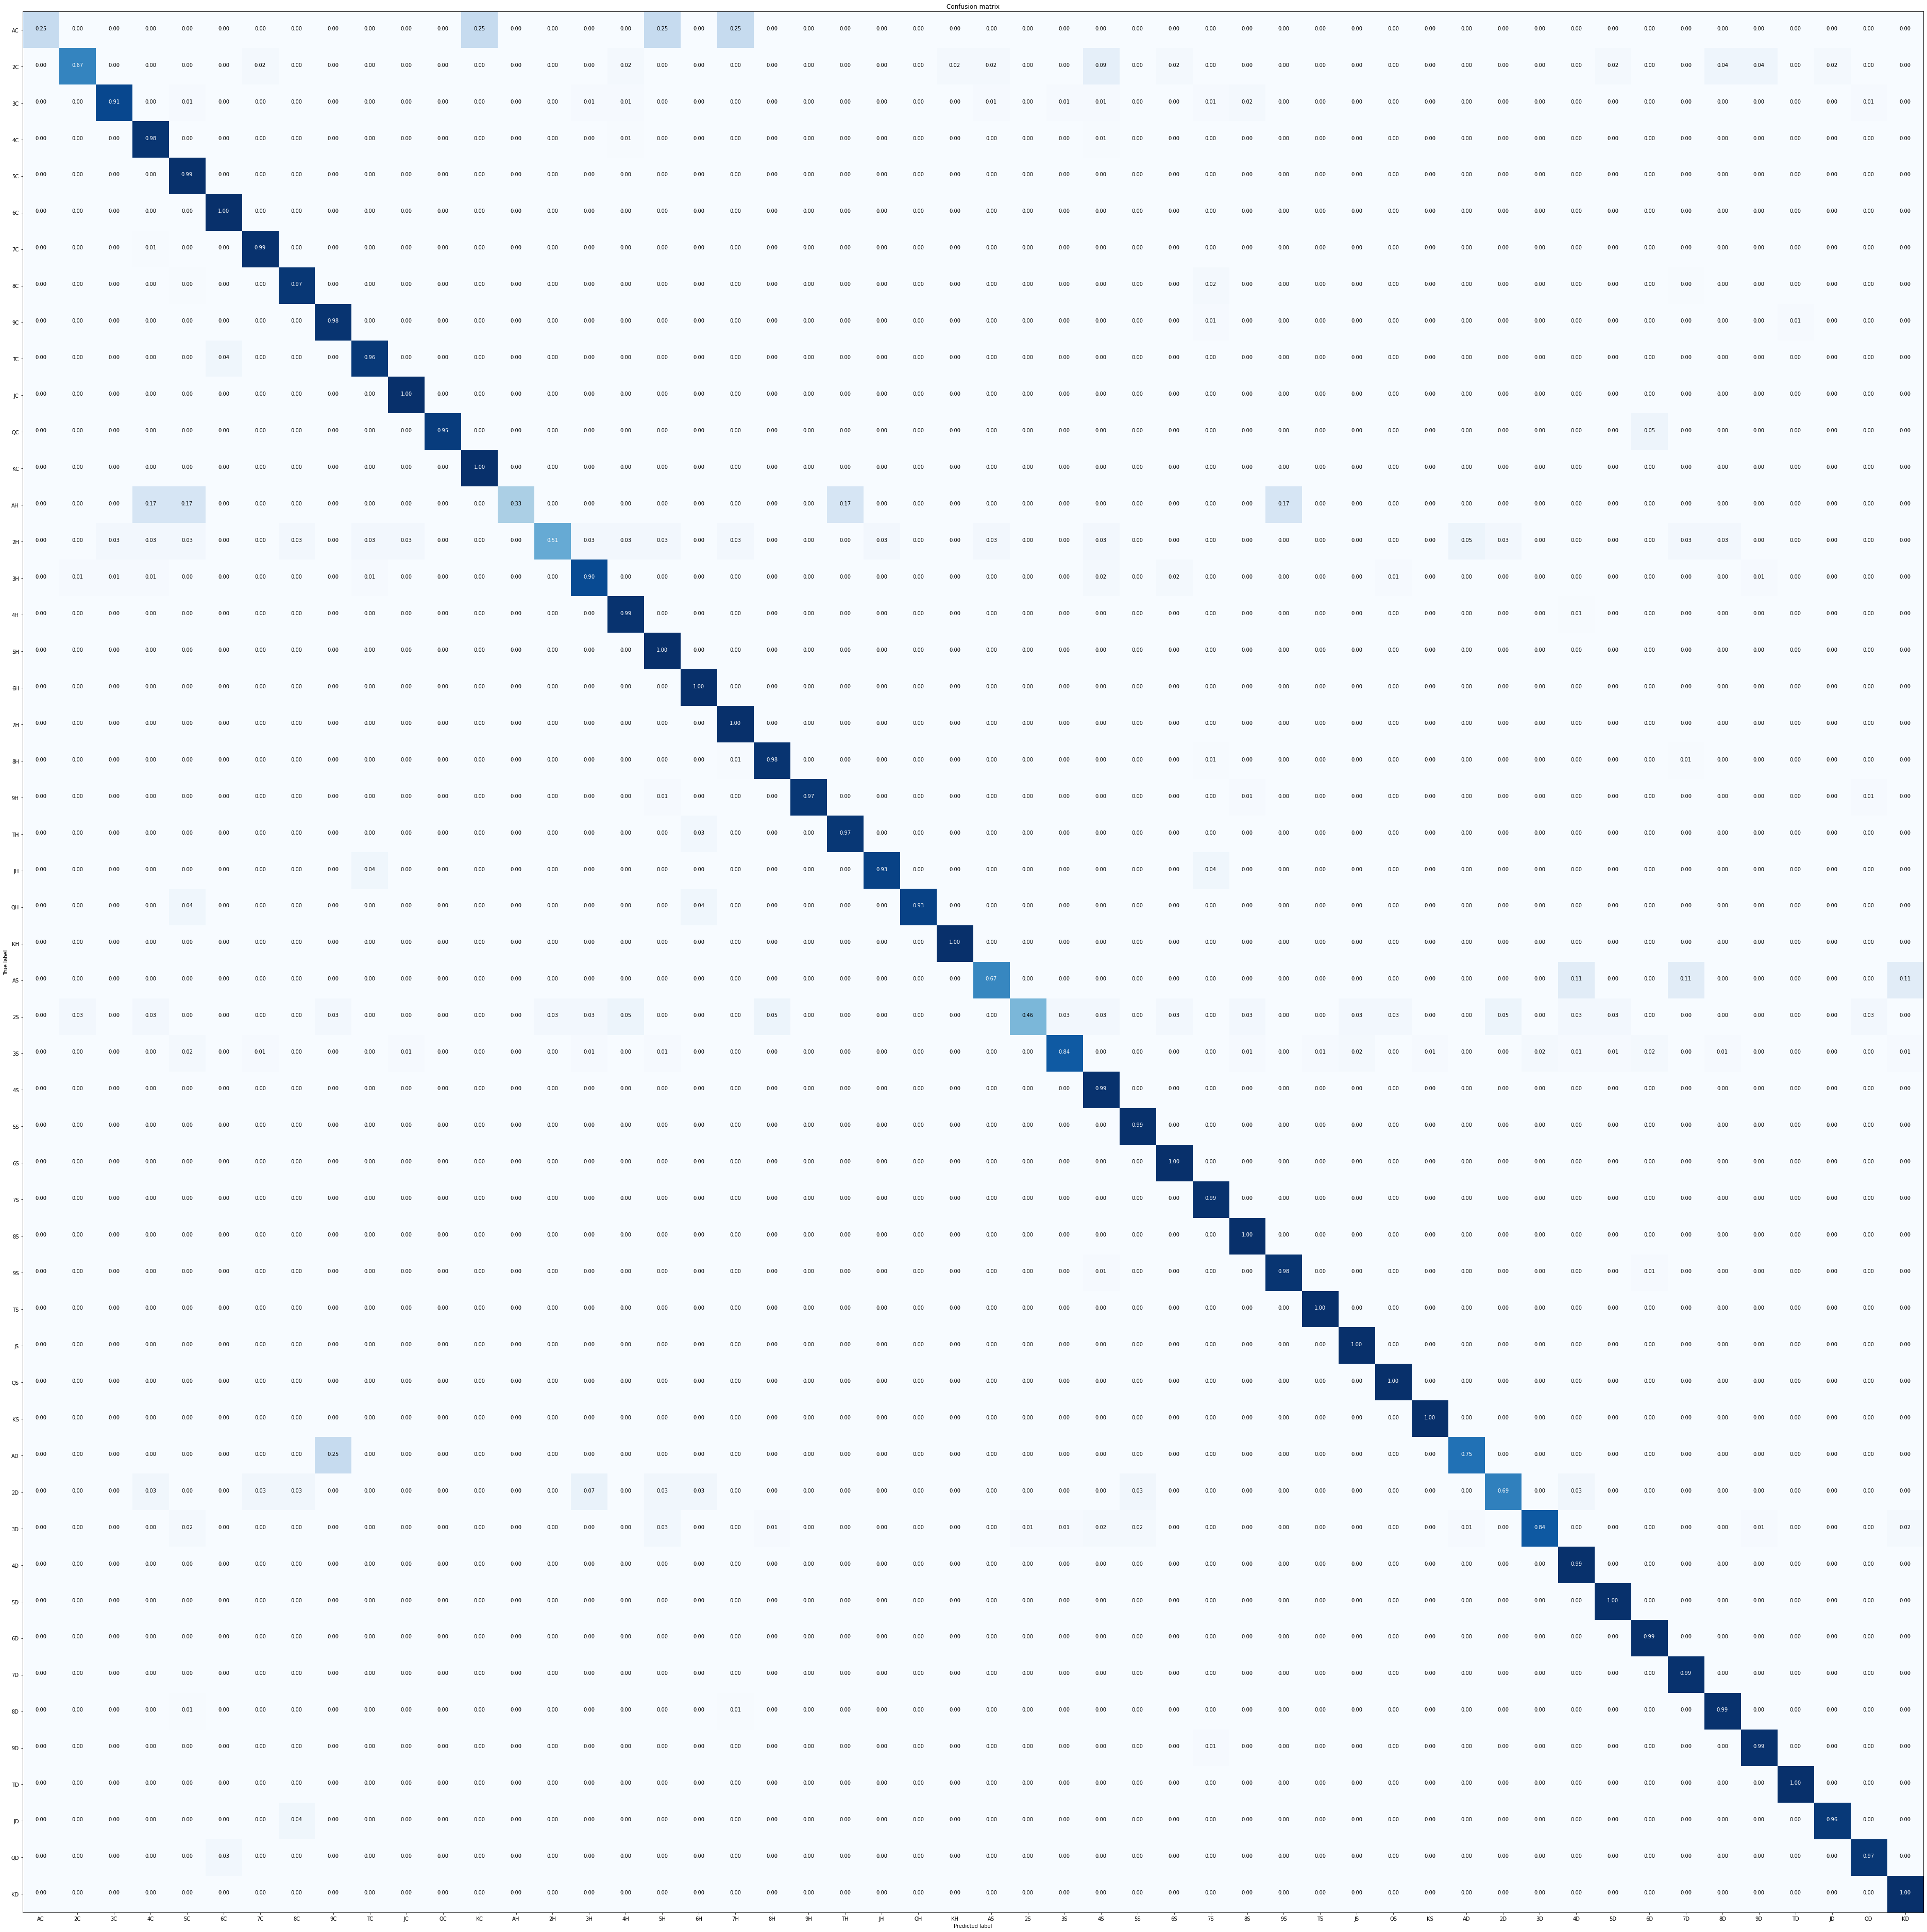

Confusion matrix, without normalization
[[  1   0   0 ...   0   0   0]
 [  0  31   0 ...   1   0   0]
 [  0   0 101 ...   0   1   0]
 ...
 [  0   0   0 ...  26   0   0]
 [  0   0   0 ...   0  33   0]
 [  0   0   0 ...   0   0  31]]


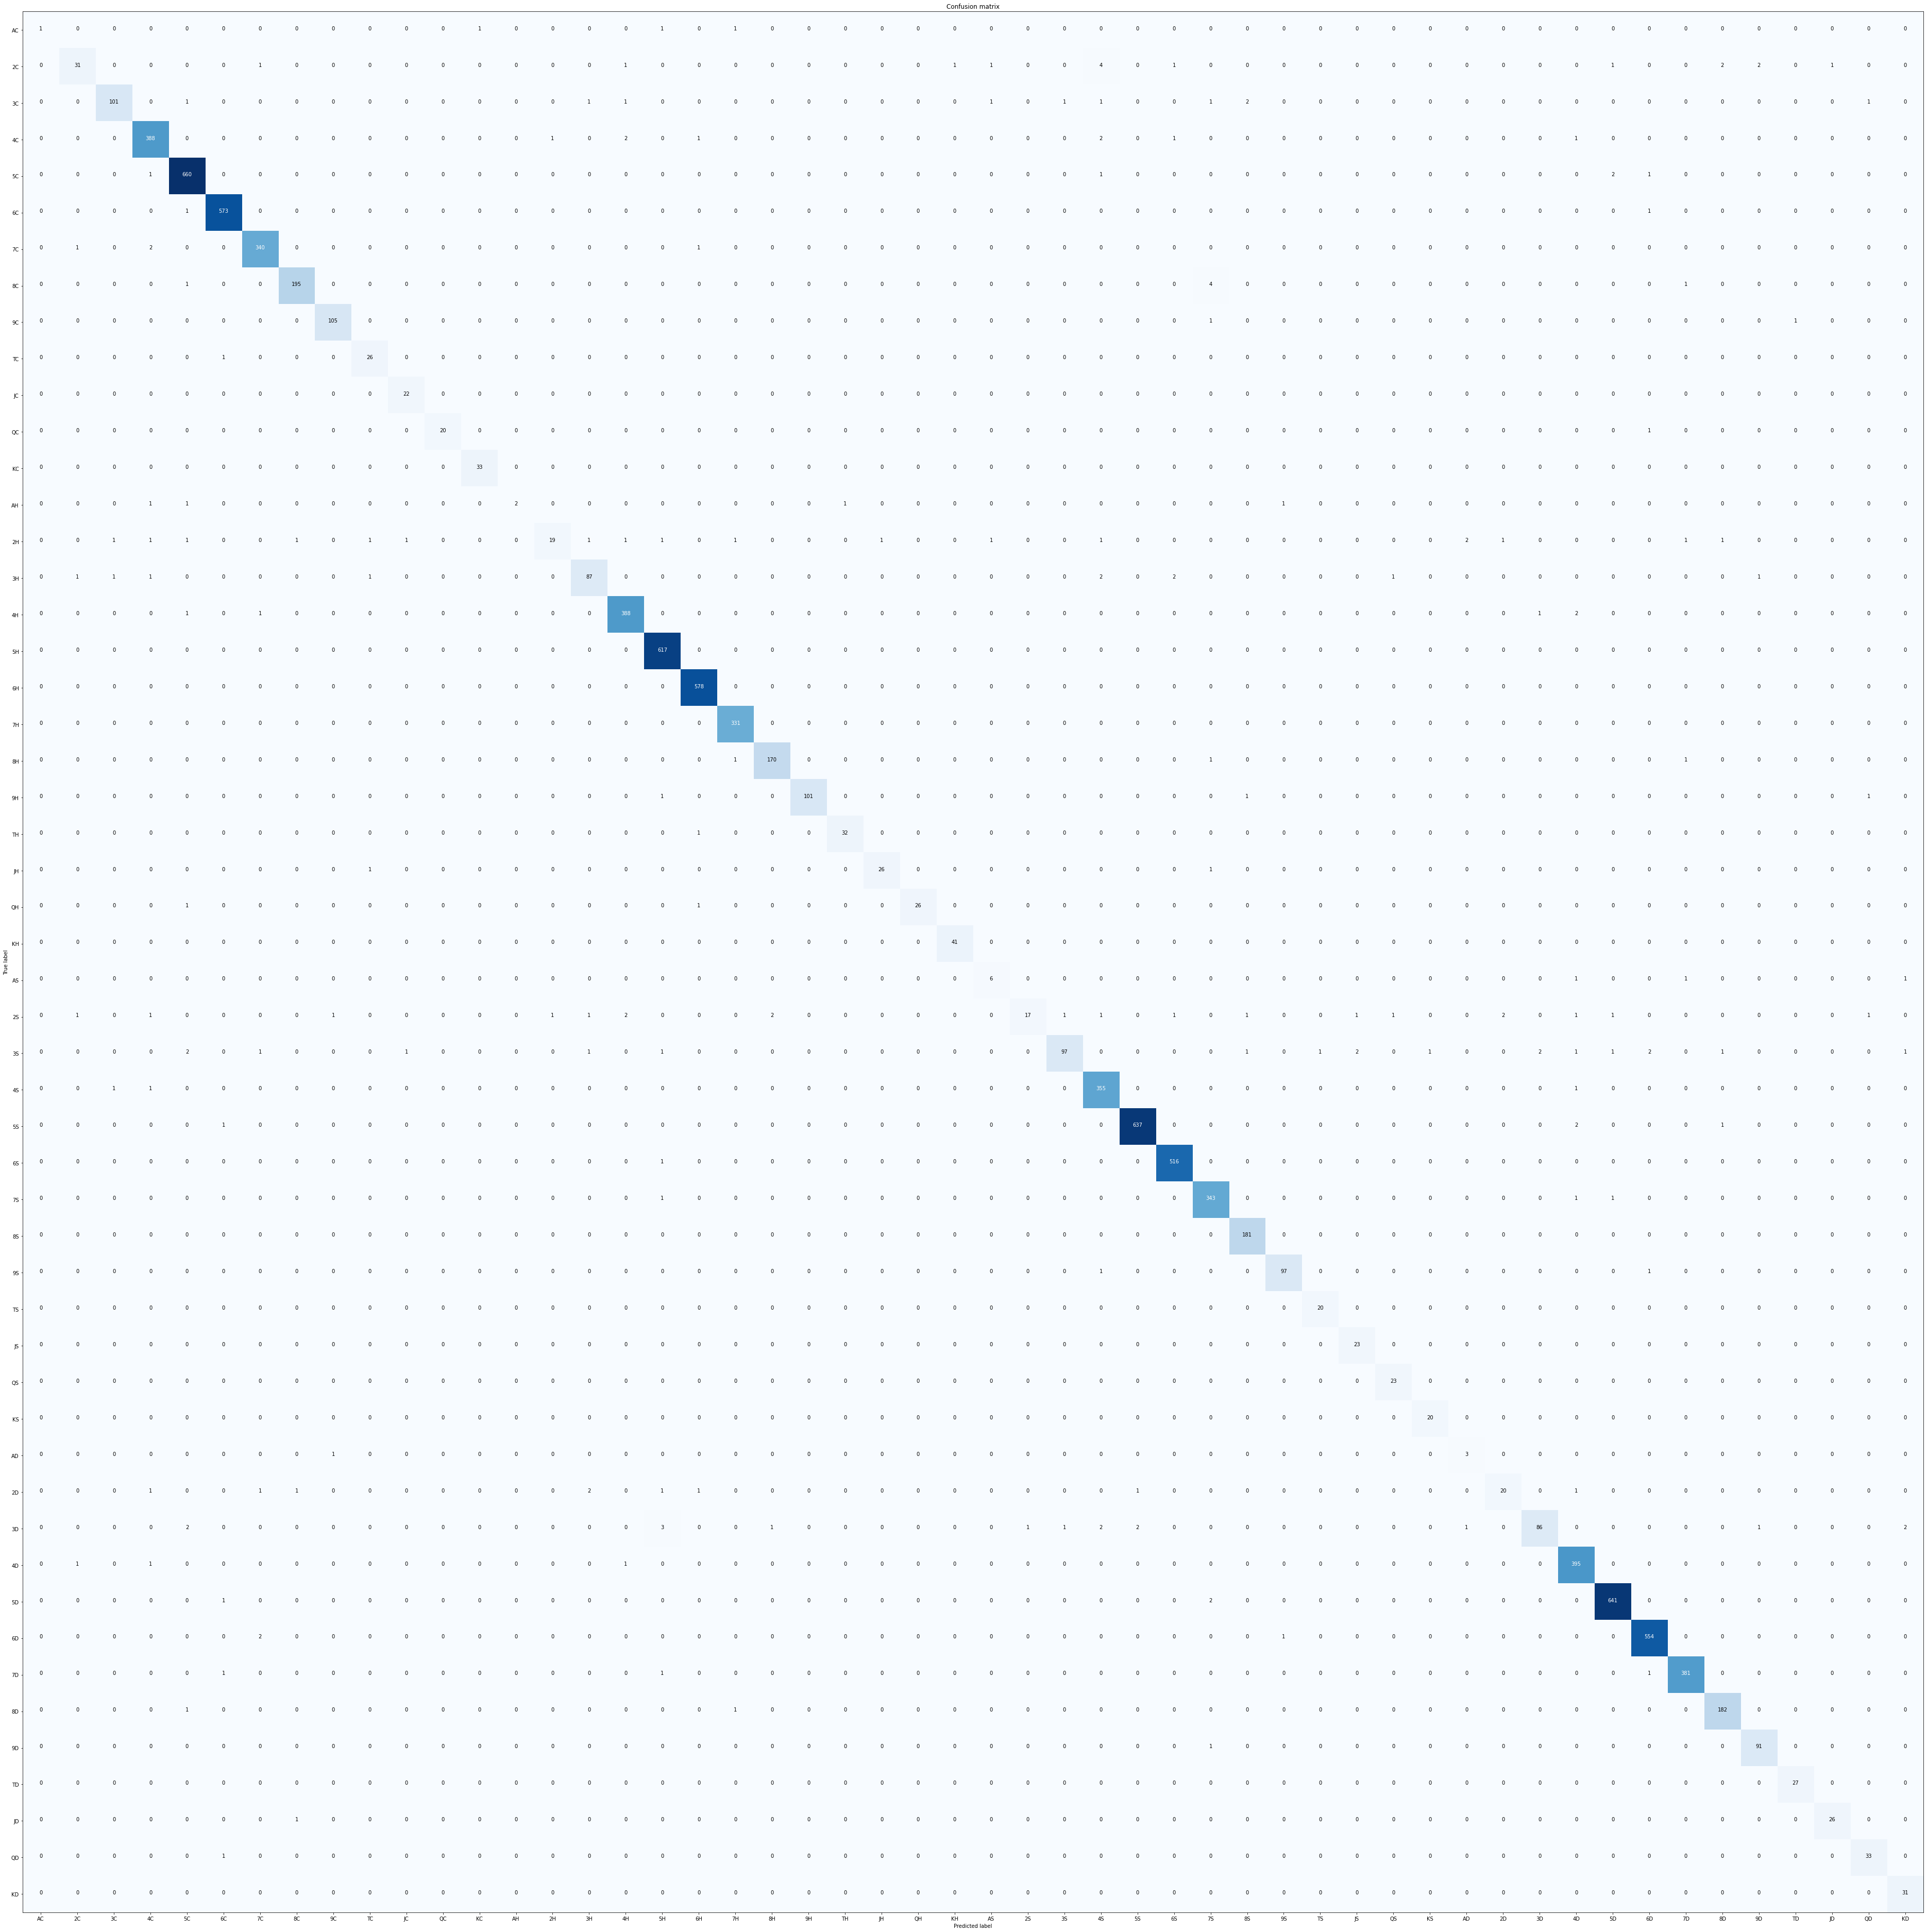

In [ ]:
model_loss, loss_fnc, _ = load_model(model=model_loss)
plot_cm(classes, model_loss, test_loader_2k, mode='loss')

## all_states_knock_only_PT

Specify the following parameters:

- Data Selection:
 - model_name
 - state-action pair
```r
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'}
```
 - numGames
 - pruneStatesList
 ```r
 {'currHand','topCard','deadCard','oppCard','unknownCard'}
 ```
 - actionChoice = 'all'
```r
{'all','draw_pickup','discard','knock'}
```

- Model Parameters:

| Parameter     | Type      |Default|
| ------------- |:---------:| -----:|
| batch_size    | int       | 1000  |
| learning_rate | float     | 0.001 |
| epoch         | int       | 100   |
| pre_train     | bool (T/F)| False |
| model_PT      | str (path)| null  |

In [ ]:
# model name
model_name = 'all_states_knock_only_PT'

# state_action pair, and dataset selection
state = 'apbd'
action = 'knock'
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'knock'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 300

# Pretrain model
pre_train = True
model_PT = '/content/drive/MyDrive/Colab Notebooks/Thesis/models/apad/knock_bin/all_states_all_actions/model.pt'

### Directories

In [ ]:
# create model and plot directories if do not exist

# model directories
state_pth = '{}/models/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
model_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(model_pth):
    os.mkdir(model_pth)

# plot directories
state_pth = '{}/plots/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
plot_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(plot_pth):
    os.mkdir(plot_pth)

# data directory
data_pth = '{}/data/{}/{}'.format(pth,state,action)

### Load, Prune, Split Data

In [ ]:
if action in state_action_pair[state]:
    states = np.load('{}/s_{}k.npy'.format(data_pth,numGames//1000))
    actions = np.load('{}/a_{}k.npy'.format(data_pth,numGames//1000))

    # prune states
    states = pruneStates(states, pruneStatesList)

    # choosable actions
    actions, classes = chooseActions(actions, all_classes, actionChoice)

    # balance classes
    if balance:
        states,actions = balanceClasses(states,actions)

    # split train/val
    data_train, data_val, label_train, label_val = train_test_split(states, actions, test_size=0.3, random_state=421)
else:
    print('illegeal state-action pair')

In [ ]:
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

### Train Model

Epoch: 1 | Train Loss: 0.07663554 | Train acc: 0.033719
              Val Loss: 0.01976858 |   Val acc: 0.058651
Epoch: 2 | Train Loss: 0.01896071 | Train acc: 0.093364
              Val Loss: 0.01869671 |   Val acc: 0.127775
Epoch: 3 | Train Loss: 0.01863063 | Train acc: 0.140944
              Val Loss: 0.01854273 |   Val acc: 0.157269
Epoch: 4 | Train Loss: 0.01846160 | Train acc: 0.167409
              Val Loss: 0.01835544 |   Val acc: 0.180059
Epoch: 5 | Train Loss: 0.01825725 | Train acc: 0.203713
              Val Loss: 0.01813208 |   Val acc: 0.230080
Epoch: 6 | Train Loss: 0.01800654 | Train acc: 0.267955
              Val Loss: 0.01784713 |   Val acc: 0.300209
Epoch: 7 | Train Loss: 0.01766993 | Train acc: 0.320310
              Val Loss: 0.01745465 |   Val acc: 0.341098
Epoch: 8 | Train Loss: 0.01721487 | Train acc: 0.354963
              Val Loss: 0.01695107 |   Val acc: 0.367658
Epoch: 9 | Train Loss: 0.01665987 | Train acc: 0.380961
              Val Loss: 0.01633833 |   V

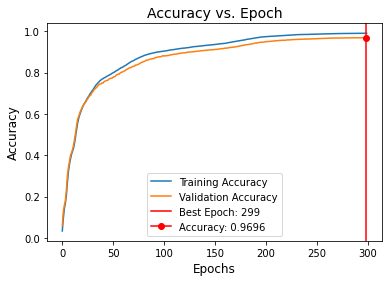

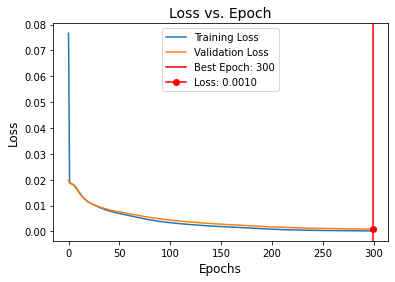

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True, pre_train=pre_train, model_PT=model_PT)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

In [ ]:
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

##### Train Set

Accuracy: 99.09
Normalized confusion matrix
[[0.46153811 0.         0.         ... 0.         0.         0.        ]
 [0.         0.86486481 0.00675676 ... 0.         0.         0.        ]
 [0.         0.         0.95723681 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999987 0.         0.        ]
 [0.         0.         0.01111111 ... 0.         0.97777767 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999988]]


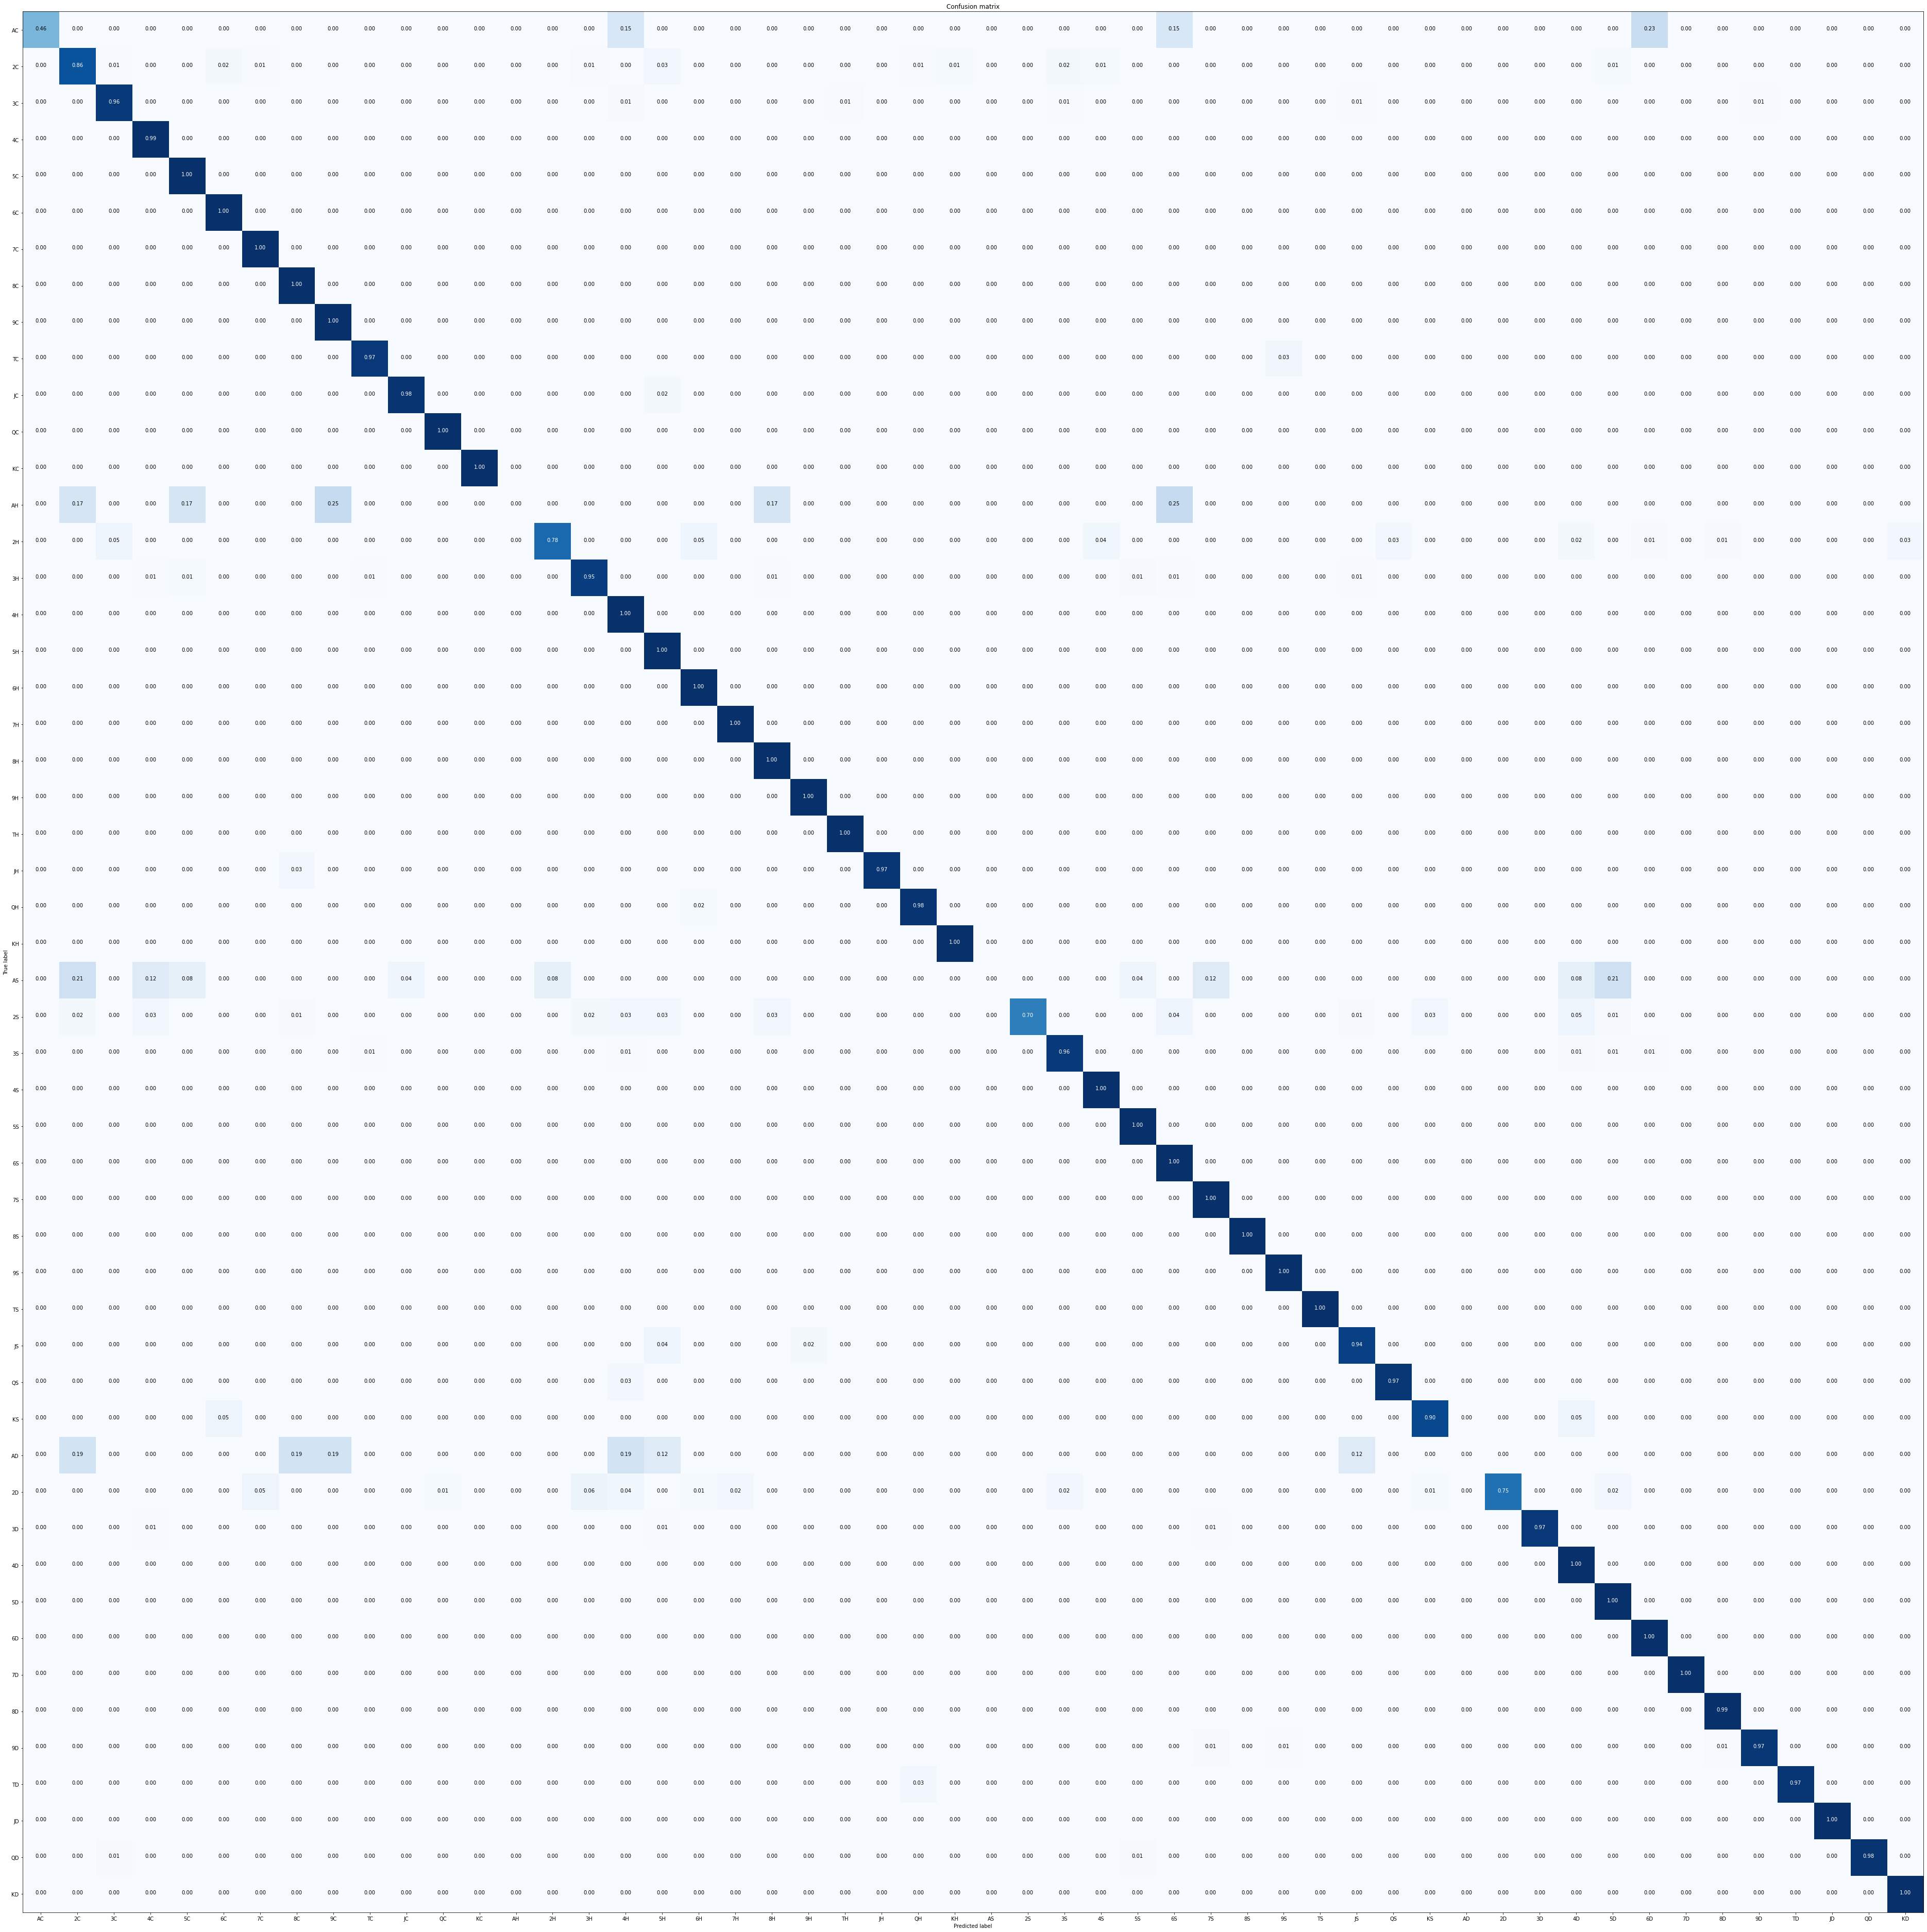

Confusion matrix, without normalization
[[  6   0   0 ...   0   0   0]
 [  0 128   1 ...   0   0   0]
 [  0   0 291 ...   0   0   0]
 ...
 [  0   0   0 ...  76   0   0]
 [  0   0   1 ...   0  88   0]
 [  0   0   0 ...   0   0  84]]


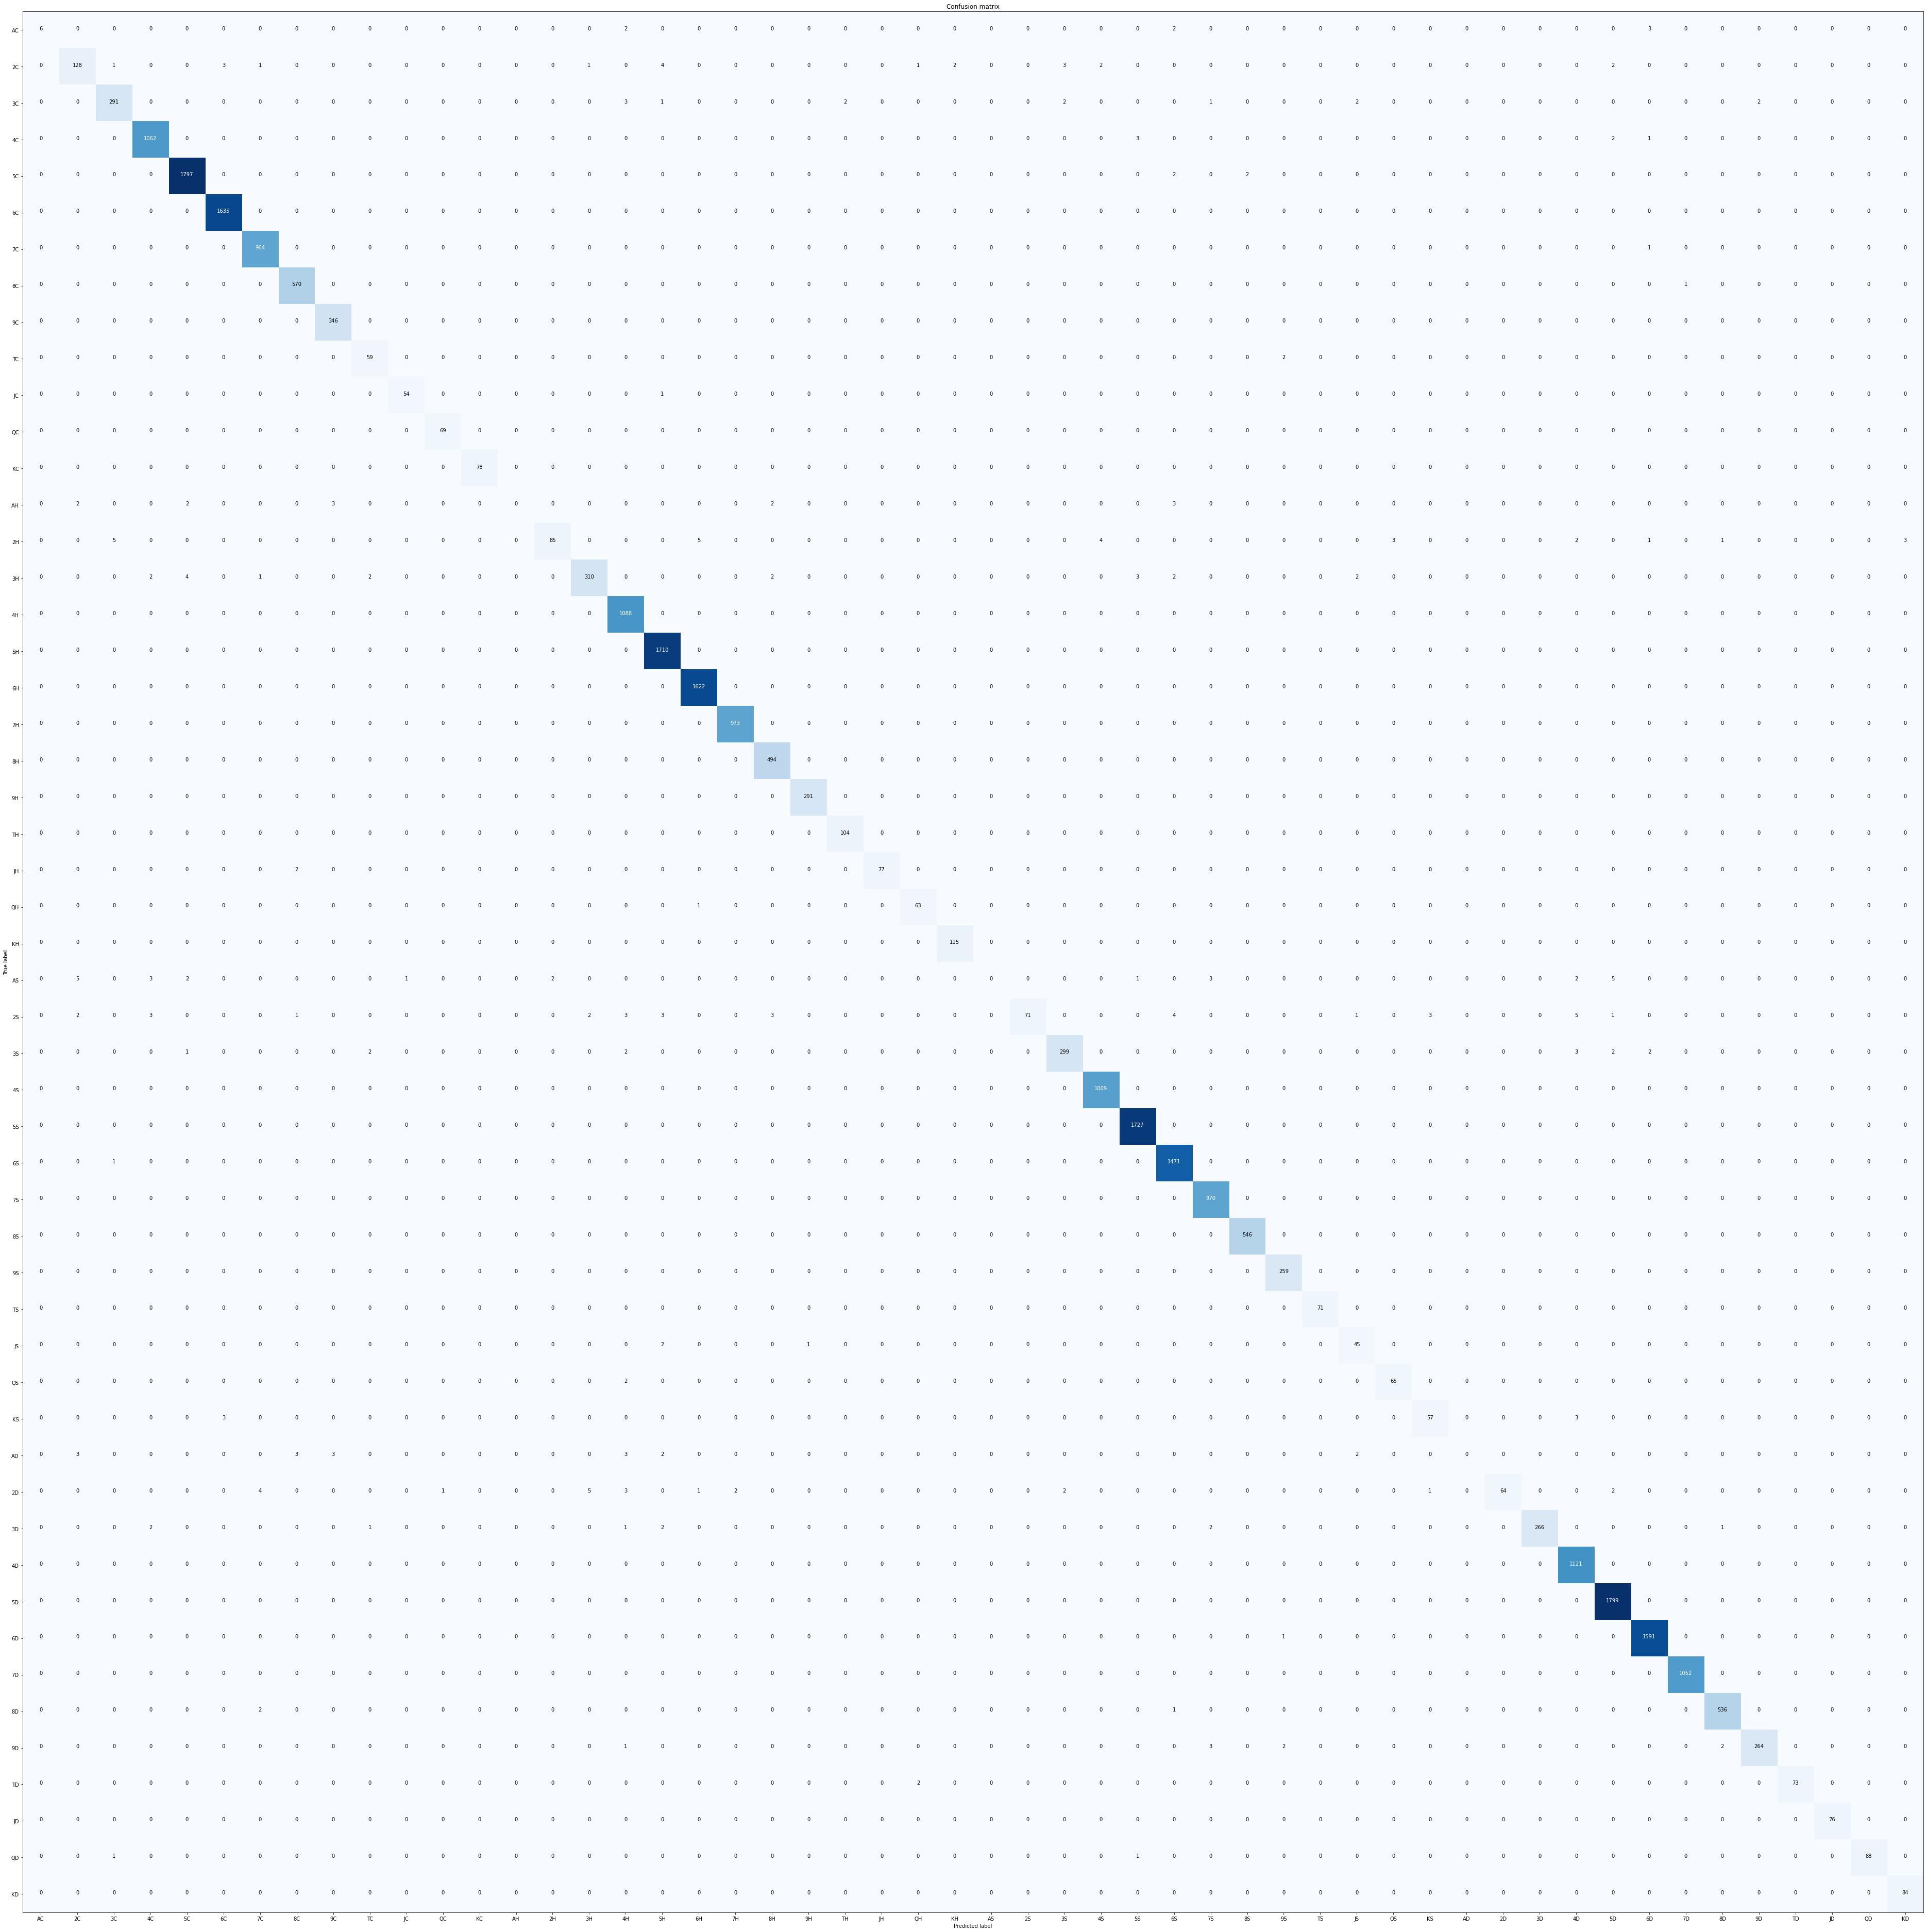

In [ ]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, train_loader)

##### Validation Set

Accuracy: 96.91
Normalized confusion matrix
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.71999986 0.03999999 ... 0.         0.         0.        ]
 [0.         0.         0.85401454 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999973 0.         0.        ]
 [0.         0.         0.05714284 ... 0.         0.79999977 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999978]]


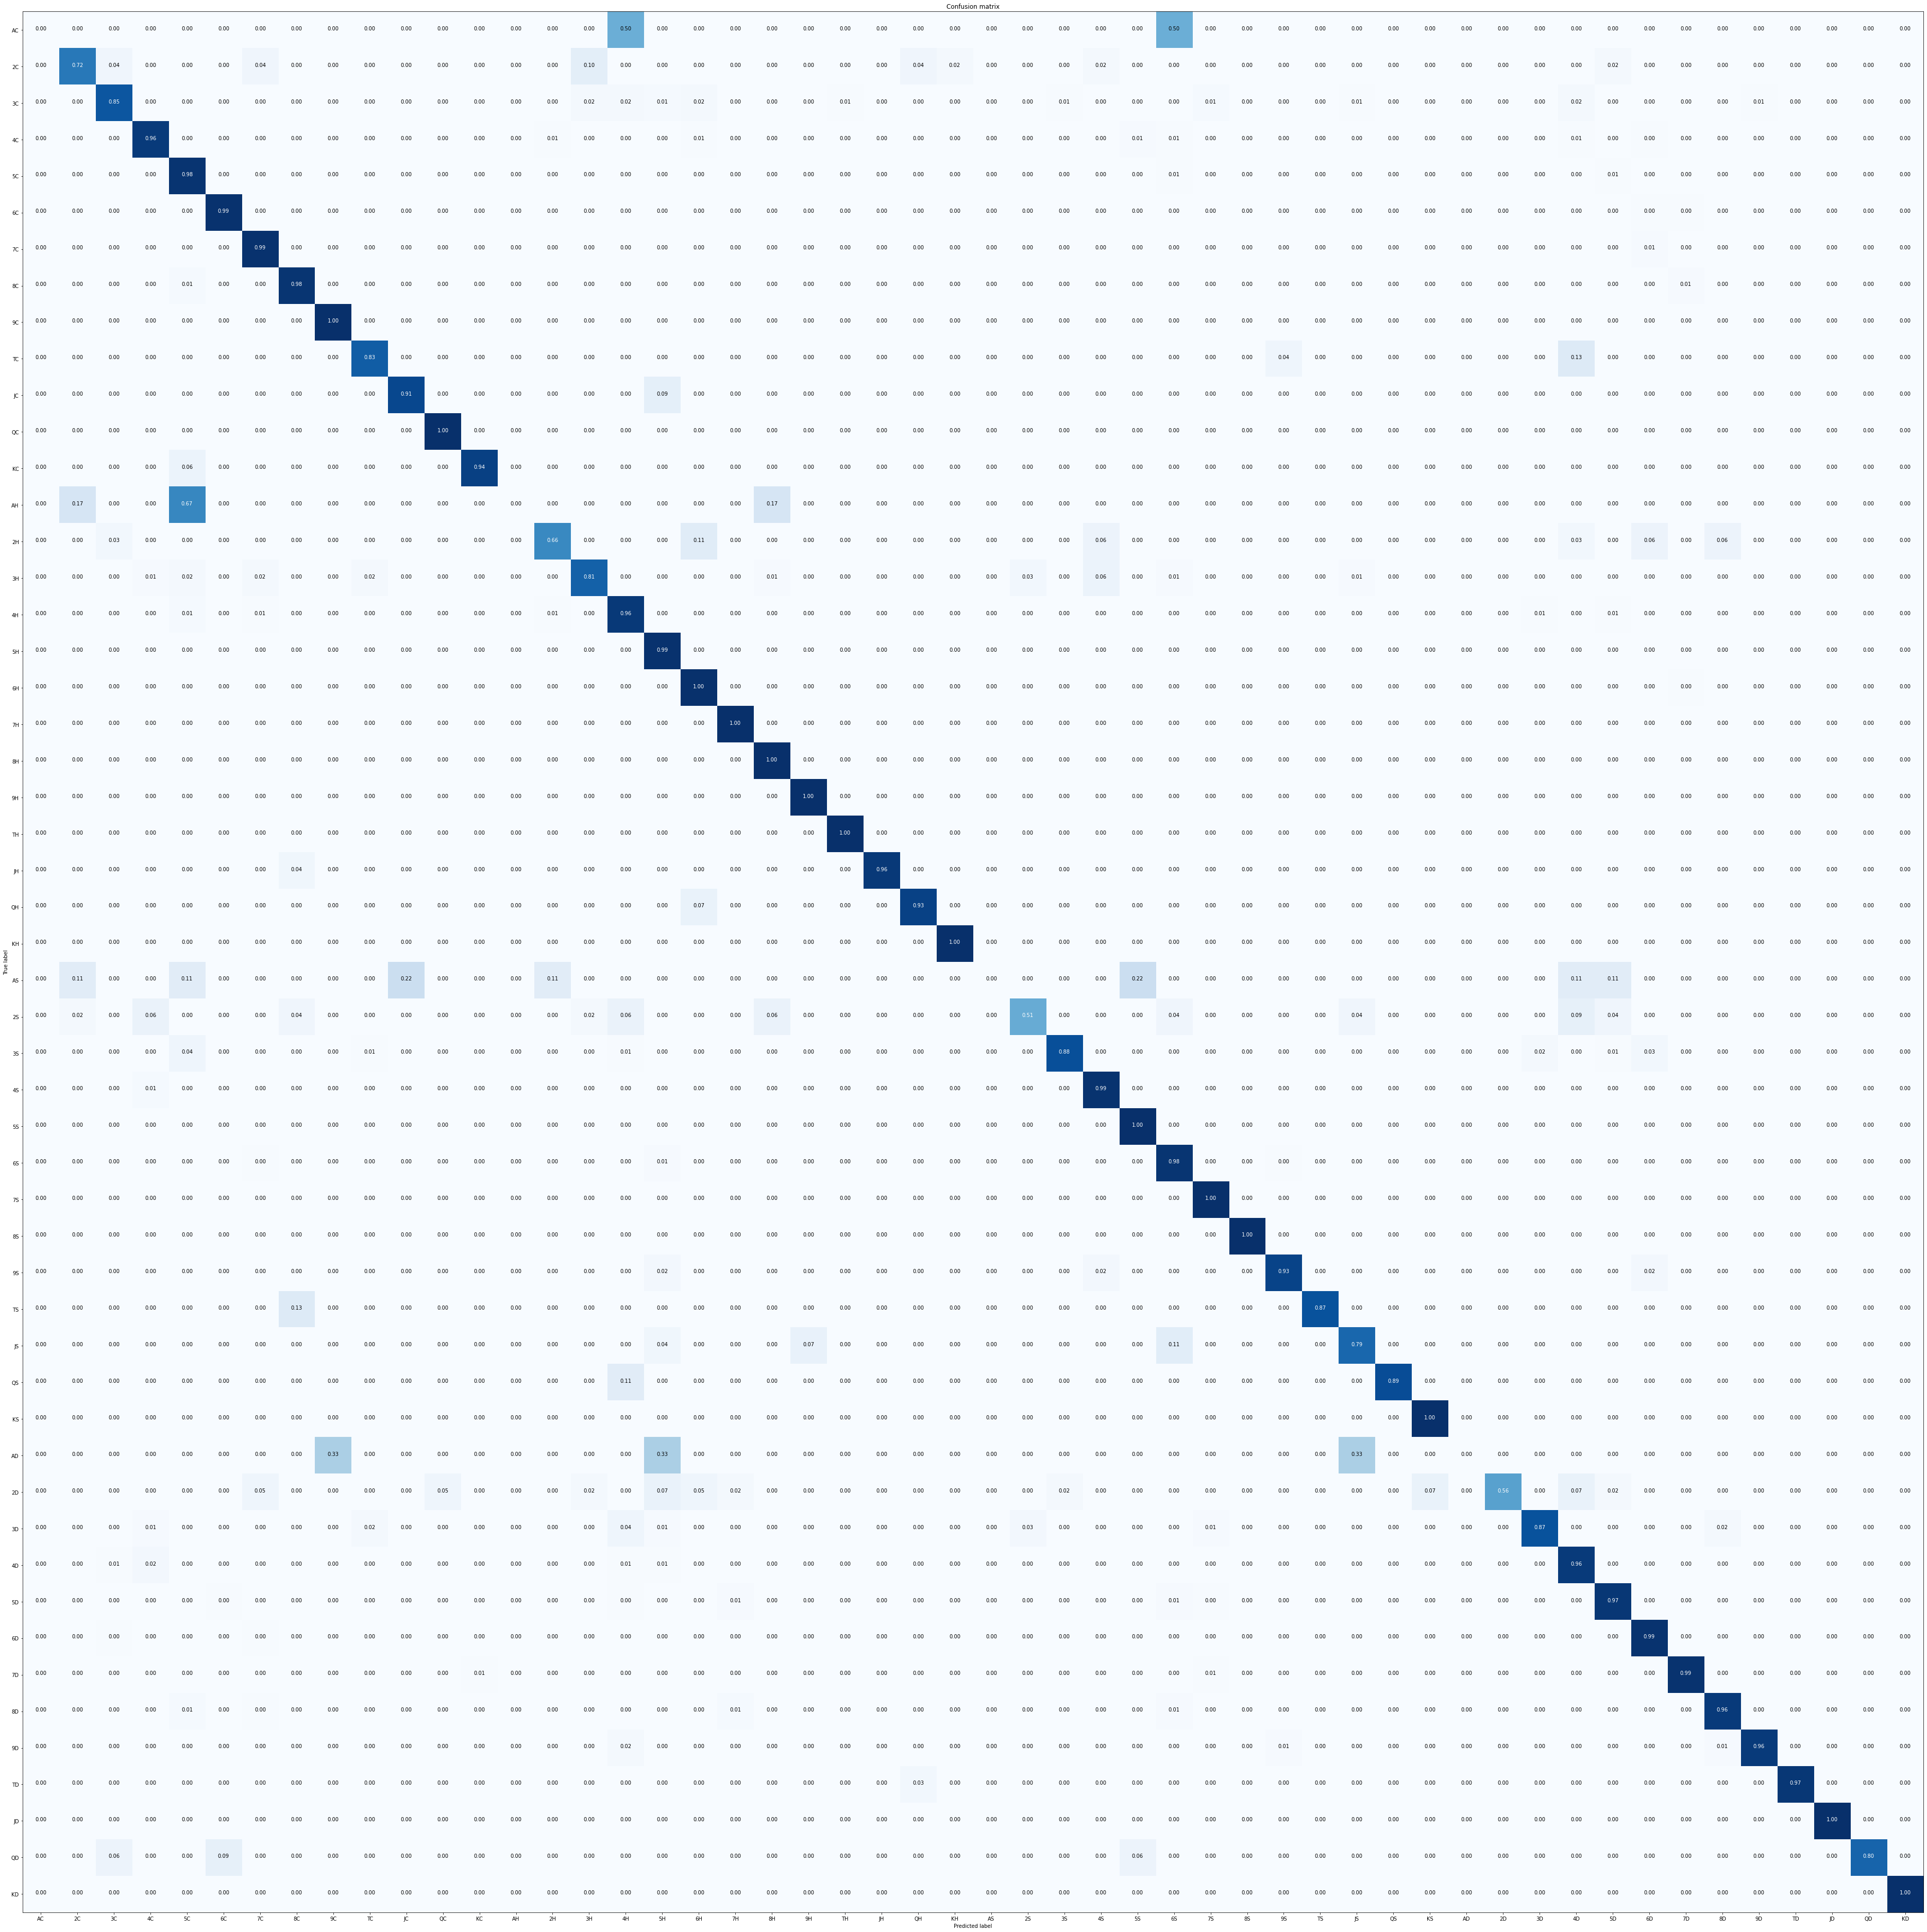

Confusion matrix, without normalization
[[  0   0   0 ...   0   0   0]
 [  0  36   2 ...   0   0   0]
 [  0   0 117 ...   0   0   0]
 ...
 [  0   0   0 ...  37   0   0]
 [  0   0   2 ...   0  28   0]
 [  0   0   0 ...   0   0  46]]


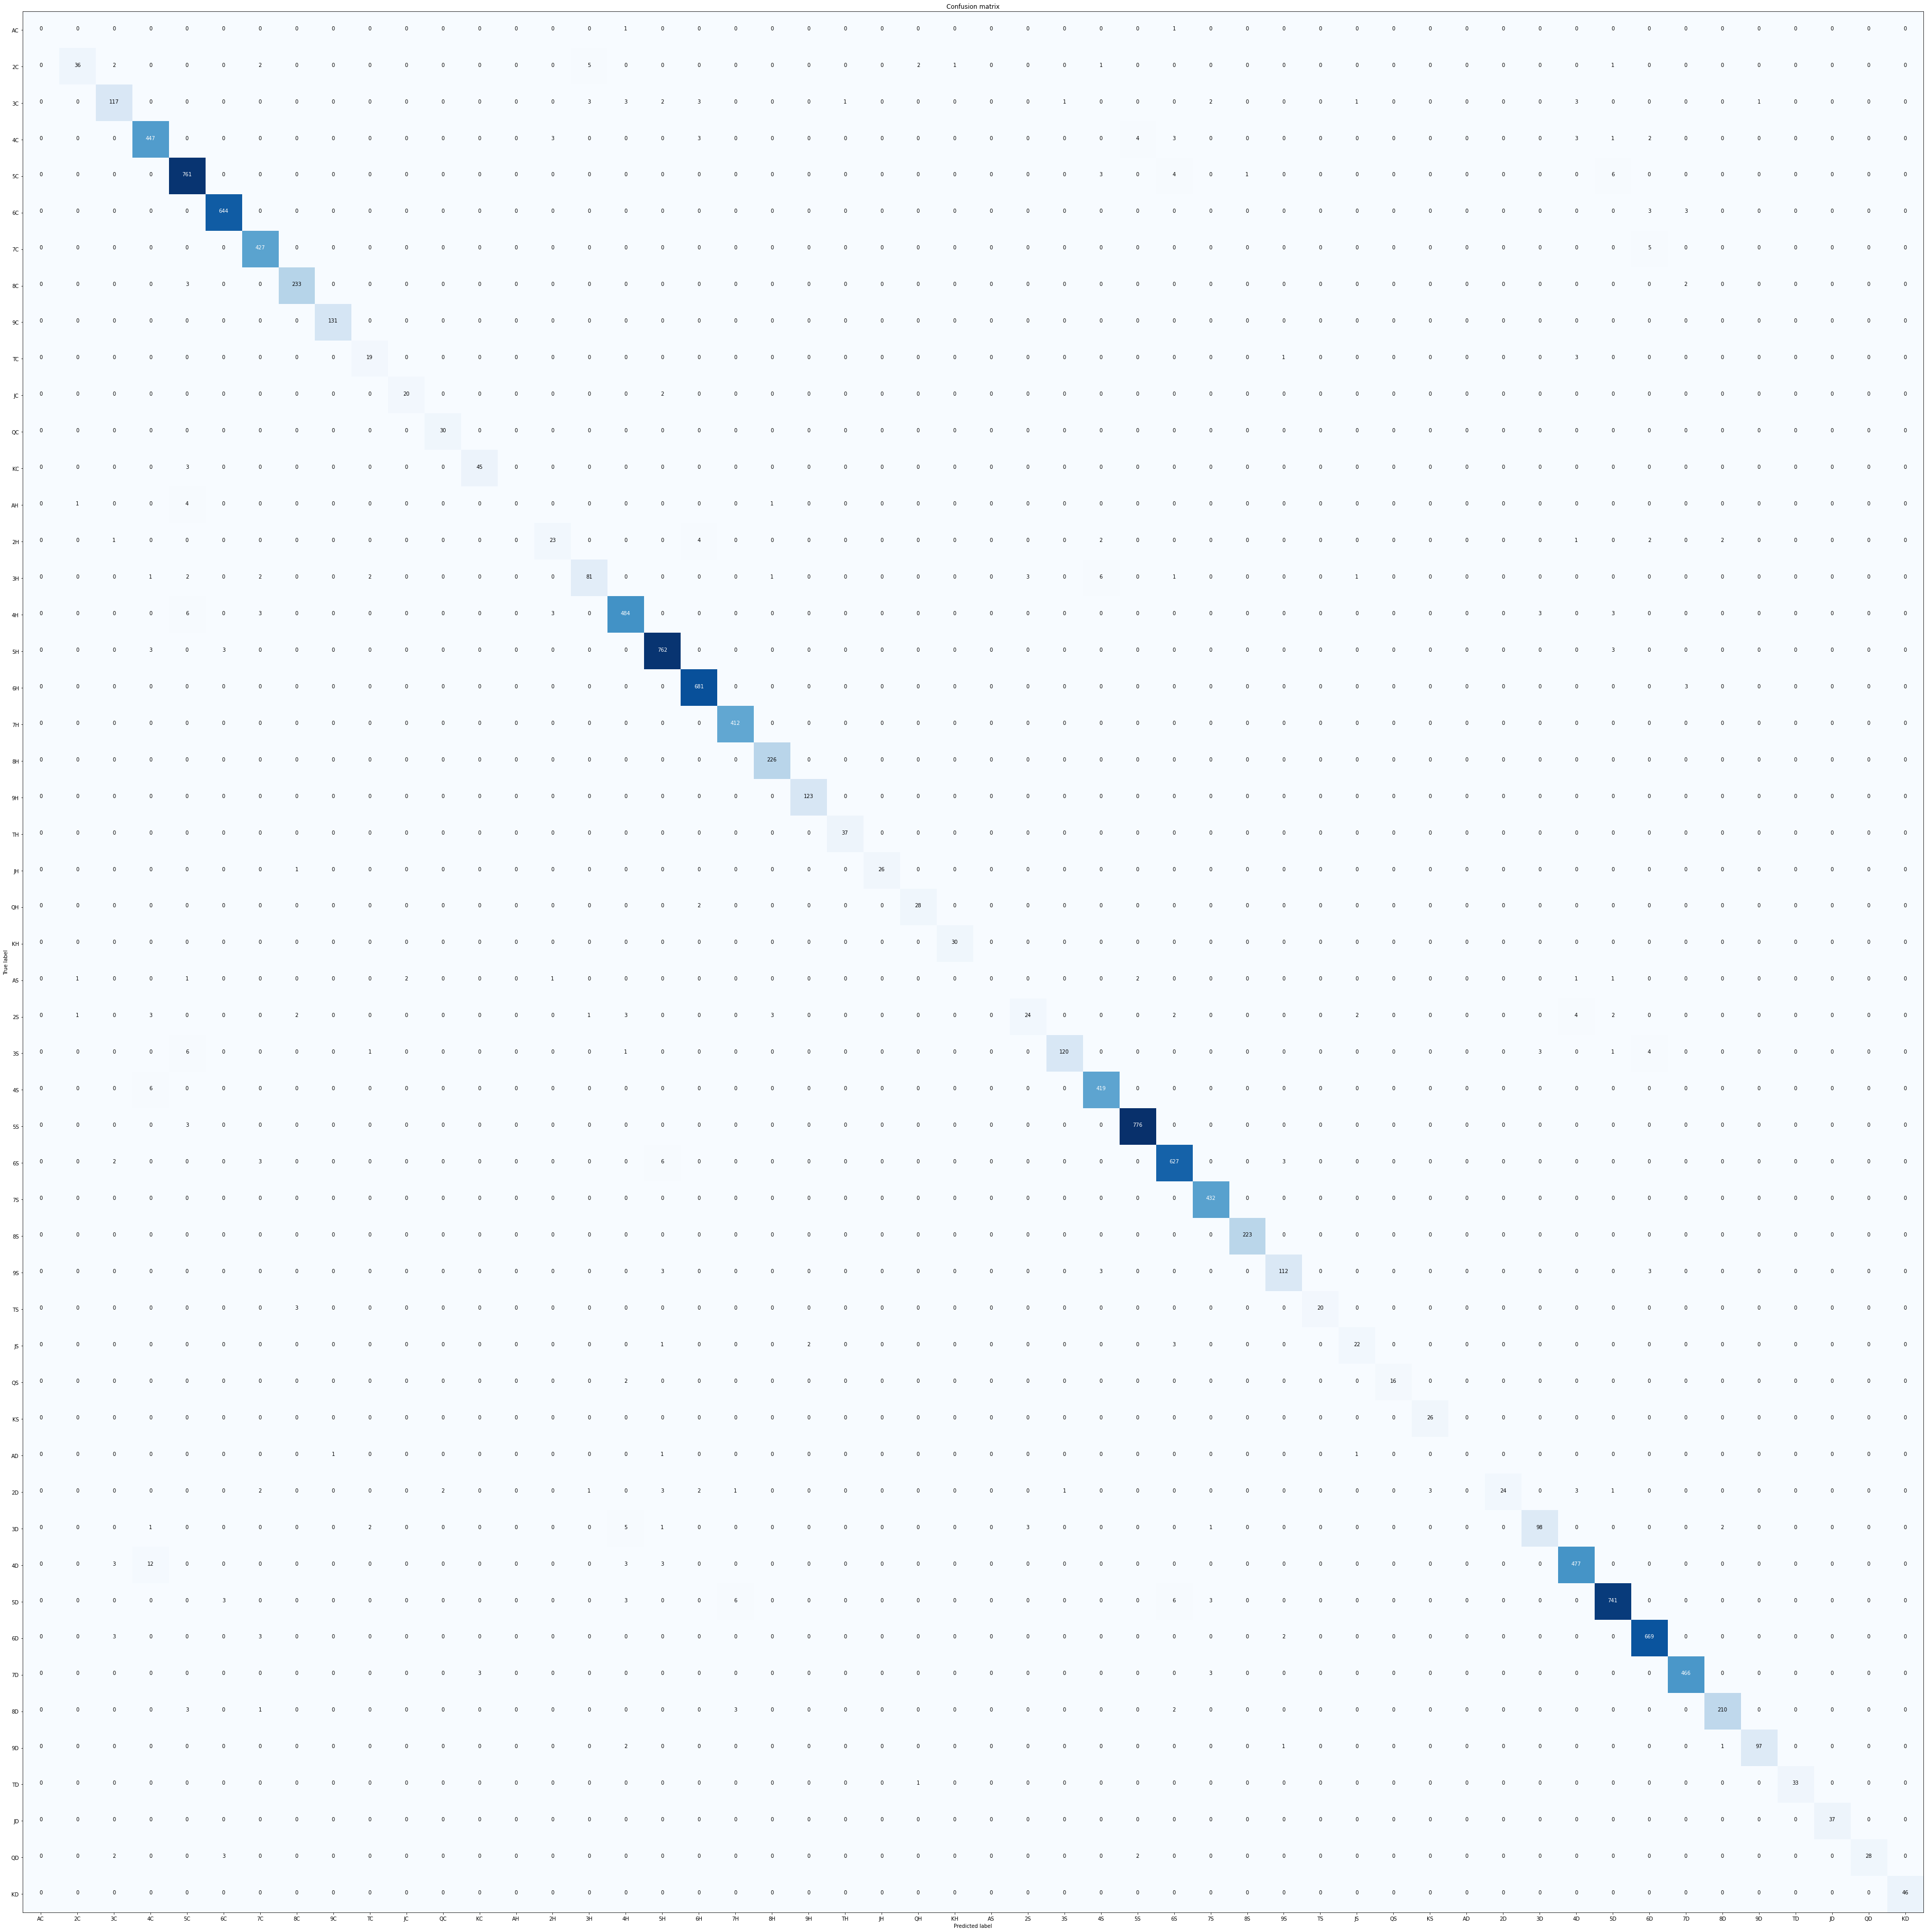

In [ ]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, val_loader)

##### Test Set (6k)

Accuracy: 98.44
Normalized confusion matrix
[[0.39999973 0.         0.         ... 0.         0.         0.        ]
 [0.         0.82828279 0.01515151 ... 0.         0.         0.        ]
 [0.         0.         0.92517005 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999991 0.         0.        ]
 [0.         0.         0.024      ... 0.         0.92799993 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999992]]


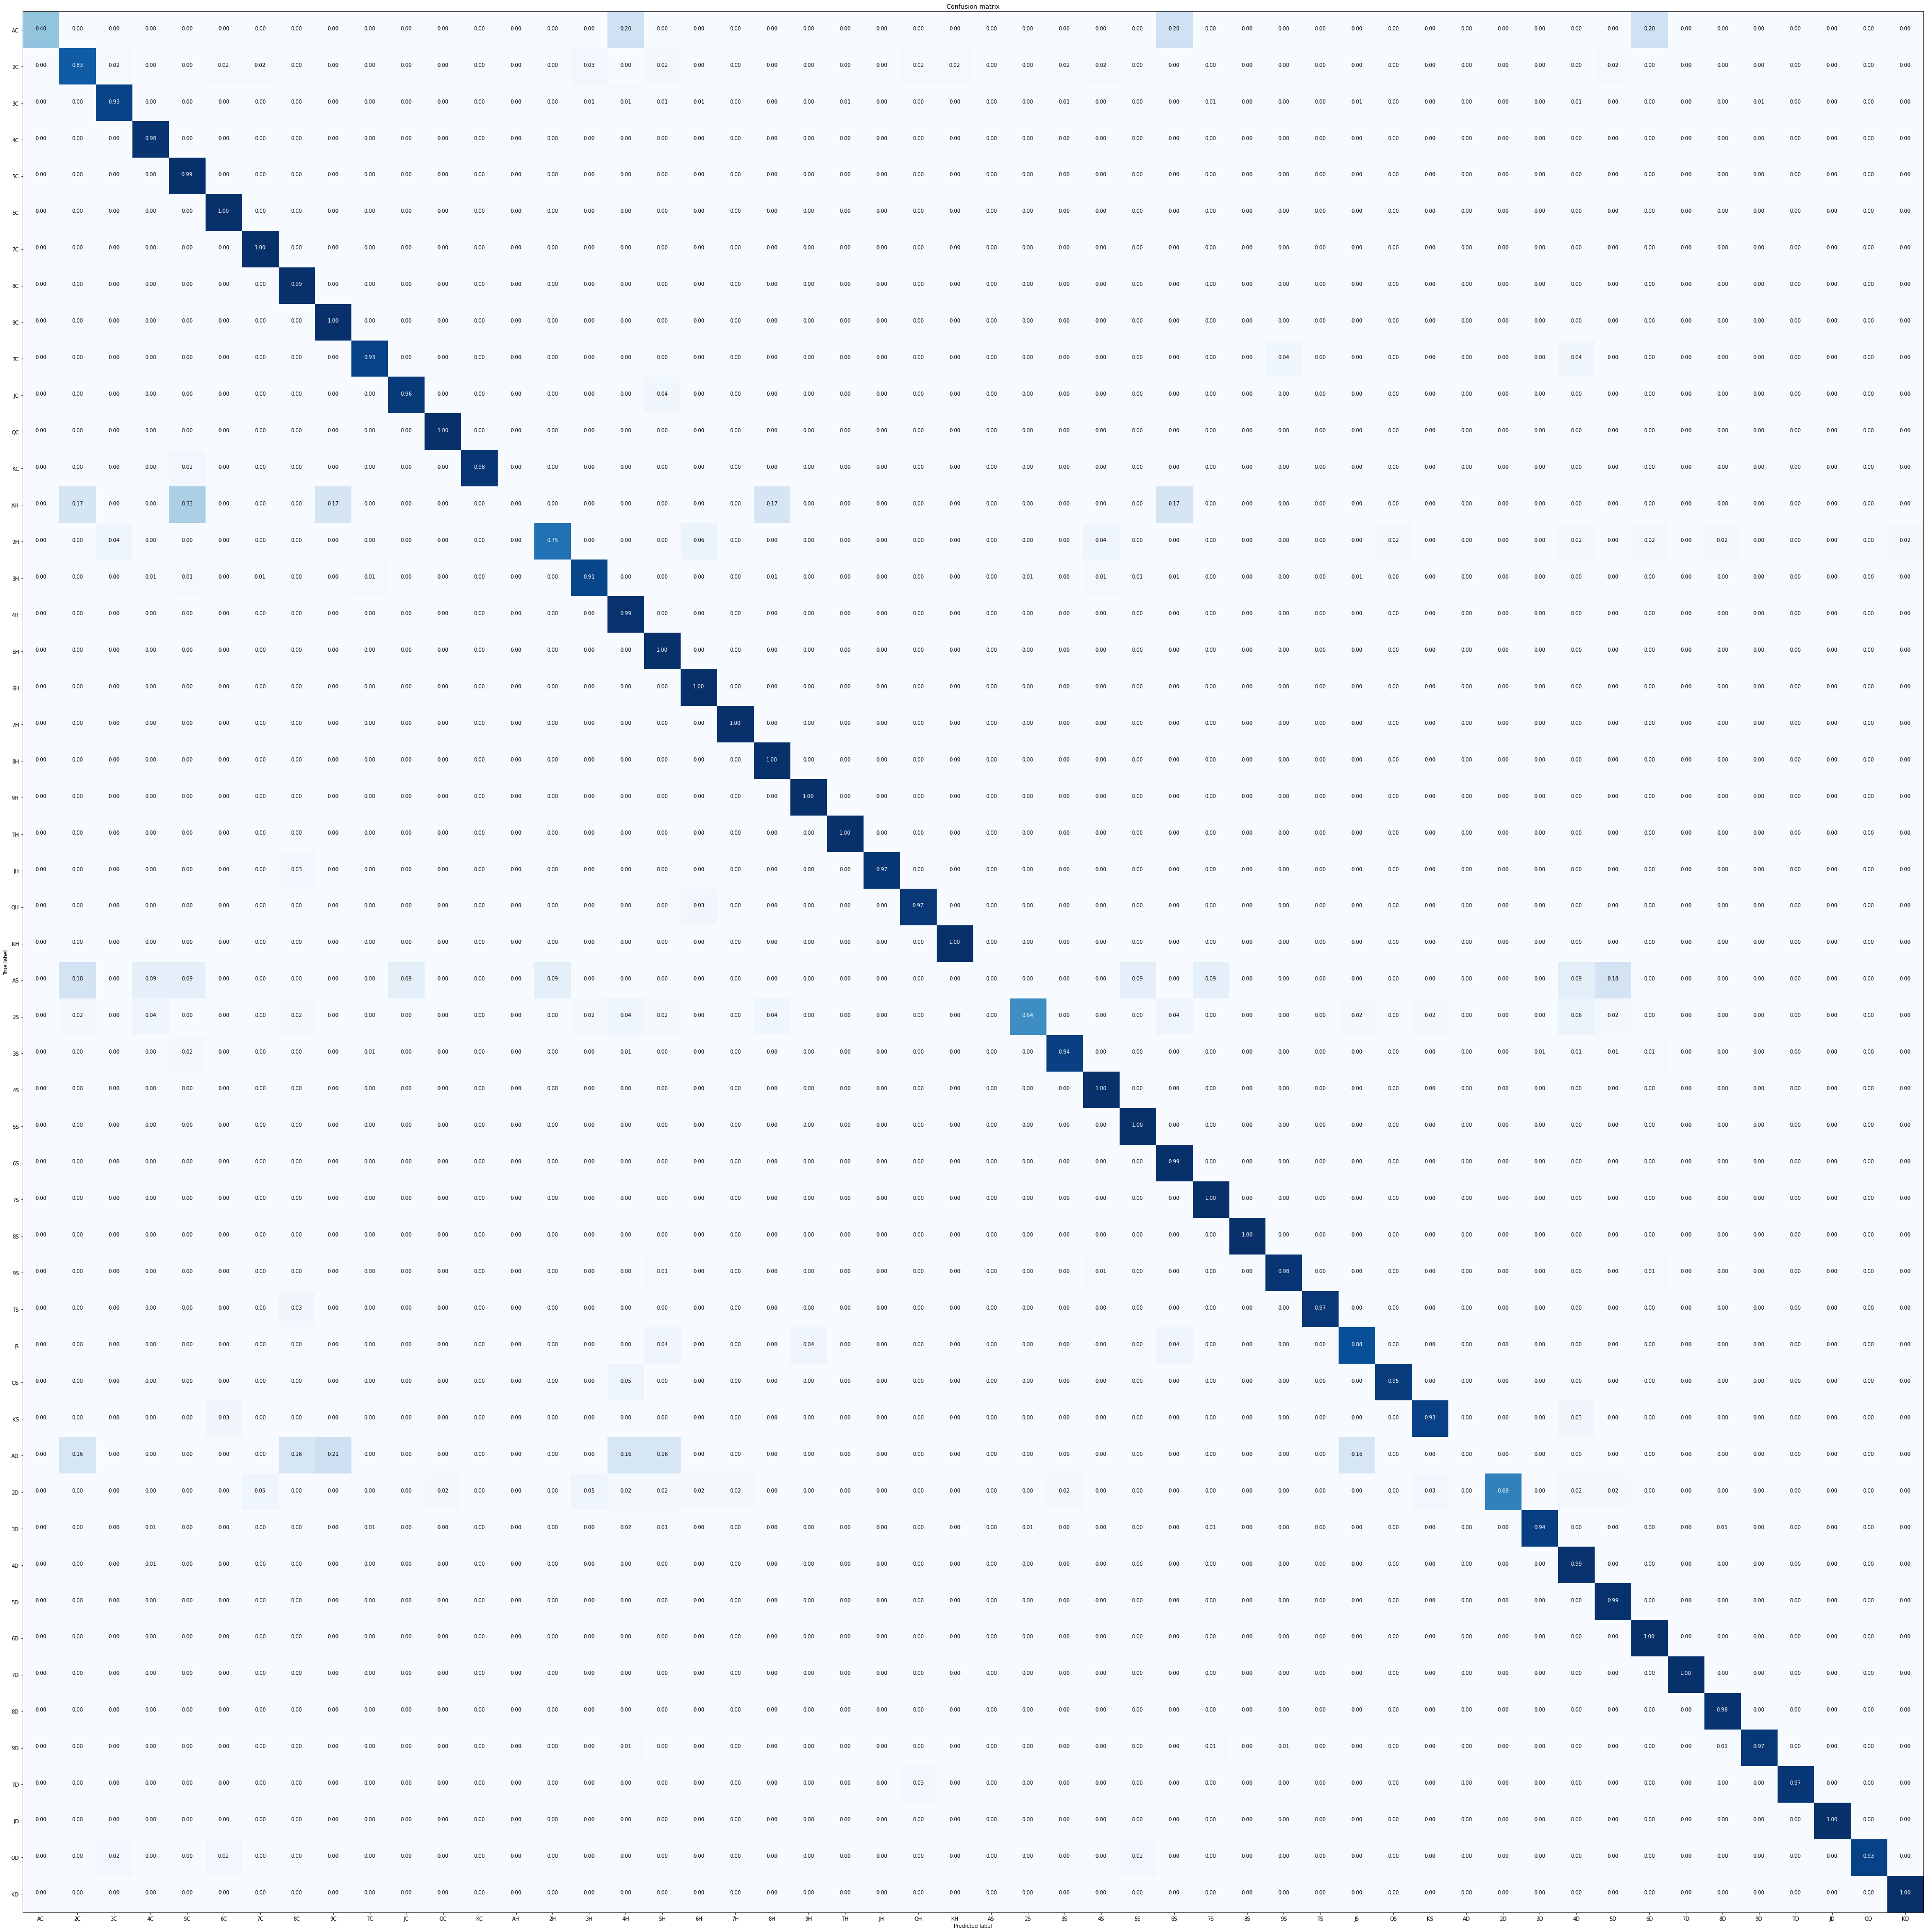

Confusion matrix, without normalization
[[  6   0   0 ...   0   0   0]
 [  0 164   3 ...   0   0   0]
 [  0   0 408 ...   0   0   0]
 ...
 [  0   0   0 ... 113   0   0]
 [  0   0   3 ...   0 116   0]
 [  0   0   0 ...   0   0 130]]


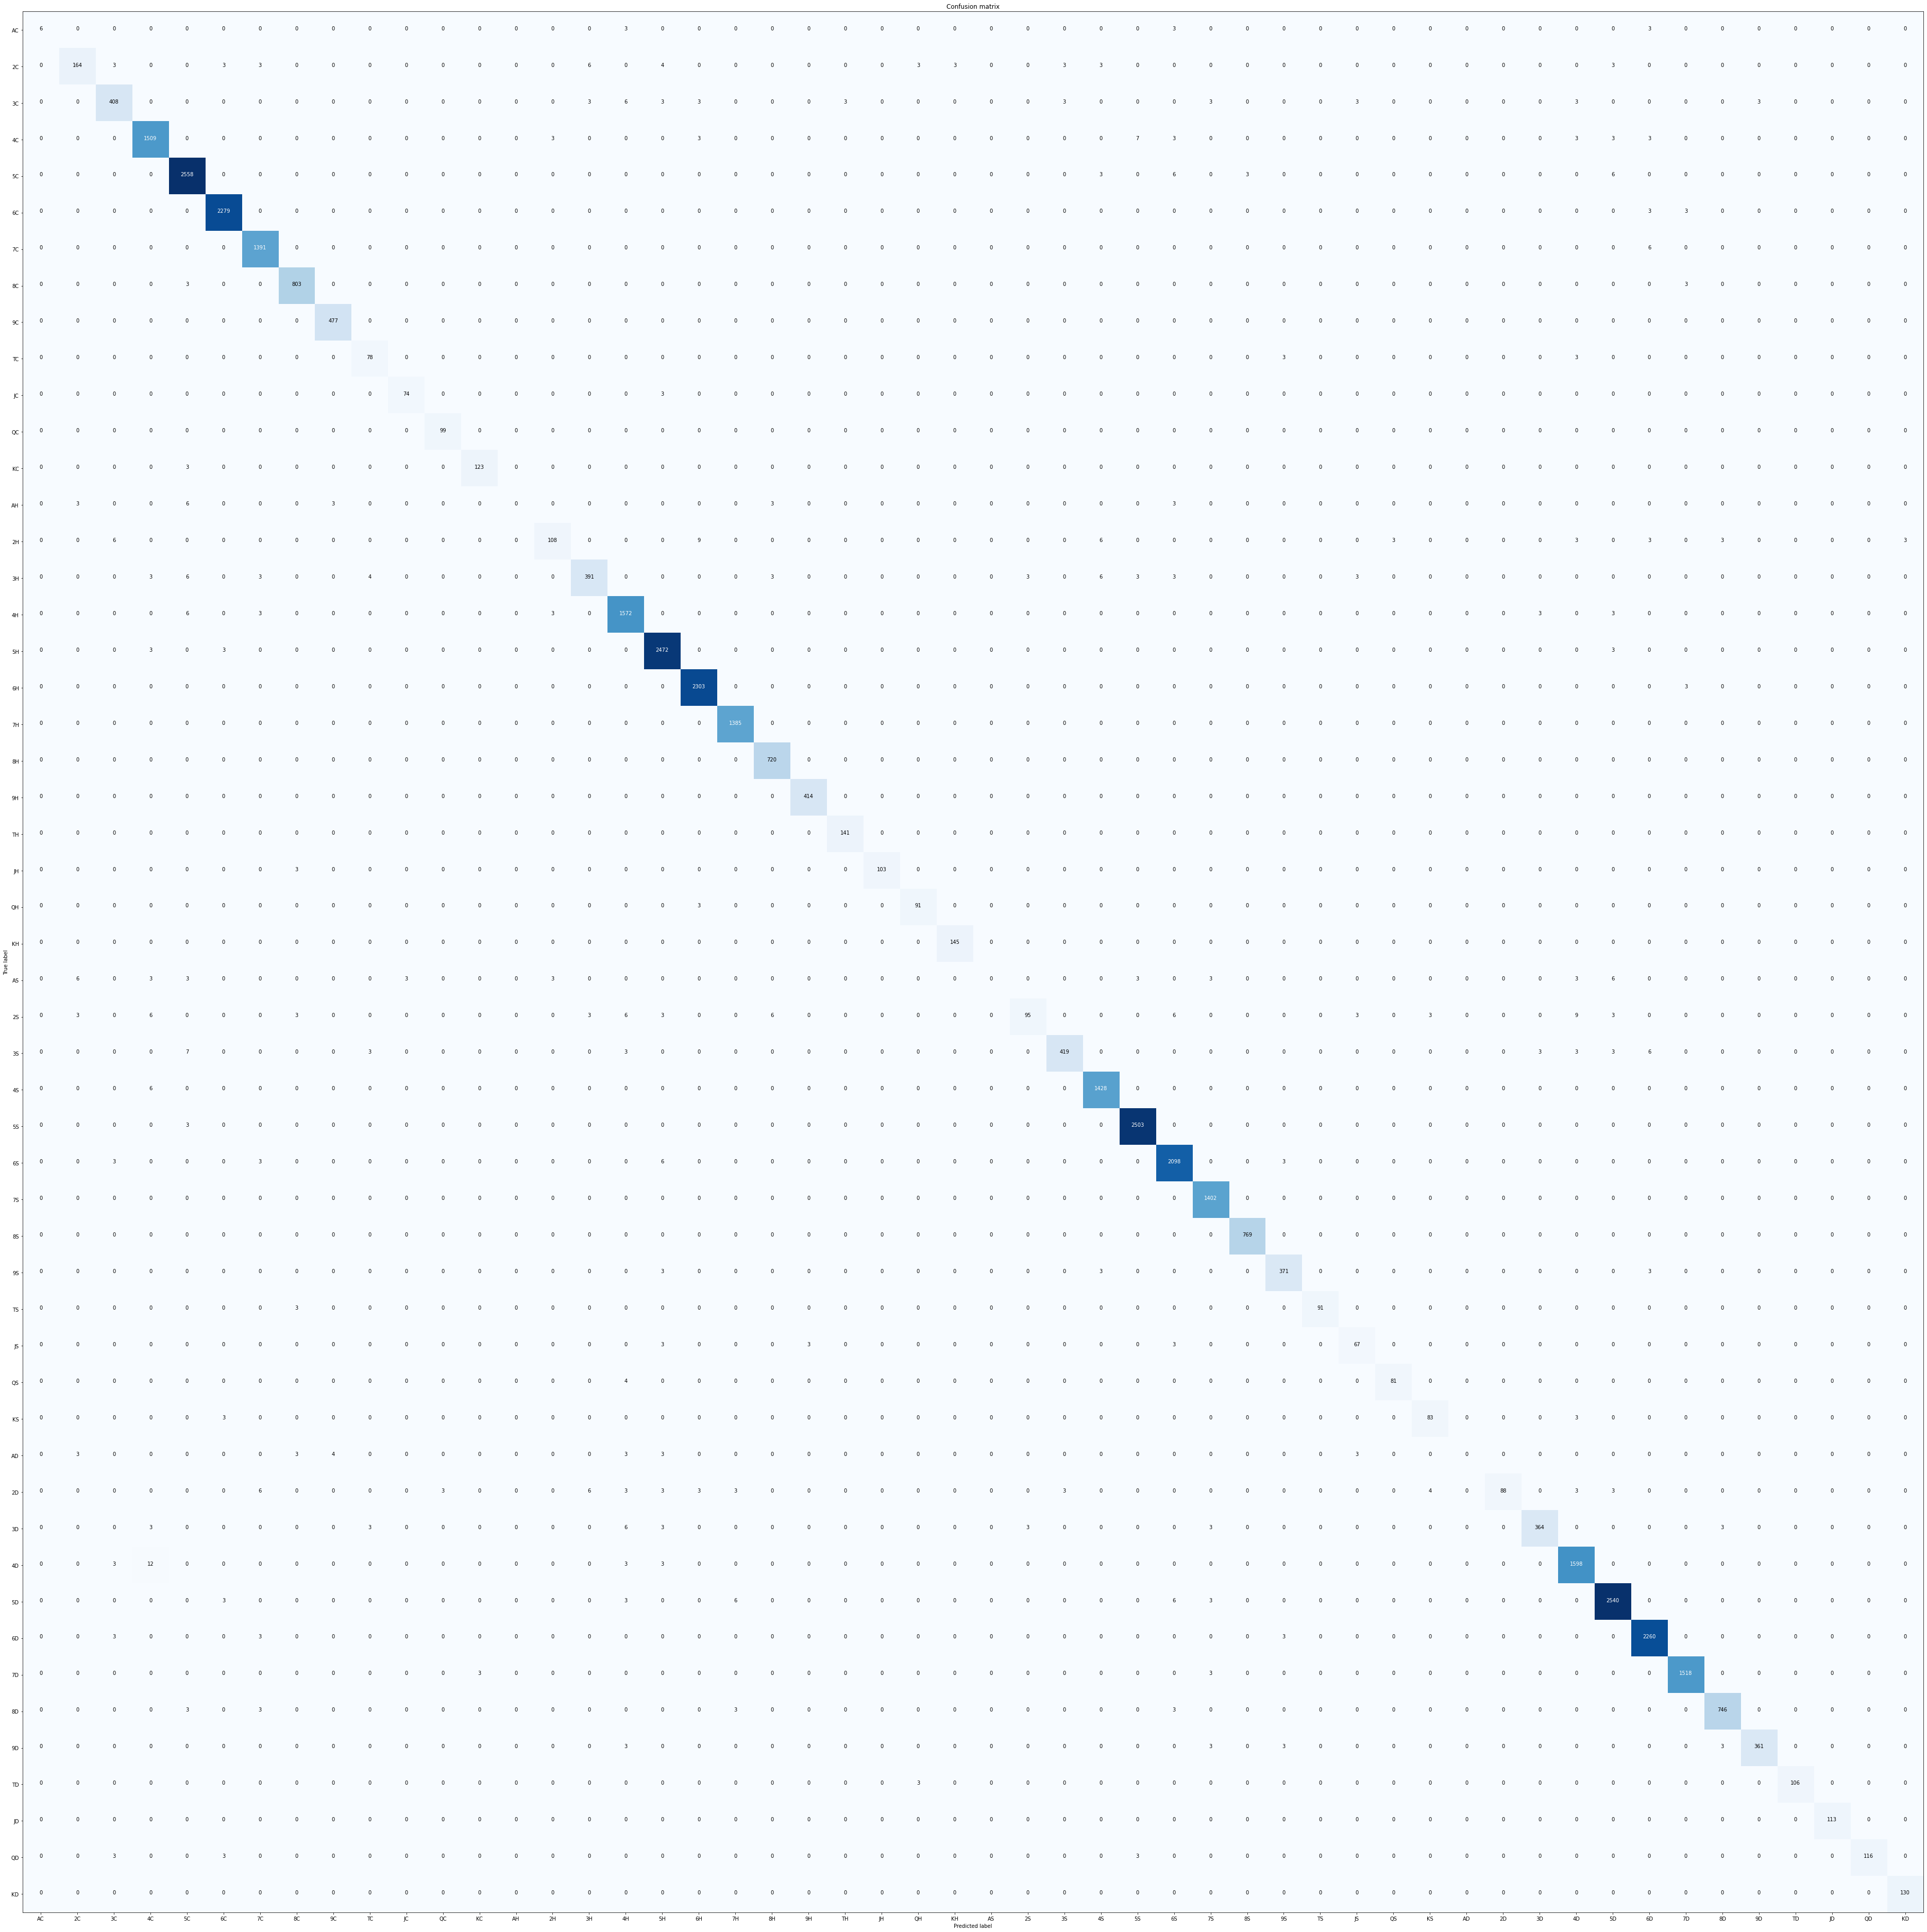

In [ ]:
currGames = 8000
test_loader_6k, classes = load_test_data(currGames)
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_6k, mode='val')

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(currGames)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

###### all epoch

Accuracy: 98.45
Normalized confusion matrix
[[0.24999938 0.         0.         ... 0.         0.         0.        ]
 [0.         0.8478259  0.02173913 ... 0.         0.         0.        ]
 [0.         0.         0.92792784 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999963 0.         0.        ]
 [0.         0.         0.02941176 ... 0.         0.91176444 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999968]]


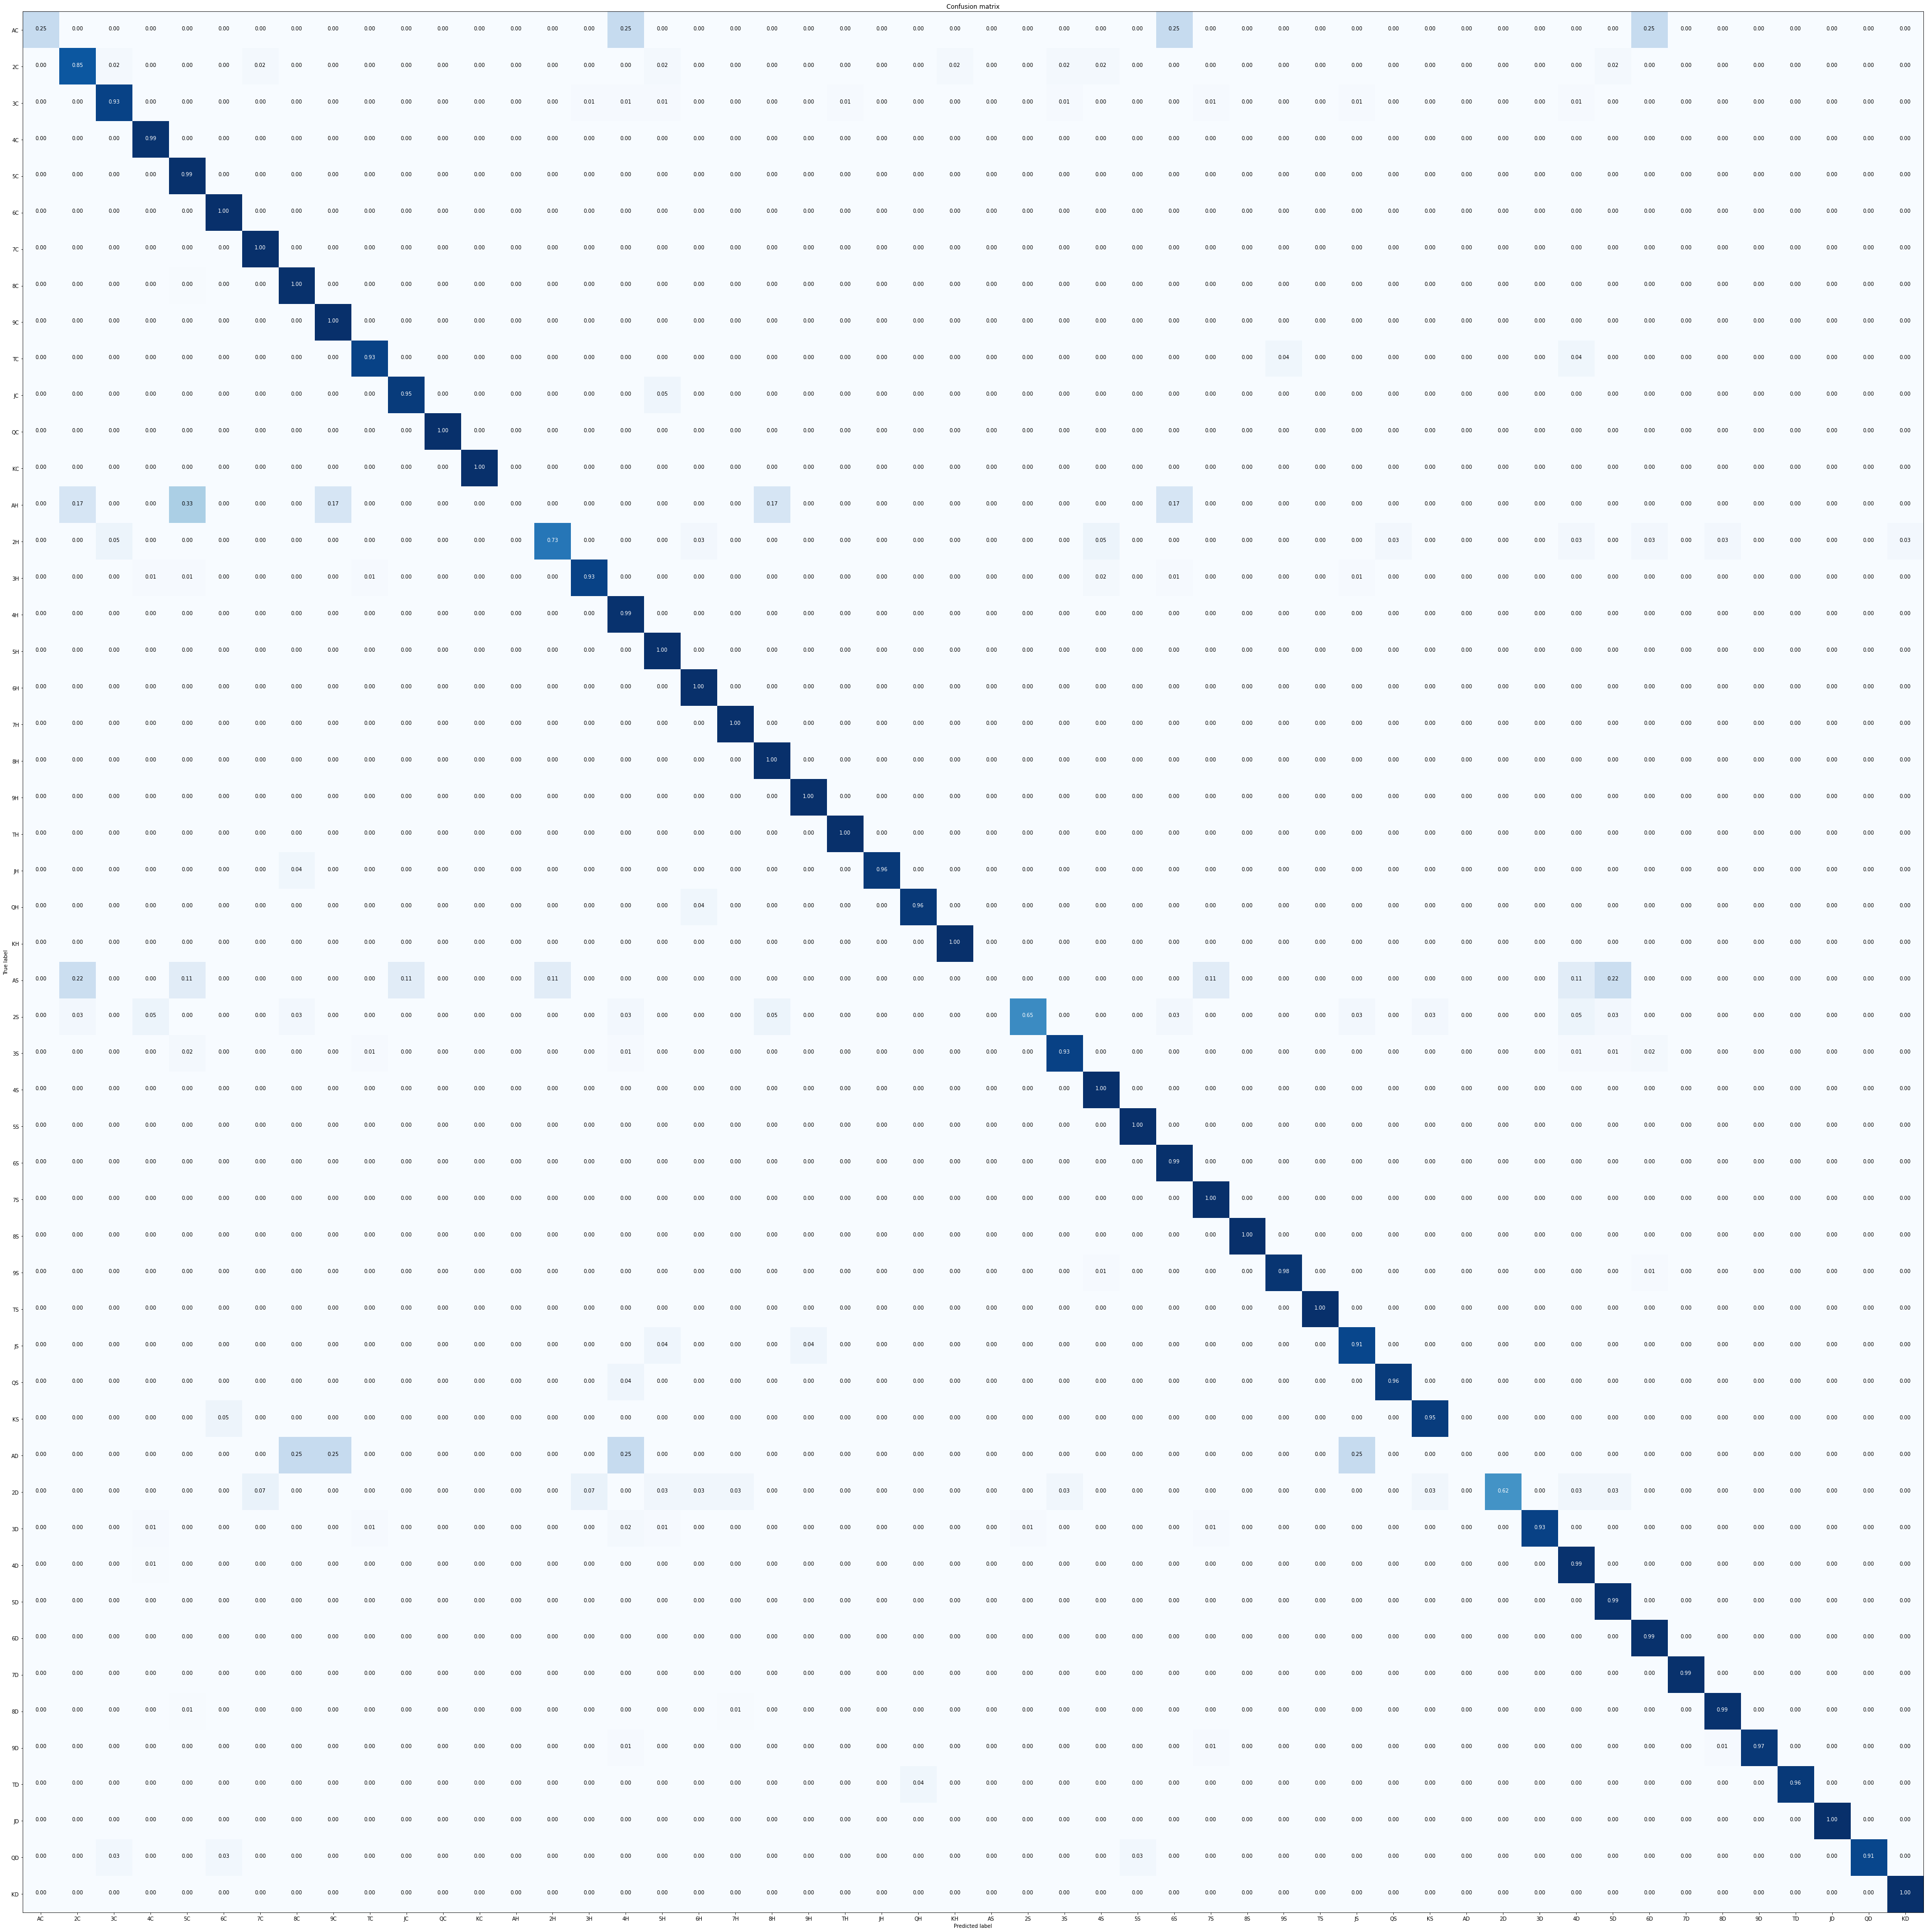

Confusion matrix, without normalization
[[  1   0   0 ...   0   0   0]
 [  0  39   1 ...   0   0   0]
 [  0   0 103 ...   0   0   0]
 ...
 [  0   0   0 ...  27   0   0]
 [  0   0   1 ...   0  31   0]
 [  0   0   0 ...   0   0  31]]


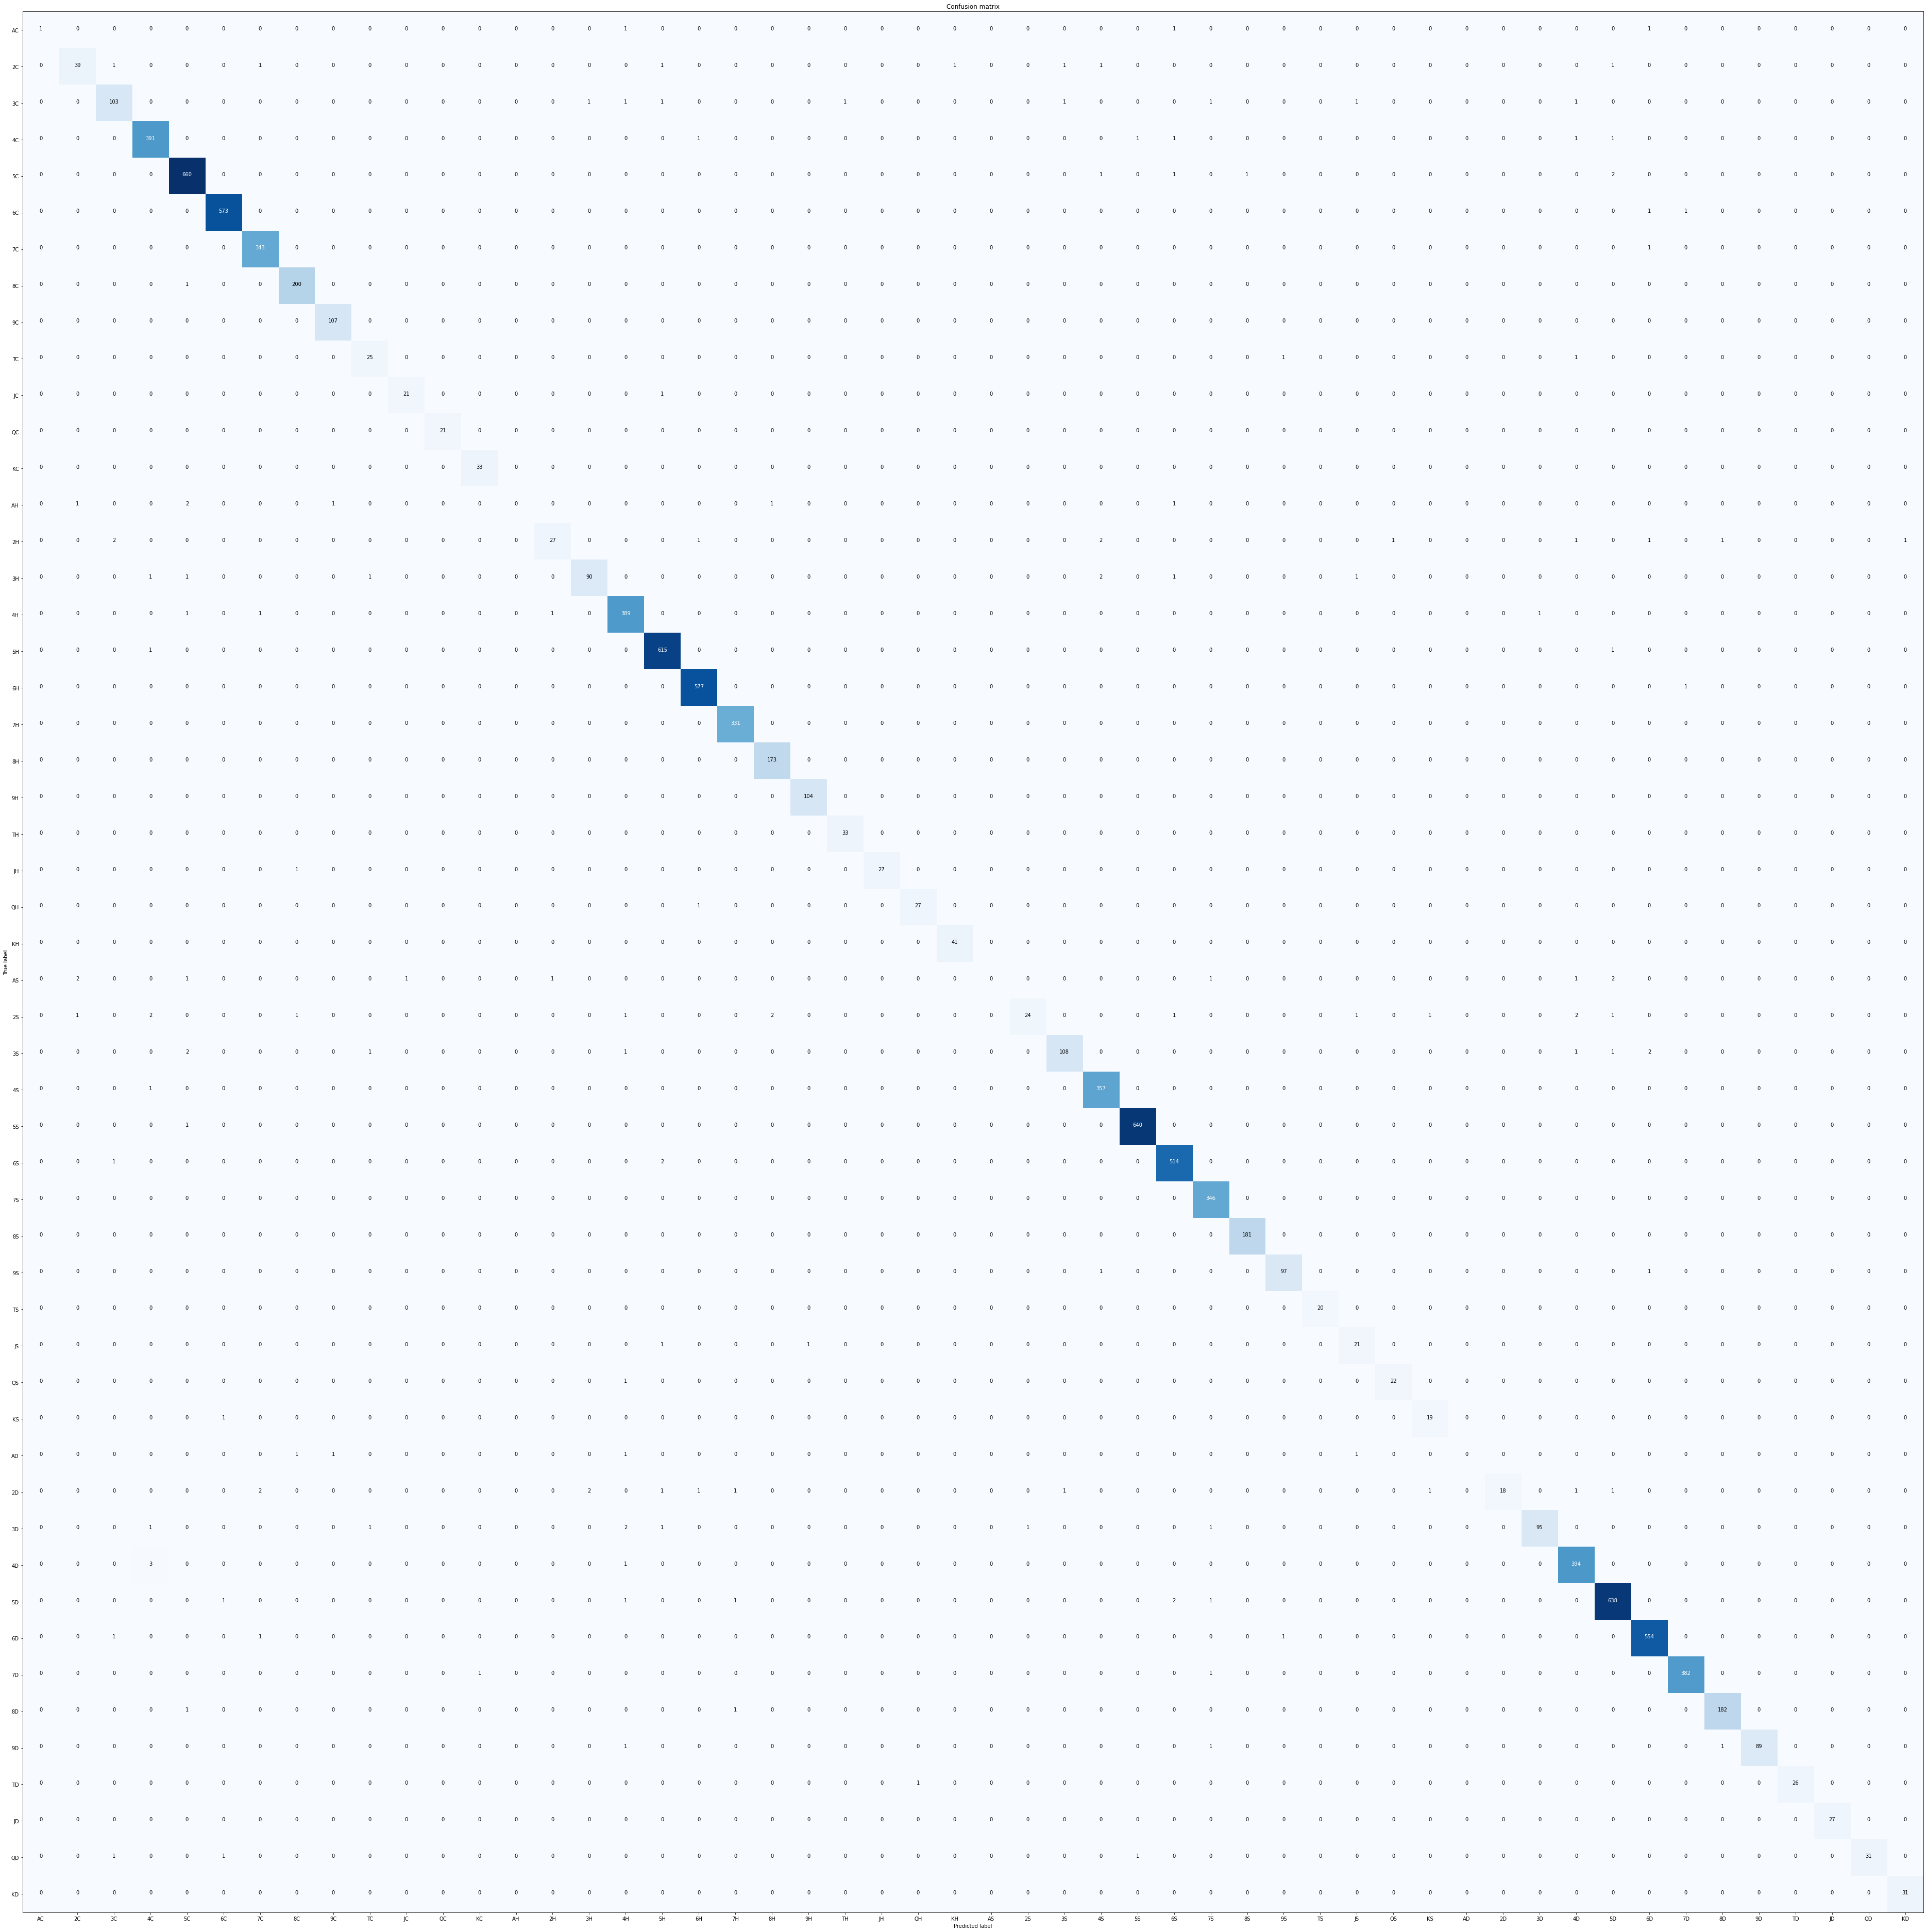

In [ ]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_2k)

###### max validation accuracy

Accuracy: 98.45
Normalized confusion matrix
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.8478259  0.02173913 ... 0.         0.         0.        ]
 [0.         0.         0.92792784 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999963 0.         0.        ]
 [0.         0.         0.02941176 ... 0.         0.91176444 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999968]]


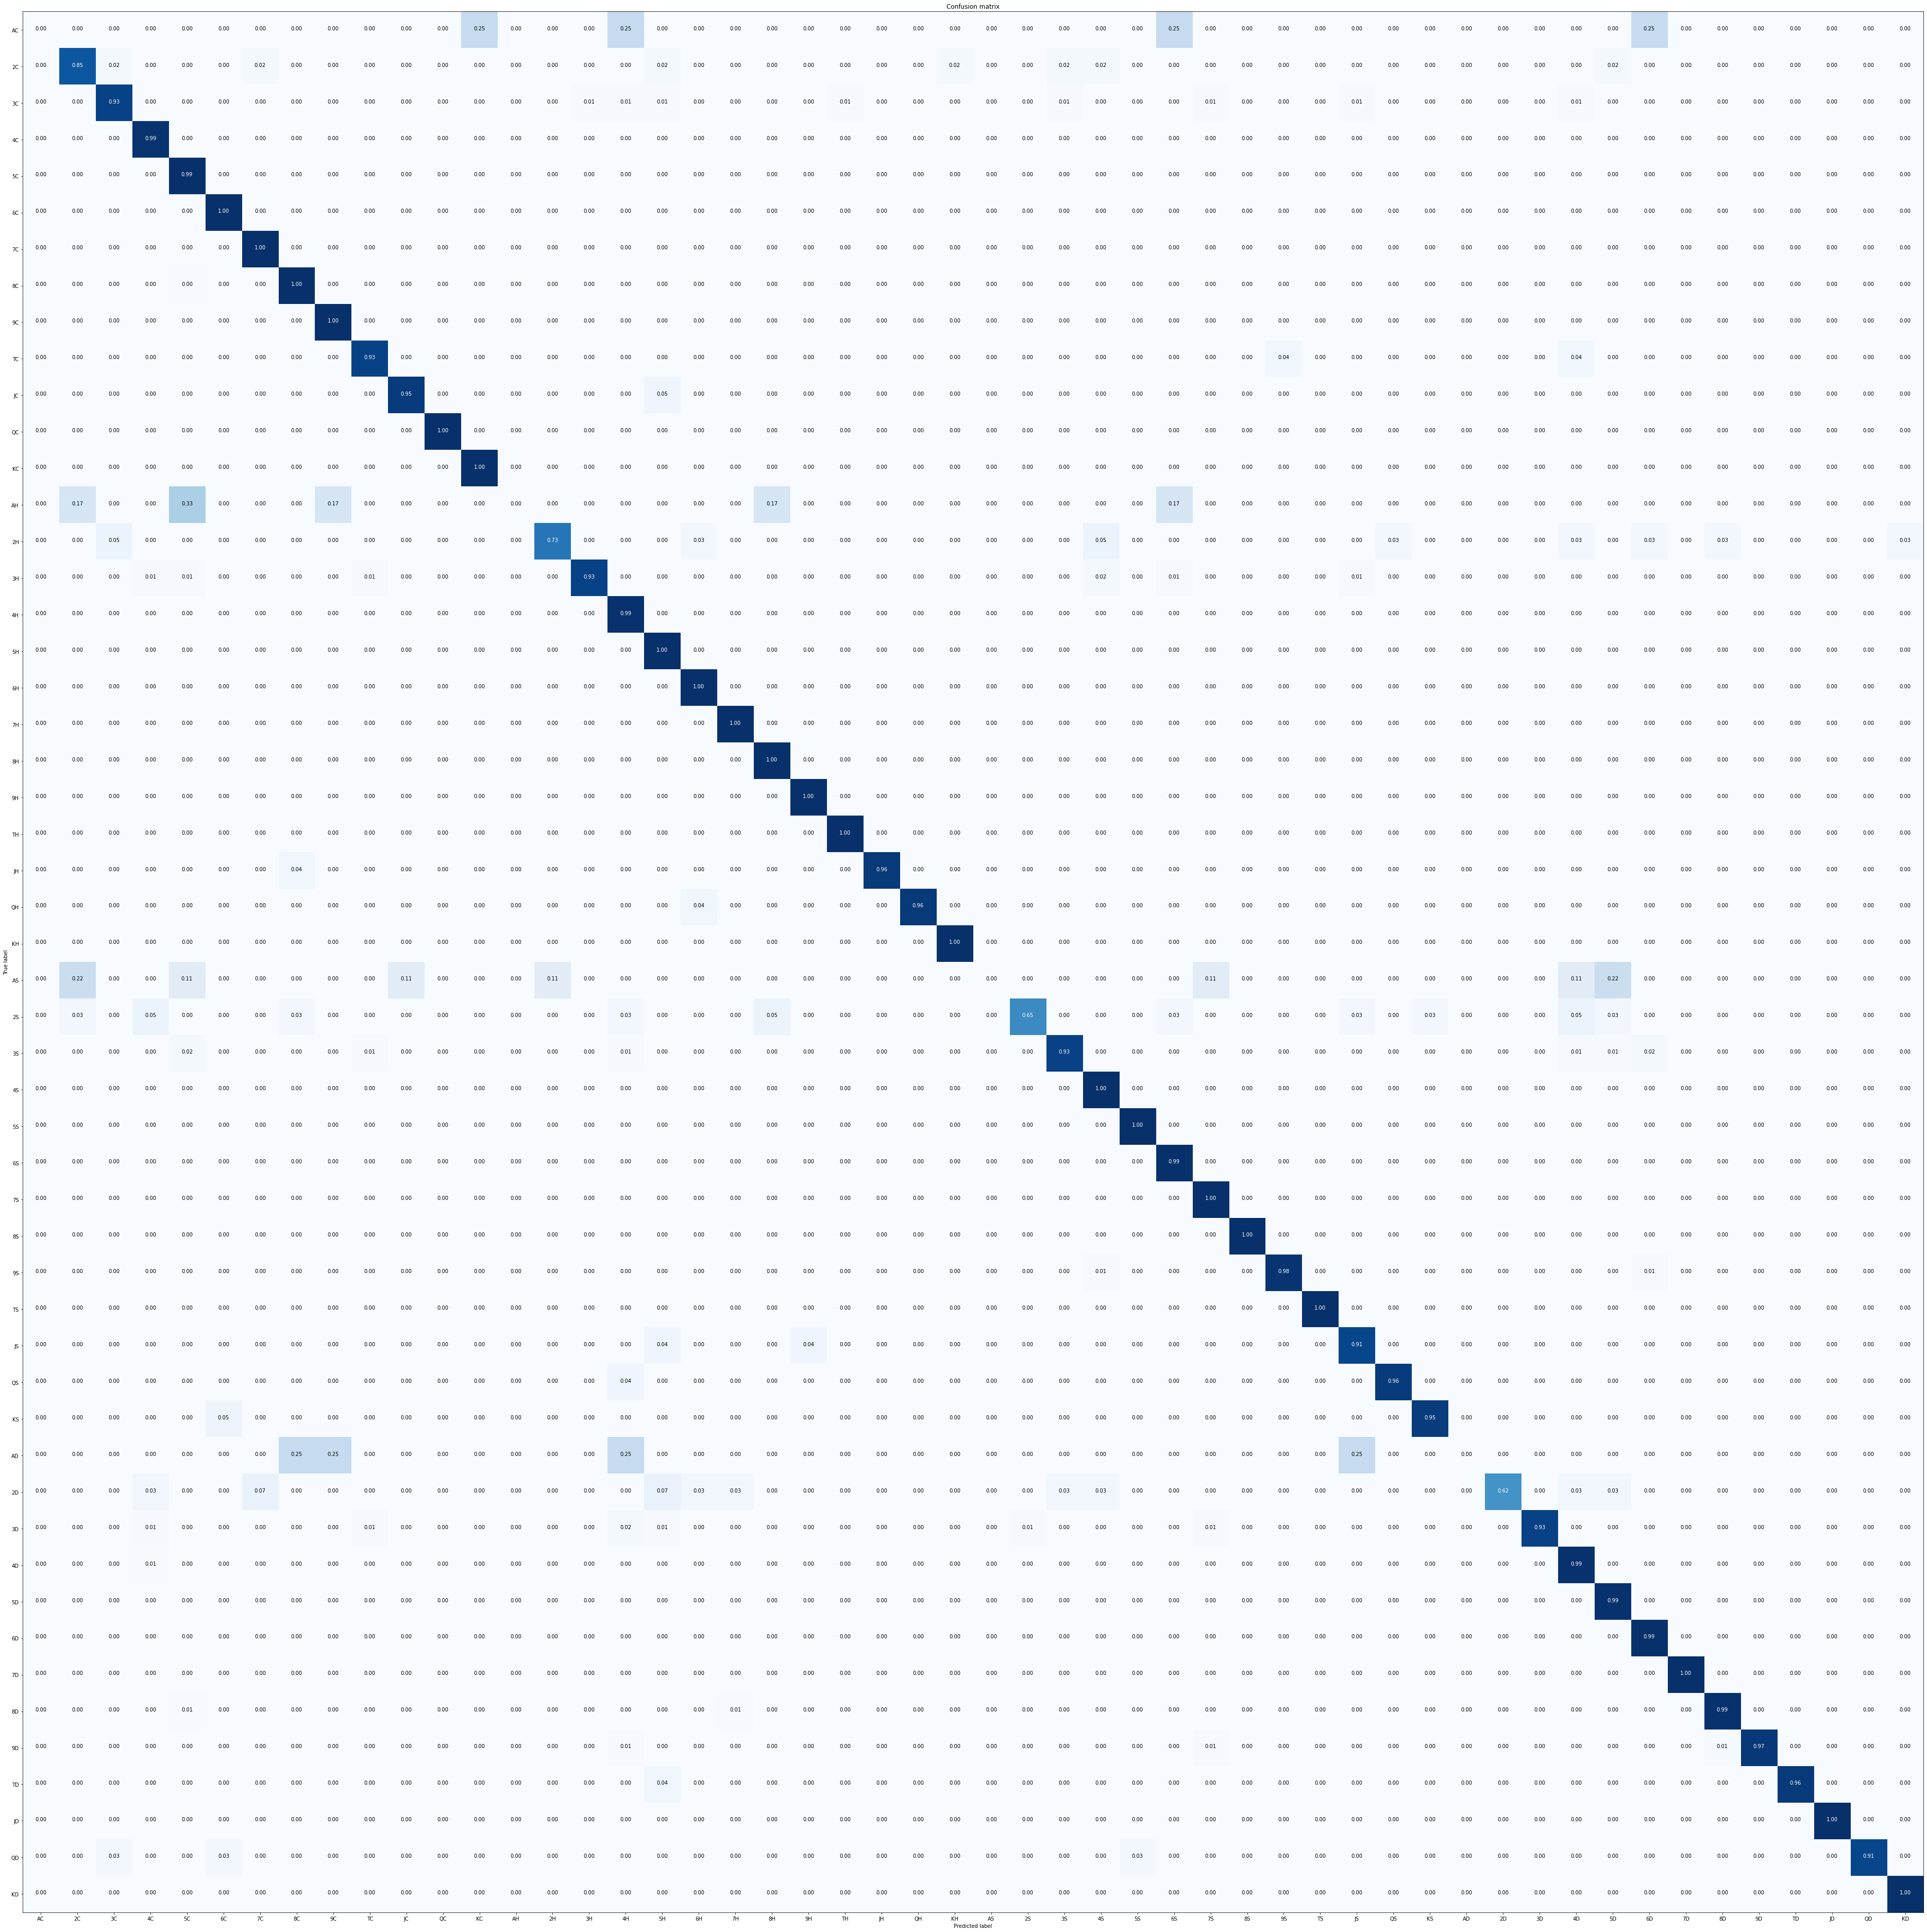

Confusion matrix, without normalization
[[  0   0   0 ...   0   0   0]
 [  0  39   1 ...   0   0   0]
 [  0   0 103 ...   0   0   0]
 ...
 [  0   0   0 ...  27   0   0]
 [  0   0   1 ...   0  31   0]
 [  0   0   0 ...   0   0  31]]


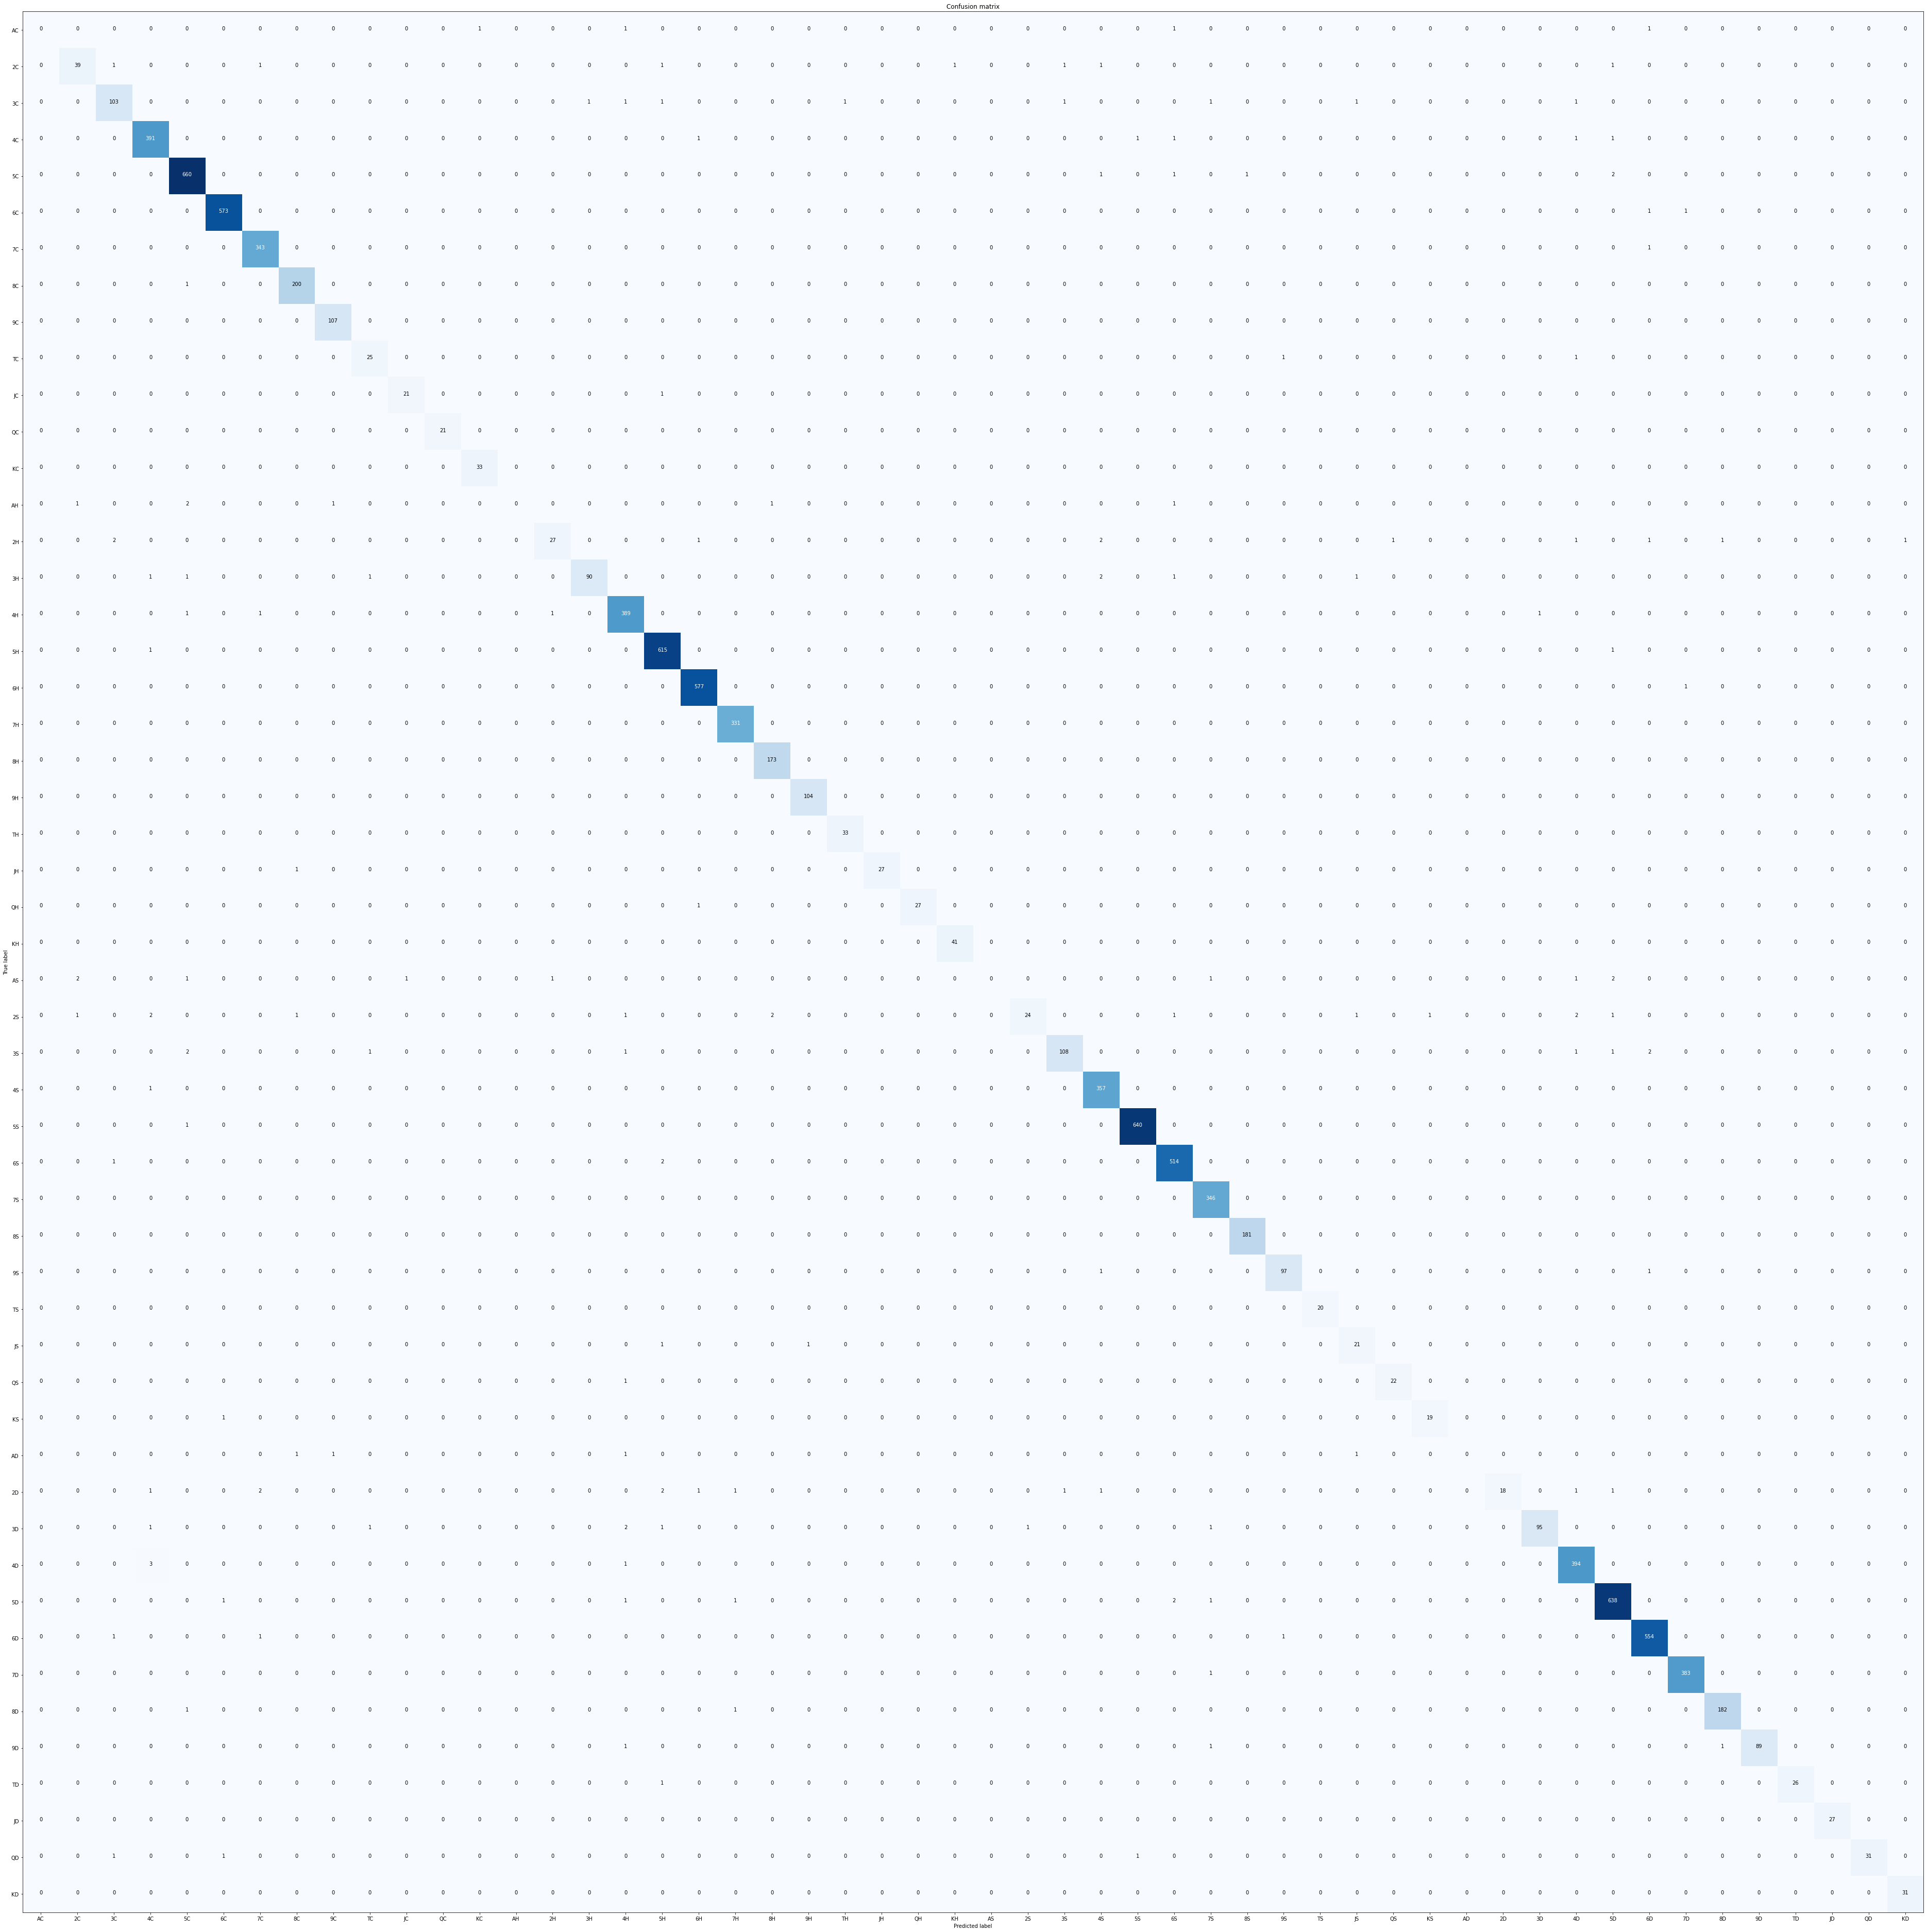

In [ ]:
model_acc, loss_fnc, _ = load_model(model=model_acc)
plot_cm(classes, model_acc, test_loader_2k, mode='acc')

###### min validation loss

Accuracy: 98.45
Normalized confusion matrix
[[0.24999938 0.         0.         ... 0.         0.         0.        ]
 [0.         0.8478259  0.02173913 ... 0.         0.         0.        ]
 [0.         0.         0.92792784 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999963 0.         0.        ]
 [0.         0.         0.02941176 ... 0.         0.91176444 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999968]]


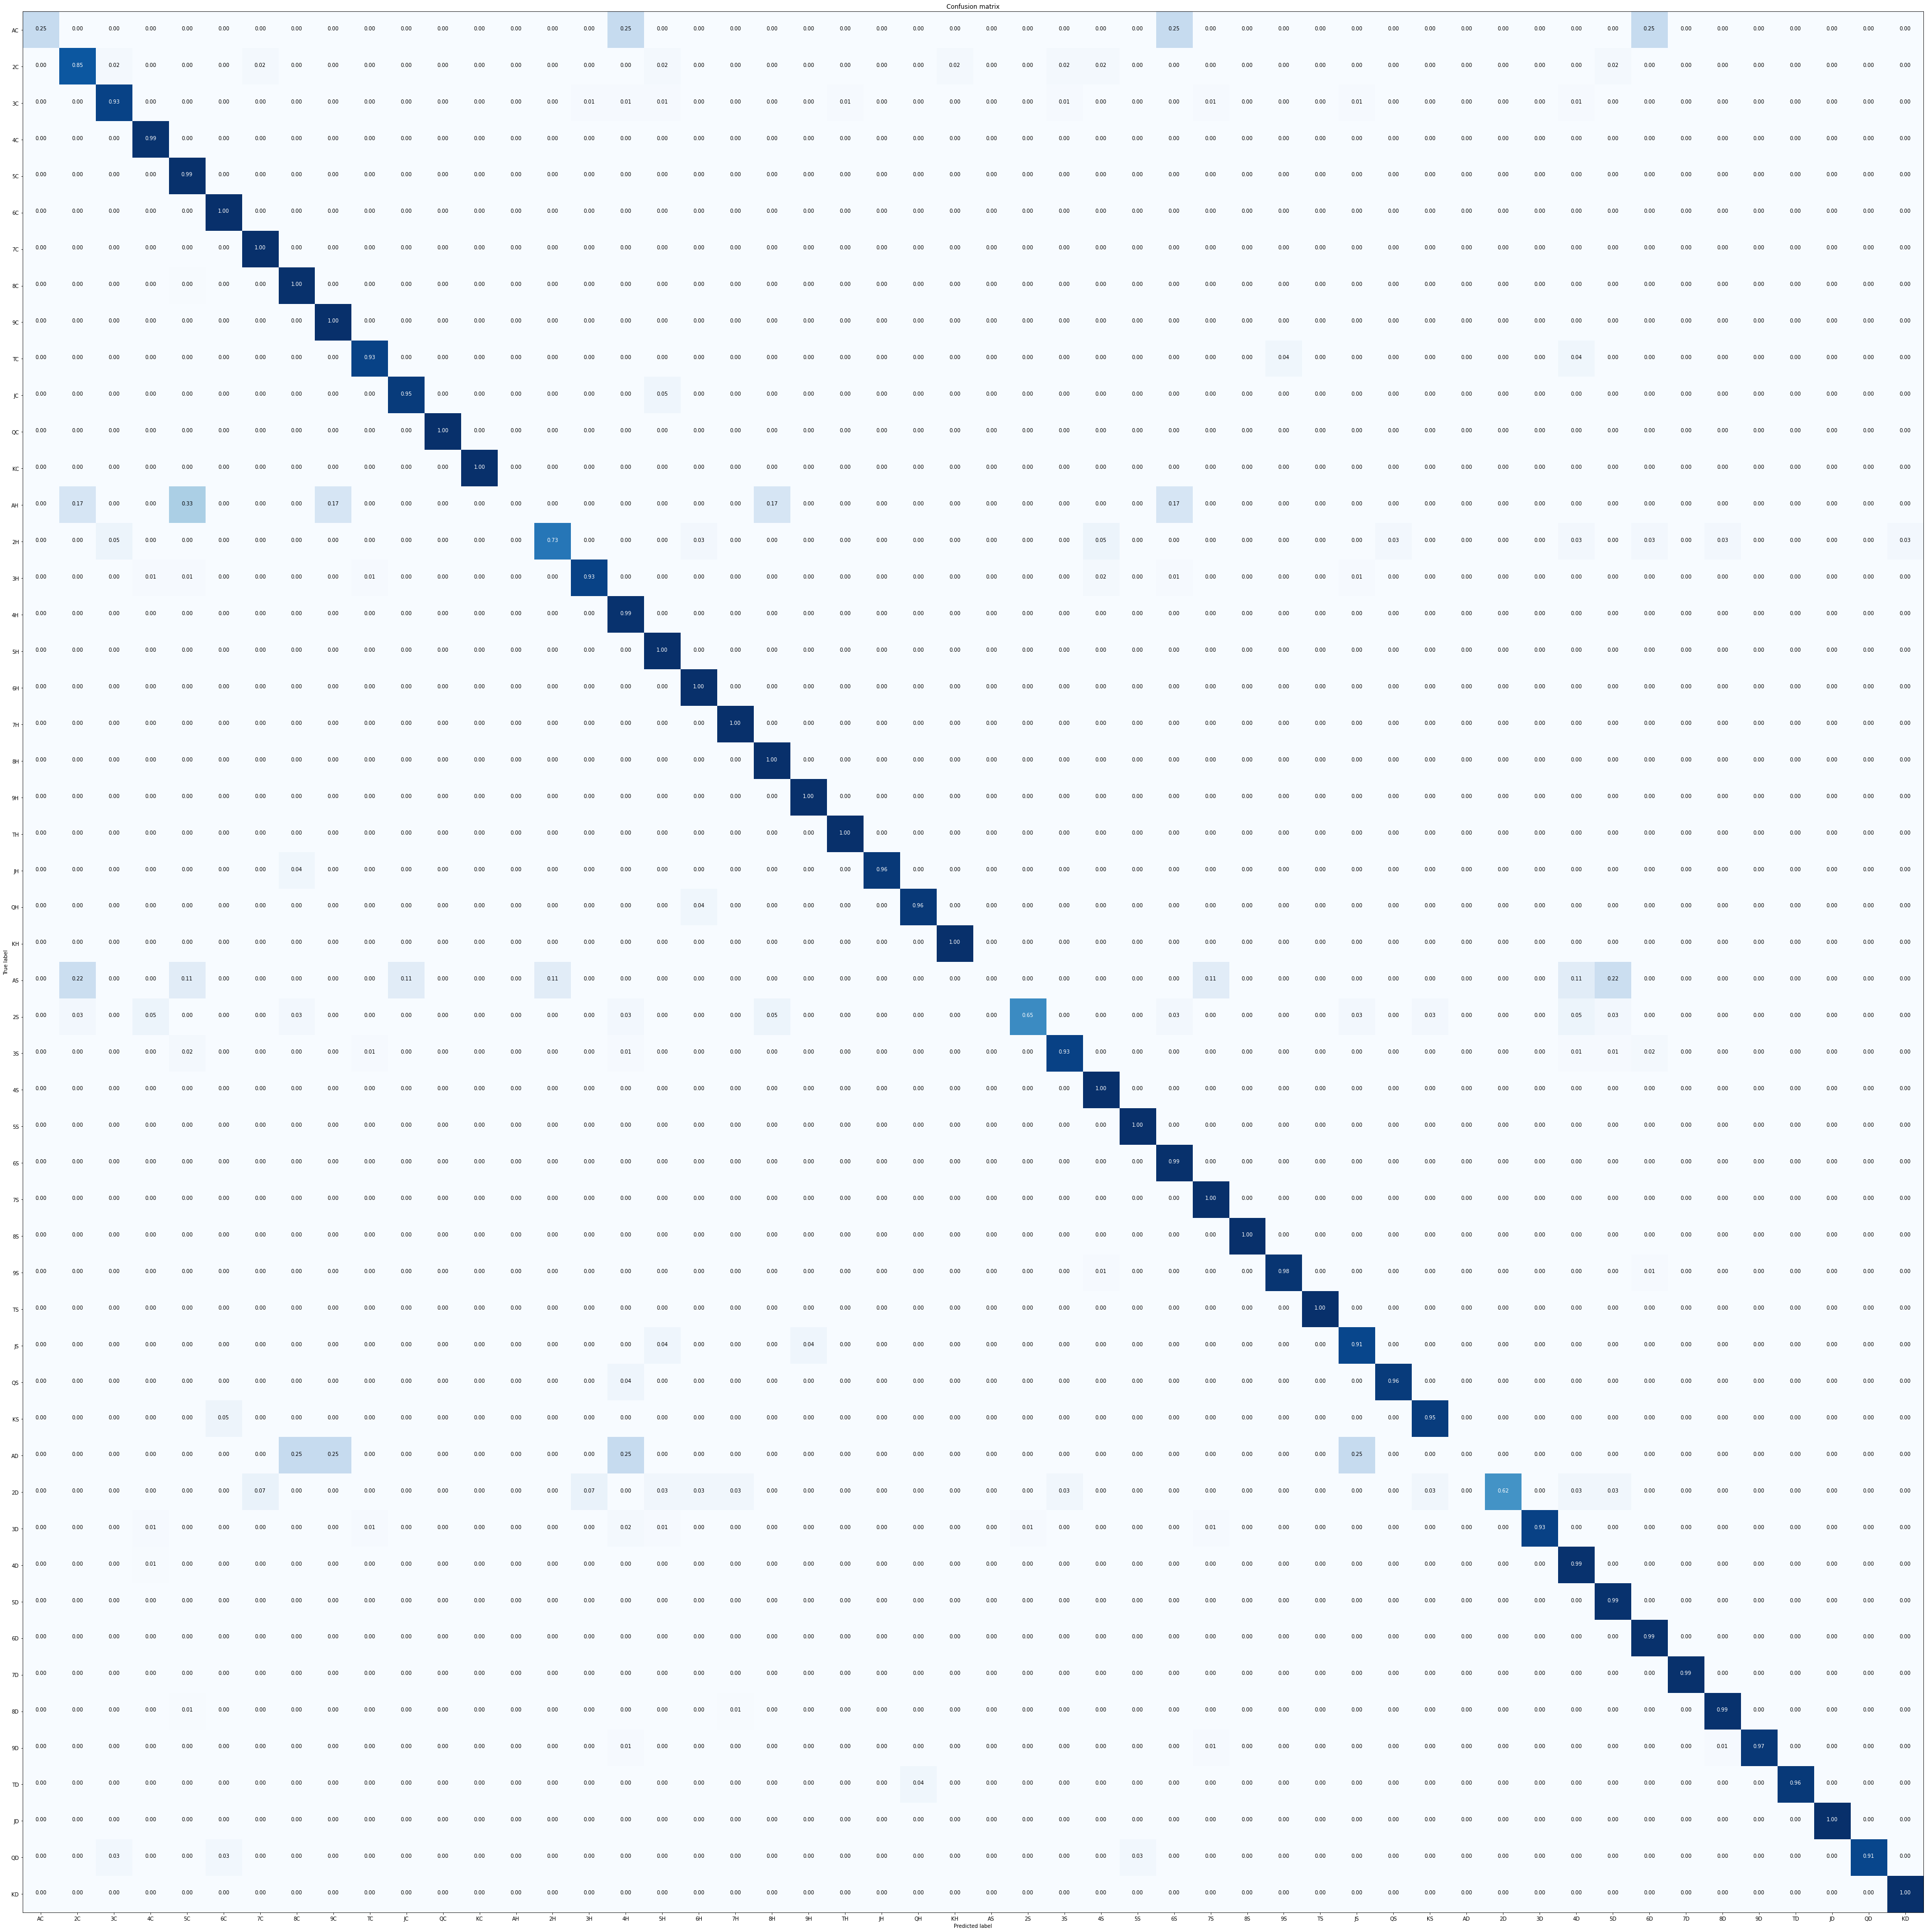

Confusion matrix, without normalization
[[  1   0   0 ...   0   0   0]
 [  0  39   1 ...   0   0   0]
 [  0   0 103 ...   0   0   0]
 ...
 [  0   0   0 ...  27   0   0]
 [  0   0   1 ...   0  31   0]
 [  0   0   0 ...   0   0  31]]


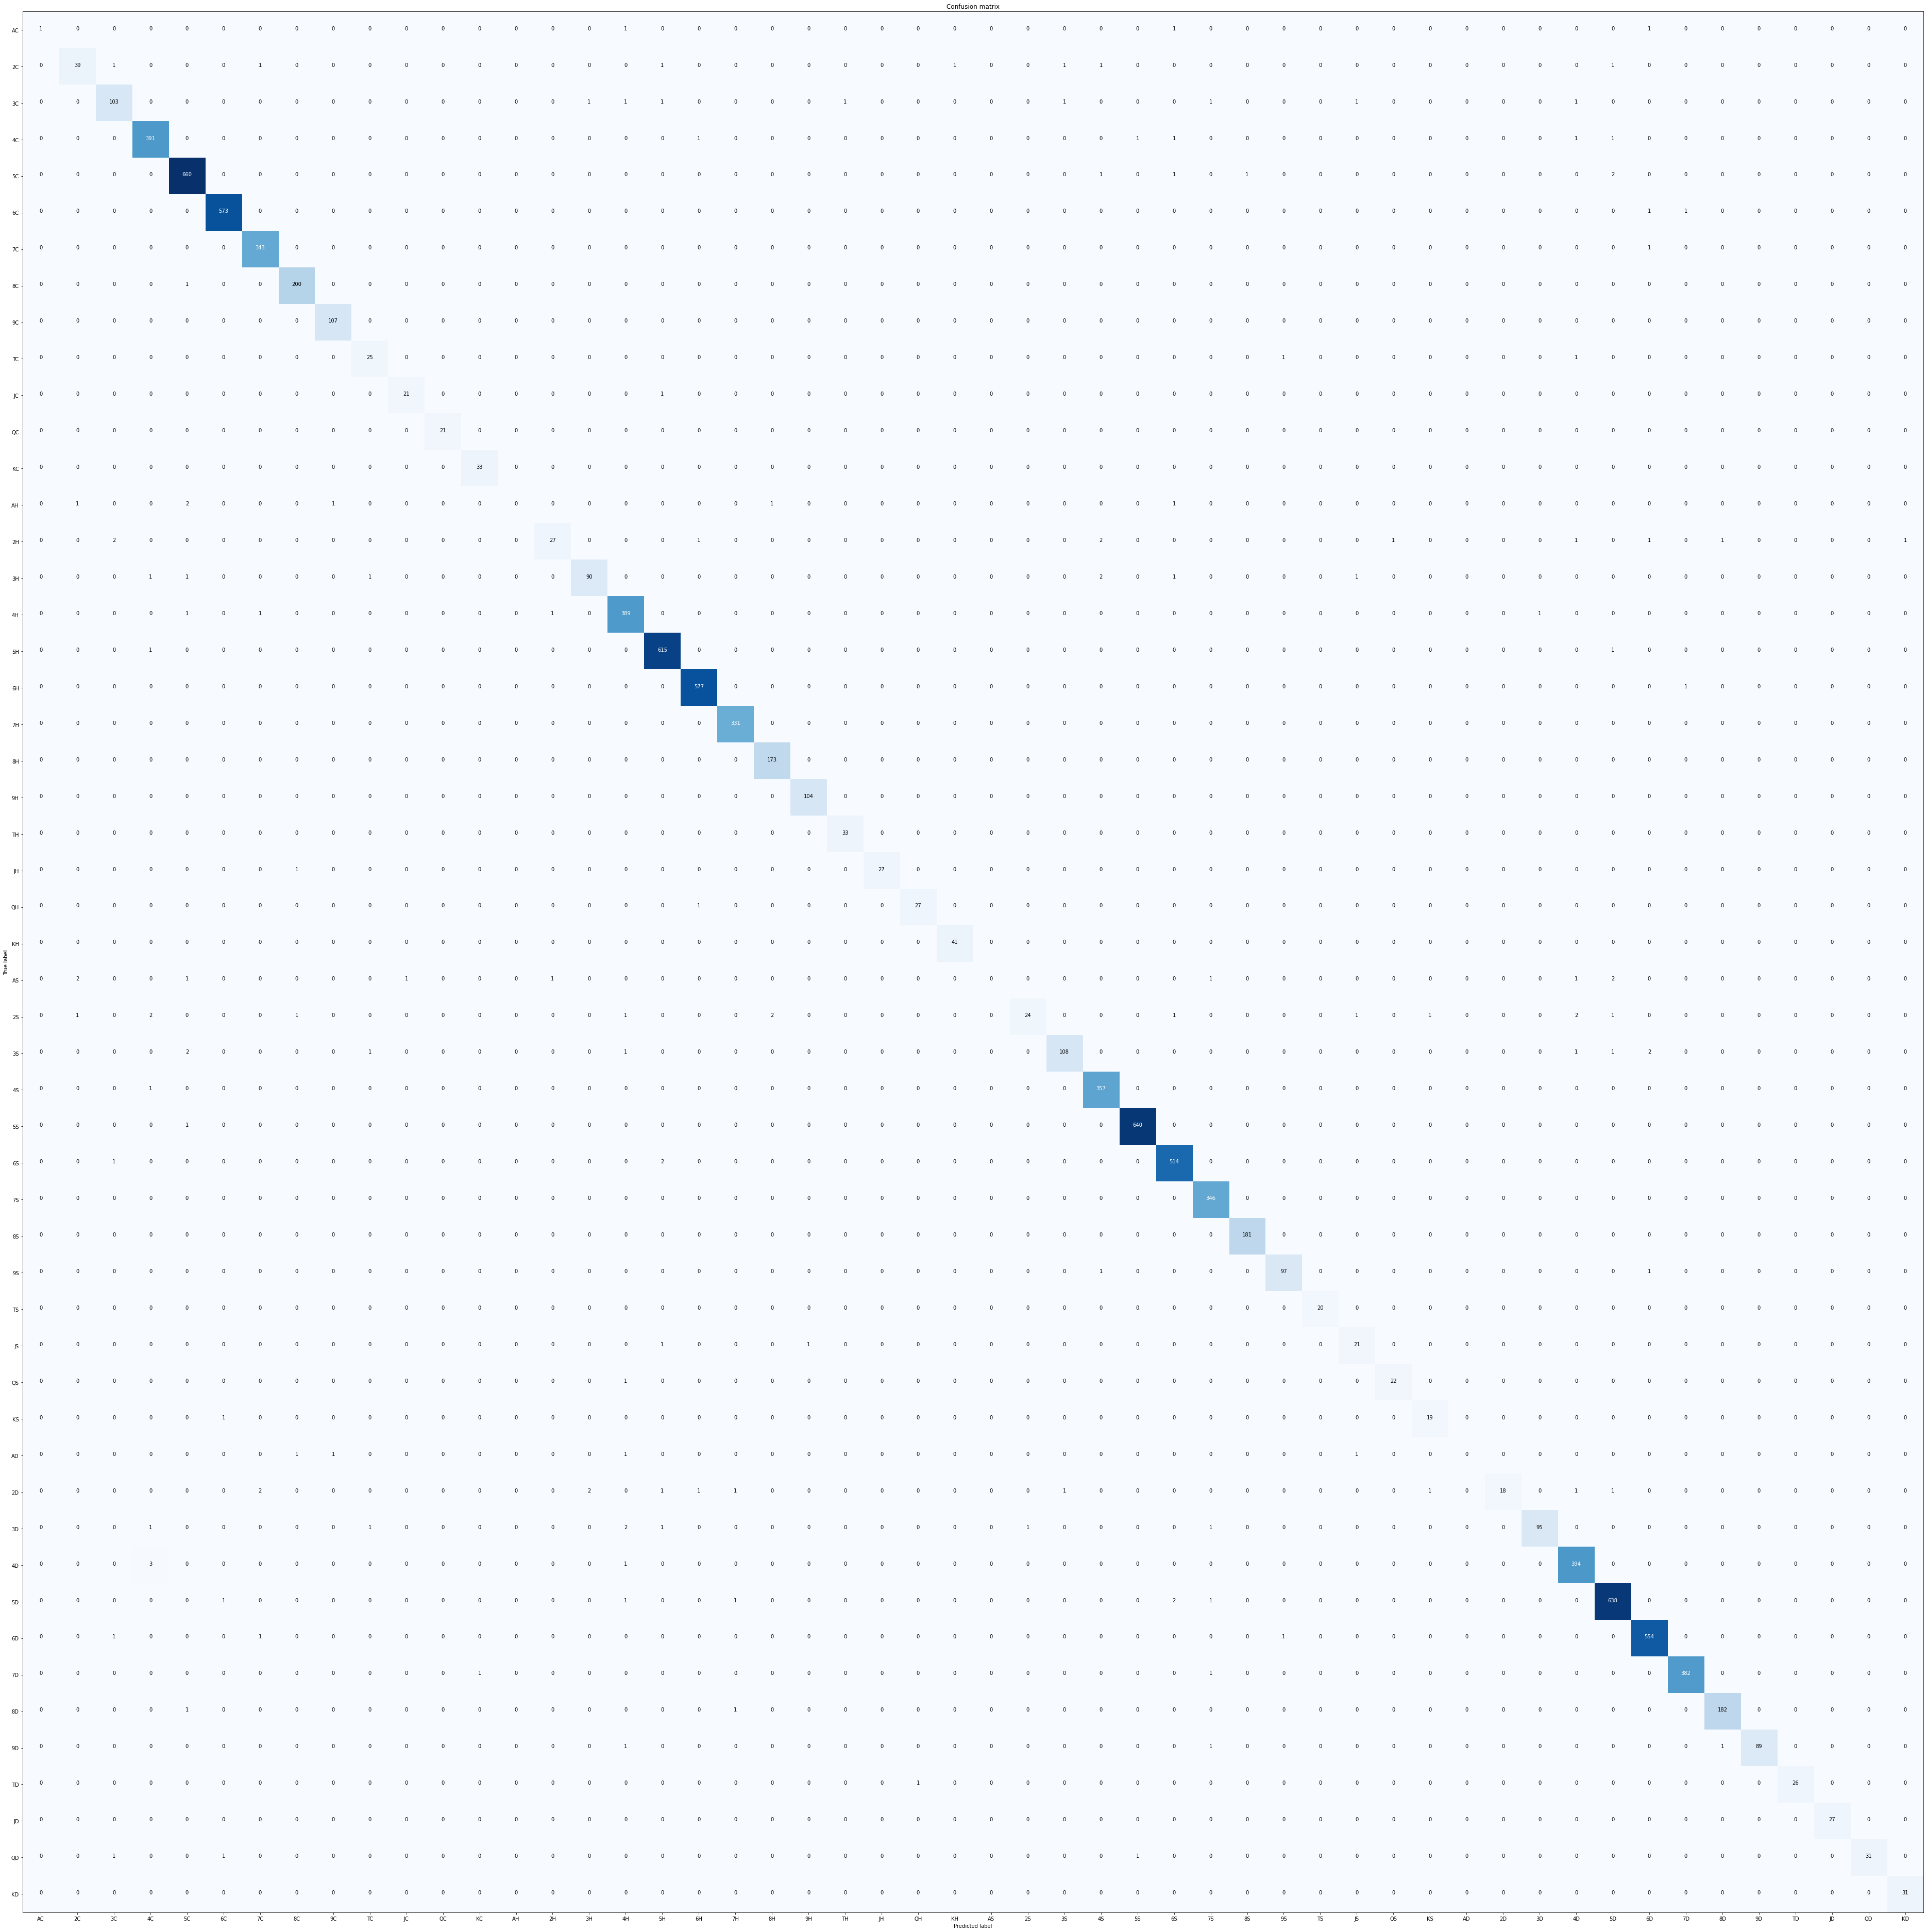

In [ ]:
model_loss, loss_fnc, _ = load_model(model=model_loss)
plot_cm(classes, model_loss, test_loader_2k, mode='loss')

## all_states_all_actions

Specify the following parameters:

- Data Selection:
 - model_name
 - state-action pair
```r
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'}
```
 - numGames
 - pruneStatesList
 ```r
 {'currHand','topCard','deadCard','oppCard','unknownCard'}
 ```
 - actionChoice = 'all'
```r
{'all','draw_pickup','discard','knock'}
```

- Model Parameters:

| Parameter     | Type      |Default|
| ------------- |:---------:| -----:|
| batch_size    | int       | 1000  |
| learning_rate | float     | 0.001 |
| epoch         | int       | 100   |
| pre_train     | bool (T/F)| False |
| model_PT      | str (path)| null  |

In [ ]:
# model name
model_name = 'all_states_all_actions'

# state_action pair, and dataset selection
state = 'apbd'
action = 'knock'
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 500

# Pretrain model
pre_train = False
model_PT = ''

### Directories

In [ ]:
# create model and plot directories if do not exist

# model directories
state_pth = '{}/models/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
model_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(model_pth):
    os.mkdir(model_pth)

# plot directories
state_pth = '{}/plots/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
plot_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(plot_pth):
    os.mkdir(plot_pth)

# data directory
data_pth = '{}/data/{}/{}'.format(pth,state,action)

### Load, Prune, Split Data

In [ ]:
if action in state_action_pair[state]:
    states = np.load('{}/s_{}k.npy'.format(data_pth,numGames//1000))
    actions = np.load('{}/a_{}k.npy'.format(data_pth,numGames//1000))

    # prune states
    states = pruneStates(states, pruneStatesList)

    # choosable actions
    actions, classes = chooseActions(actions, all_classes, actionChoice)

    # balance classes
    if balance:
        states,actions = balanceClasses(states,actions)

    # split train/val
    data_train, data_val, label_train, label_val = train_test_split(states, actions, test_size=0.3, random_state=421)
else:
    print('illegeal state-action pair')

In [ ]:
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

### Train Model

Epoch: 1 | Train Loss: 0.03740905 | Train acc: 0.034545
              Val Loss: 0.00896680 |   Val acc: 0.063846
Epoch: 2 | Train Loss: 0.00896447 | Train acc: 0.068048
              Val Loss: 0.00895606 |   Val acc: 0.067951
Epoch: 3 | Train Loss: 0.00893842 | Train acc: 0.064673
              Val Loss: 0.00891156 |   Val acc: 0.068287
Epoch: 4 | Train Loss: 0.00887598 | Train acc: 0.069520
              Val Loss: 0.00882693 |   Val acc: 0.066108
Epoch: 5 | Train Loss: 0.00879173 | Train acc: 0.067078
              Val Loss: 0.00875661 |   Val acc: 0.069879
Epoch: 6 | Train Loss: 0.00874716 | Train acc: 0.090455
              Val Loss: 0.00873138 |   Val acc: 0.088312
Epoch: 7 | Train Loss: 0.00872674 | Train acc: 0.096739
              Val Loss: 0.00871371 |   Val acc: 0.128697
Epoch: 8 | Train Loss: 0.00871369 | Train acc: 0.128411
              Val Loss: 0.00870296 |   Val acc: 0.112778
Epoch: 9 | Train Loss: 0.00870461 | Train acc: 0.132900
              Val Loss: 0.00869463 |   V

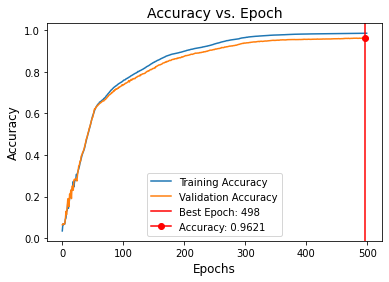

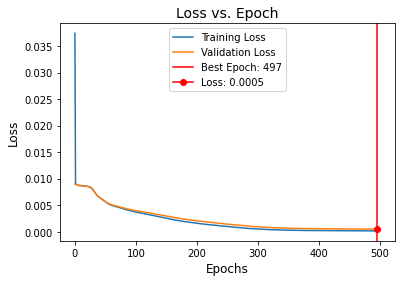

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True, pre_train=pre_train, model_PT=model_PT)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

In [147]:
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

##### Train Set

In [148]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, train_loader)

Accuracy: 98.54
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [149]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, val_loader)

Accuracy: 96.19
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (6k)

In [150]:
currGames = 8000
test_loader_6k, classes = load_test_data(currGames)
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_6k, mode='val')

Accuracy: 97.84
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [151]:
currGames = 2000
test_loader_2k, classes = load_test_data(currGames)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

###### all epoch

In [152]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_2k)

Accuracy: 97.87
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [153]:
model_acc, loss_fnc, _ = load_model(model=model_acc)
plot_cm(classes, model_acc, test_loader_2k, mode='acc')

Accuracy: 97.88
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [154]:
model_loss, loss_fnc, _ = load_model(model=model_loss)
plot_cm(classes, model_loss, test_loader_2k, mode='loss')

Accuracy: 97.85
Normalized confusion matrix
Confusion matrix, without normalization
